In [59]:
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import uproot3 as uproot
#import uproot4 as uproot
import pandas as pd
import numpy as np
import math
from tqdm import tqdm

import kdar_functions as kdar
import general_functions as utils

import importlib

print(np.__version__)

1.26.4


In [60]:
importlib.reload(kdar)
importlib.reload(utils)

<module 'general_functions' from '/Users/bbogart/Documents/analysisCode/kdar_bdt/general_functions.py'>

In [61]:
single_run = False

In [62]:
def weighted_quantile(data, weights, quantile):
    if not (0 <= quantile <= 1):
        raise ValueError("Quantile must be between 0 and 1.")

    sorted_indices = np.argsort(data)
    sorted_data = data[sorted_indices]
    sorted_weights = weights[sorted_indices]

    cumulative_weights = np.cumsum(sorted_weights)
    total_weight = cumulative_weights[-1]

    target_cumulative_weight = quantile * total_weight
    
    index = np.searchsorted(cumulative_weights, target_cumulative_weight, side='left')

    if index == 0:
        return sorted_data[0]
    elif index == len(sorted_data):
        return sorted_data[-1]

    if cumulative_weights[index - 1] == target_cumulative_weight:
        return (sorted_data[index - 1] + sorted_data[index]) / 2.0
    else:
        return sorted_data[index]


In [63]:
def get_stats(diff,weights=[],verbose=True):

    q=[0,0,0]
    
    if len(weights)!=len(diff): q = np.quantile(diff, [0.16, 0.5, 0.84])
    else: 
        q[0] = weighted_quantile(diff, weights, 0.16)
        q[1] = weighted_quantile(diff, weights, 0.5)
        q[2] = weighted_quantile(diff, weights, 0.84)
            
    mean = np.average(diff, weights=weights)
    std = np.sqrt(np.average((diff - mean)**2, weights=weights))
    iqr = (q[2]-q[0])/2
    rms = np.average(np.sqrt(diff**2), weights=weights)
    
    if verbose:
        print("mean:",mean)
        print("median:",q[1])
        print("std:",std)
        
        print("q1:",q[0])
        print("q3:",q[2])
        print("IQR:",iqr)
        
        print("FWHM:",np.sqrt(q[0]*q[0]+q[2]*q[2])/2)
        print("RMS:",rms)
    
    return mean,q,std,iqr,rms

In [64]:
def plot_res_all(df,query,truth_var,reco_var,
                 xmin1,xmax1,nxbins1,
                 xmin2,xmax2,nxbins2,ymin2,ymax2,nybins2,gamma,
                 xmin3,xmax3,nxbins3,ymin3,ymax3,nybins3,vmin3,vmax3,
                 weight_var="net_weight",
                 axis_label="Muon Kinetic Energy (MeV)",legend_local='',
                 color=['black','red','dodgerblue'],names=['GENIE','NuWro','GiBUU'],line_styles=["-","--","-."],
                 show_2d_quartile = True
):

    all_true = []
    all_reco = []
    all_diff = []
    all_mean = []
    all_q = []
    all_std = []
    all_iqr = []
    all_rms = []
    all_weights = []
    
    for i in range(len(df)):
        
        true = df[i].query(query)[truth_var].to_numpy()
        reco = df[i].query(query)[reco_var].to_numpy()
        weights = df[i].query(query)[weight_var].to_numpy()
        
        diff = true-reco
        
        print(names[i])
        mean,q,std,iqr,rms = get_stats(diff,weights=weights)
        print("")

        all_true.append(true)
        all_reco.append(reco)
        all_diff.append(diff)
        all_mean.append(mean)
        all_q.append(q)
        all_std.append(std)
        all_iqr.append(iqr)
        all_rms.append(rms)
        all_weights.append(weights)
        
    plt.figure()
    for i in range(len(df)): 
        plt.hist(np.clip(all_diff[i],xmin1,xmax1),bins=nxbins1,range=(xmin1,xmax1),label=names[i],histtype='step',color=color[i],lw=2,density=True,weights=all_weights[i],ls=line_styles[i])
        plt.plot([],[],ms=0,lw=0,label=f'Mdn={all_q[i][1]:.2f}, $\mu$={all_mean[i]:.2f}'+'\n'+f'IQR={all_iqr[i]:.1f}, RMS={all_rms[i]:.1f}')
    plt.legend()
    if legend_local != '':plt.legend(loc=legend_local)
    plt.ylabel("Normalized counts")
    plt.xlabel("True - Reco "+axis_label)
    plt.show()
    
    for i in range(len(df)):
        dist, x, y = np.histogram2d(all_true[i],all_reco[i],range=((xmin2,xmax2),(ymin2,ymax2)),bins=(nxbins2,nybins2),weights=all_weights[i])
        plt.figure(dpi=150)
        plt.title(names[i])
        c = plt.pcolormesh(x, y, dist.T,cmap='YlOrBr',norm=colors.PowerNorm(gamma=gamma))#, norm=mpl.colors.LogNorm(),vmin=0,vmax=1)
        plt.colorbar(c)
        plt.xlabel("True "+axis_label)
        plt.ylabel("Reco "+axis_label)
        if show_2d_quartile:
            x = np.linspace(xmin2,xmax2,1000)
            plt.plot(x+all_q[i][0],x,ms=0,ls=':',color='gray')
            plt.plot(x+all_q[i][2],x,ms=0,ls=':',color='gray')
            plt.plot(x+all_q[i][1],x,ms=0,ls='--',color='dimgray')
        plt.xlim(xmin2,xmax2)
        plt.ylim(ymin2,ymax2)
        plt.show()
    
    for i in range(len(df)):
        dist, x, y = np.histogram2d(all_true[i],all_reco[i],range=((xmin3,xmax3),(ymin3,ymax3)),bins=(nxbins3,nybins3),weights=all_weights[i])
        row_sum = dist.sum(axis=1)
        plt.figure(dpi=150)
        plt.title(names[i]+": Column Normalized")
        c = plt.pcolormesh(x, y, (dist).T/row_sum,cmap='YlGnBu',vmin=vmin3,vmax=vmax3)
        plt.colorbar(c)
        plt.xlabel("True "+axis_label)
        plt.ylabel("Reco "+axis_label)
        if show_2d_quartile:
            x = np.linspace(xmin3,xmax3,1000)
            plt.plot(x+all_q[i][0],x,ms=0,ls=':',color='gray')
            plt.plot(x+all_q[i][2],x,ms=0,ls=':',color='gray')
            plt.plot(x+all_q[i][1],x,ms=0,ls='--',color='dimgray')
        plt.xlim(xmin3,xmax3)
        plt.ylim(ymin3,ymax3)
        plt.show()
    


In [65]:
ssm_bdt_vars = [
          "ssm_Nsm",
          "ssm_Nsm_wivtx",
          "ssm_dq_dx_fwd_1",
          "ssm_dq_dx_fwd_2",
          "ssm_dq_dx_fwd_3",
          "ssm_dq_dx_fwd_4",
          "ssm_dq_dx_fwd_5",
          "ssm_dq_dx_bck_1",
          "ssm_dq_dx_bck_2",
          "ssm_dq_dx_bck_3",
          "ssm_dq_dx_bck_4",
          "ssm_dq_dx_bck_5",
          "ssm_d_dq_dx_fwd_12",
          "ssm_d_dq_dx_fwd_23",
          "ssm_d_dq_dx_fwd_34",
          "ssm_d_dq_dx_fwd_45",
          "ssm_d_dq_dx_bck_12",
          "ssm_d_dq_dx_bck_23",
          "ssm_d_dq_dx_bck_34",
          "ssm_d_dq_dx_bck_45",
          "ssm_max_dq_dx_fwd_3",
          "ssm_max_dq_dx_fwd_5",
          "ssm_max_dq_dx_bck_3",
          "ssm_max_dq_dx_bck_5",
          "ssm_max_d_dq_dx_fwd_3",
          "ssm_max_d_dq_dx_fwd_5",
          "ssm_max_d_dq_dx_bck_3",
          "ssm_max_d_dq_dx_bck_5",
          "ssm_medium_dq_dx",
          "ssm_medium_dq_dx_bp",
          "ssm_angle_to_z",
          "ssm_angle_to_target",
          "ssm_angle_to_absorber",
          "ssm_angle_to_vertical",
          "ssm_x_dir",
          "ssm_y_dir",
          "ssm_z_dir",
          "ssm_kine_energy",
          "ssm_kine_energy_reduced",
          "ssm_vtx_activity",
          "ssm_pdg",
          "ssm_dQ_dx_cut",
          "ssm_score_mu_fwd",
          "ssm_score_p_fwd",
          "ssm_score_e_fwd",
          "ssm_score_mu_bck",
          "ssm_score_p_bck",
          "ssm_score_e_bck",
          "ssm_score_mu_fwd_bp",
          "ssm_score_p_fwd_bp",
          "ssm_score_e_fwd_bp",
          "ssm_length",
          "ssm_direct_length",
          "ssm_length_ratio",
          "ssm_max_dev",
          "ssm_n_prim_tracks_1",
          "ssm_n_prim_tracks_3",
          "ssm_n_prim_tracks_5",
          "ssm_n_prim_tracks_8",
          "ssm_n_prim_tracks_11",
          "ssm_n_all_tracks_1",
          "ssm_n_all_tracks_3",
          "ssm_n_all_tracks_5",
          "ssm_n_all_tracks_8",
          "ssm_n_all_tracks_11",
          "ssm_n_daughter_tracks_1",
          "ssm_n_daughter_tracks_3",
          "ssm_n_daughter_tracks_5",
          "ssm_n_daughter_tracks_8",
          "ssm_n_daughter_tracks_11",
          "ssm_n_daughter_all_1",
          "ssm_n_daughter_all_3",
          "ssm_n_daughter_all_5",
          "ssm_n_daughter_all_8",
          "ssm_n_daughter_all_11",
    
          "ssm_prim_track1_pdg",
          "ssm_prim_track1_score_mu_fwd",
          "ssm_prim_track1_score_p_fwd",
          "ssm_prim_track1_score_e_fwd",
          "ssm_prim_track1_score_mu_bck",
          "ssm_prim_track1_score_p_bck",
          "ssm_prim_track1_score_e_bck",
          "ssm_prim_track1_length",
          "ssm_prim_track1_direct_length",
          "ssm_prim_track1_length_ratio",
          "ssm_prim_track1_max_dev",
          "ssm_prim_track1_kine_energy_range",
          "ssm_prim_track1_kine_energy_range_mu",
          "ssm_prim_track1_kine_energy_range_p",
          "ssm_prim_track1_kine_energy_range_e",
          "ssm_prim_track1_kine_energy_cal",
          "ssm_prim_track1_medium_dq_dx",
          "ssm_prim_track1_x_dir",
          "ssm_prim_track1_y_dir",
          "ssm_prim_track1_z_dir",
          "ssm_prim_track1_add_daught_track_counts_1",
          "ssm_prim_track1_add_daught_all_counts_1",
          "ssm_prim_track1_add_daught_track_counts_5",
          "ssm_prim_track1_add_daught_all_counts_5",
          "ssm_prim_track1_add_daught_track_counts_11",
          "ssm_prim_track1_add_daught_all_counts_11",
    
          "ssm_prim_track2_pdg",
          "ssm_prim_track2_score_mu_fwd",
          "ssm_prim_track2_score_p_fwd",
          "ssm_prim_track2_score_e_fwd",
          "ssm_prim_track2_score_mu_bck",
          "ssm_prim_track2_score_p_bck",
          "ssm_prim_track2_score_e_bck",
          "ssm_prim_track2_length",
          "ssm_prim_track2_direct_length",
          "ssm_prim_track2_length_ratio",
          "ssm_prim_track2_max_dev",
          "ssm_prim_track2_kine_energy_range",
          "ssm_prim_track2_kine_energy_range_mu",
          "ssm_prim_track2_kine_energy_range_p",
          "ssm_prim_track2_kine_energy_range_e",
          "ssm_prim_track2_kine_energy_cal",
          "ssm_prim_track2_medium_dq_dx",
          "ssm_prim_track2_x_dir",
          "ssm_prim_track2_y_dir",
          "ssm_prim_track2_z_dir",
          "ssm_prim_track2_add_daught_track_counts_1",
          "ssm_prim_track2_add_daught_all_counts_1",
          "ssm_prim_track2_add_daught_track_counts_5",
          "ssm_prim_track2_add_daught_all_counts_5",
          "ssm_prim_track2_add_daught_track_counts_11",
          "ssm_prim_track2_add_daught_all_counts_11",
    
          "ssm_daught_track1_pdg",
          "ssm_daught_track1_score_mu_fwd",
          "ssm_daught_track1_score_p_fwd",
          "ssm_daught_track1_score_e_fwd",
          "ssm_daught_track1_score_mu_bck",
          "ssm_daught_track1_score_p_bck",
          "ssm_daught_track1_score_e_bck",
          "ssm_daught_track1_length",
          "ssm_daught_track1_direct_length",
          "ssm_daught_track1_length_ratio",
          "ssm_daught_track1_max_dev",
          "ssm_daught_track1_kine_energy_range",
          "ssm_daught_track1_kine_energy_range_mu",
          "ssm_daught_track1_kine_energy_range_p",
          "ssm_daught_track1_kine_energy_range_e",
          "ssm_daught_track1_kine_energy_cal",
          "ssm_daught_track1_medium_dq_dx",
          "ssm_daught_track1_x_dir",
          "ssm_daught_track1_y_dir",
          "ssm_daught_track1_z_dir",
          "ssm_daught_track1_add_daught_track_counts_1",
          "ssm_daught_track1_add_daught_all_counts_1",
          "ssm_daught_track1_add_daught_track_counts_5",
          "ssm_daught_track1_add_daught_all_counts_5",
          "ssm_daught_track1_add_daught_track_counts_11",
          "ssm_daught_track1_add_daught_all_counts_11",
    
          "ssm_daught_track2_pdg",
          "ssm_daught_track2_score_mu_fwd",
          "ssm_daught_track2_score_p_fwd",
          "ssm_daught_track2_score_e_fwd",
          "ssm_daught_track2_score_mu_bck",
          "ssm_daught_track2_score_p_bck",
          "ssm_daught_track2_score_e_bck",
          "ssm_daught_track2_length",
          "ssm_daught_track2_direct_length",
          "ssm_daught_track2_length_ratio",
          "ssm_daught_track2_max_dev",
          "ssm_daught_track2_kine_energy_range",
          "ssm_daught_track2_kine_energy_range_mu",
          "ssm_daught_track2_kine_energy_range_p",
          "ssm_daught_track2_kine_energy_range_e",
          "ssm_daught_track2_kine_energy_cal",
          "ssm_daught_track2_medium_dq_dx",
          "ssm_daught_track2_x_dir",
          "ssm_daught_track2_y_dir",
          "ssm_daught_track2_z_dir",
          "ssm_daught_track2_add_daught_track_counts_1",
          "ssm_daught_track2_add_daught_all_counts_1",
          "ssm_daught_track2_add_daught_track_counts_5",
          "ssm_daught_track2_add_daught_all_counts_5",
          "ssm_daught_track2_add_daught_track_counts_11",
          "ssm_daught_track2_add_daught_all_counts_11",
    
          "ssm_prim_shw1_pdg",
          "ssm_prim_shw1_score_mu_fwd",
          "ssm_prim_shw1_score_p_fwd",
          "ssm_prim_shw1_score_e_fwd",
          "ssm_prim_shw1_score_mu_bck",
          "ssm_prim_shw1_score_p_bck",
          "ssm_prim_shw1_score_e_bck",
          "ssm_prim_shw1_length",
          "ssm_prim_shw1_direct_length",
          "ssm_prim_shw1_length_ratio",
          "ssm_prim_shw1_max_dev",
          "ssm_prim_shw1_kine_energy_range",
          "ssm_prim_shw1_kine_energy_range_mu",
          "ssm_prim_shw1_kine_energy_range_p",
          "ssm_prim_shw1_kine_energy_range_e",
          "ssm_prim_shw1_kine_energy_cal",
          'ssm_prim_shw1_kine_energy_best',
          "ssm_prim_shw1_medium_dq_dx",
          "ssm_prim_shw1_x_dir",
          "ssm_prim_shw1_y_dir",
          "ssm_prim_shw1_z_dir",
          "ssm_prim_shw1_add_daught_track_counts_1",
          "ssm_prim_shw1_add_daught_all_counts_1",
          "ssm_prim_shw1_add_daught_track_counts_5",
          "ssm_prim_shw1_add_daught_all_counts_5",
          "ssm_prim_shw1_add_daught_track_counts_11",
          "ssm_prim_shw1_add_daught_all_counts_11",
    
          "ssm_prim_shw2_pdg",
          "ssm_prim_shw2_score_mu_fwd",
          "ssm_prim_shw2_score_p_fwd",
          "ssm_prim_shw2_score_e_fwd",
          "ssm_prim_shw2_score_mu_bck",
          "ssm_prim_shw2_score_p_bck",
          "ssm_prim_shw2_score_e_bck",
          "ssm_prim_shw2_length",
          "ssm_prim_shw2_direct_length",
          "ssm_prim_shw2_length_ratio",
          "ssm_prim_shw2_max_dev",
          "ssm_prim_shw2_kine_energy_range",
          "ssm_prim_shw2_kine_energy_range_mu",
          "ssm_prim_shw2_kine_energy_range_p",
          "ssm_prim_shw2_kine_energy_range_e",
          "ssm_prim_shw2_kine_energy_cal",
          'ssm_prim_shw2_kine_energy_best',
          "ssm_prim_shw2_medium_dq_dx",
          "ssm_prim_shw2_x_dir",
          "ssm_prim_shw2_y_dir",
          "ssm_prim_shw2_z_dir",
          "ssm_prim_shw2_add_daught_track_counts_1",
          "ssm_prim_shw2_add_daught_all_counts_1",
          "ssm_prim_shw2_add_daught_track_counts_5",
          "ssm_prim_shw2_add_daught_all_counts_5",
          "ssm_prim_shw2_add_daught_track_counts_11",
          "ssm_prim_shw2_add_daught_all_counts_11",
    
          "ssm_daught_shw1_pdg",
          "ssm_daught_shw1_score_mu_fwd",
          "ssm_daught_shw1_score_p_fwd",
          "ssm_daught_shw1_score_e_fwd",
          "ssm_daught_shw1_score_mu_bck",
          "ssm_daught_shw1_score_p_bck",
          "ssm_daught_shw1_score_e_bck",
          "ssm_daught_shw1_length",
          "ssm_daught_shw1_direct_length",
          "ssm_daught_shw1_length_ratio",
          "ssm_daught_shw1_max_dev",
          "ssm_daught_shw1_kine_energy_range",
          "ssm_daught_shw1_kine_energy_range_mu",
          "ssm_daught_shw1_kine_energy_range_p",
          "ssm_daught_shw1_kine_energy_range_e",
          "ssm_daught_shw1_kine_energy_cal",
          'ssm_daught_shw1_kine_energy_best',
          "ssm_daught_shw1_medium_dq_dx",
          "ssm_daught_shw1_x_dir",
          "ssm_daught_shw1_y_dir",
          "ssm_daught_shw1_z_dir",
          "ssm_daught_shw1_add_daught_track_counts_1",
          "ssm_daught_shw1_add_daught_all_counts_1",
          "ssm_daught_shw1_add_daught_track_counts_5",
          "ssm_daught_shw1_add_daught_all_counts_5",
          "ssm_daught_shw1_add_daught_track_counts_11",
          "ssm_daught_shw1_add_daught_all_counts_11",
    
          "ssm_daught_shw2_pdg",
          "ssm_daught_shw2_score_mu_fwd",
          "ssm_daught_shw2_score_p_fwd",
          "ssm_daught_shw2_score_e_fwd",
          "ssm_daught_shw2_score_mu_bck",
          "ssm_daught_shw2_score_p_bck",
          "ssm_daught_shw2_score_e_bck",
          "ssm_daught_shw2_length",
          "ssm_daught_shw2_direct_length",
          "ssm_daught_shw2_length_ratio",
          "ssm_daught_shw2_max_dev",
          "ssm_daught_shw2_kine_energy_range",
          "ssm_daught_shw2_kine_energy_range_mu",
          "ssm_daught_shw2_kine_energy_range_p",
          "ssm_daught_shw2_kine_energy_range_e",
          "ssm_daught_shw2_kine_energy_cal",
          'ssm_daught_shw2_kine_energy_best',
          "ssm_daught_shw2_medium_dq_dx",
          "ssm_daught_shw2_x_dir",
          "ssm_daught_shw2_y_dir",
          "ssm_daught_shw2_z_dir",
          "ssm_daught_shw2_add_daught_track_counts_1",
          "ssm_daught_shw2_add_daught_all_counts_1",
          "ssm_daught_shw2_add_daught_track_counts_5",
          "ssm_daught_shw2_add_daught_all_counts_5",
          "ssm_daught_shw2_add_daught_track_counts_11",
          "ssm_daught_shw2_add_daught_all_counts_11",
    
          "ssm_nu_angle_z",
          "ssm_nu_angle_target",
          "ssm_nu_angle_absorber",
          "ssm_nu_angle_vertical",
          "ssm_prim_nu_angle_z",
          "ssm_prim_nu_angle_target",
          "ssm_prim_nu_angle_absorber",
          "ssm_prim_nu_angle_vertical",
          "ssm_con_nu_angle_z",
          "ssm_con_nu_angle_target",
          "ssm_con_nu_angle_absorber",
          "ssm_con_nu_angle_vertical",
          "ssm_track_angle_z",
          "ssm_track_angle_target",
          "ssm_track_angle_absorber",
          "ssm_track_angle_vertical",
          "ssm_vtxX",
          "ssm_vtxY",
          "ssm_vtxZ",

          "ssm_offvtx_length",
          "ssm_offvtx_energy",
          "ssm_n_offvtx_tracks_1",
          "ssm_n_offvtx_tracks_3",
          "ssm_n_offvtx_tracks_5",
          "ssm_n_offvtx_tracks_8",
          "ssm_n_offvtx_tracks_11",
          "ssm_n_offvtx_showers_1",
          "ssm_n_offvtx_showers_3",
          "ssm_n_offvtx_showers_5",
          "ssm_n_offvtx_showers_8",
          "ssm_n_offvtx_showers_11",
          "ssm_offvtx_track1_pdg",
          "ssm_offvtx_track1_score_mu_fwd",
          "ssm_offvtx_track1_score_p_fwd",
          "ssm_offvtx_track1_score_e_fwd",
          "ssm_offvtx_track1_score_mu_bck",
          "ssm_offvtx_track1_score_p_bck",
          "ssm_offvtx_track1_score_e_bck",
          "ssm_offvtx_track1_length",
          "ssm_offvtx_track1_direct_length",
          "ssm_offvtx_track1_max_dev",
          "ssm_offvtx_track1_kine_energy_range",
          "ssm_offvtx_track1_kine_energy_range_mu",
          "ssm_offvtx_track1_kine_energy_range_p",
          "ssm_offvtx_track1_kine_energy_range_e",
          "ssm_offvtx_track1_kine_energy_cal",
          "ssm_offvtx_track1_medium_dq_dx",
          "ssm_offvtx_track1_x_dir",
          "ssm_offvtx_track1_y_dir",
          "ssm_offvtx_track1_z_dir",
          "ssm_offvtx_track1_dist_mainvtx",
          "ssm_offvtx_shw1_pdg_offvtx",
          "ssm_offvtx_shw1_score_mu_fwd",
          "ssm_offvtx_shw1_score_p_fwd",
          "ssm_offvtx_shw1_score_e_fwd",
          "ssm_offvtx_shw1_score_mu_bck",
          "ssm_offvtx_shw1_score_p_bck",
          "ssm_offvtx_shw1_score_e_bck",
          "ssm_offvtx_shw1_length",
          "ssm_offvtx_shw1_direct_length",
          "ssm_offvtx_shw1_max_dev",
          "ssm_offvtx_shw1_kine_energy_best",
          "ssm_offvtx_shw1_kine_energy_range",
          "ssm_offvtx_shw1_kine_energy_range_mu",
          "ssm_offvtx_shw1_kine_energy_range_p",
          "ssm_offvtx_shw1_kine_energy_range_e",
          "ssm_offvtx_shw1_kine_energy_cal",
          "ssm_offvtx_shw1_medium_dq_dx",
          "ssm_offvtx_shw1_x_dir",
          "ssm_offvtx_shw1_y_dir",
          "ssm_offvtx_shw1_z_dir",
          "ssm_offvtx_shw1_dist_mainvtx",

          "ssm_kine_reco_Enu",
          "ssm_kine_reco_add_energy",
          "ssm_kine_energy_particle",
          "ssm_kine_energy_info",
          "ssm_kine_particle_type",
          "ssm_kine_energy_included",
          "ssm_kine_pio_mass",
          "ssm_kine_pio_flag",
          "ssm_kine_pio_vtx_dis",
          "ssm_kine_pio_energy_1",
          "ssm_kine_pio_theta_1",
          "ssm_kine_pio_phi_1",
          "ssm_kine_pio_dis_1",
          "ssm_kine_pio_energy_2",
          "ssm_kine_pio_theta_2",
          "ssm_kine_pio_phi_2",
          "ssm_kine_pio_dis_2",
          "ssm_kine_pio_angle",
          "ssm_numu_cc_flag",
          "ssm_cosmict_flag_1", 
          "ssm_cosmict_flag_2",  
          "ssm_cosmict_flag_3",  
          "ssm_cosmict_flag_4",  
          "ssm_cosmict_flag_5", 
          "ssm_cosmict_flag_6", 
          "ssm_cosmict_flag_7", 
          "ssm_cosmict_flag_8",  
          "ssm_cosmict_flag_9"
]


bdt_vars = [
    
    "mip_energy",
    "mip_angle_beam", 
    "spt_angle_vertical", 
    "numu_cc_3_track_length",
    "numu_cc_3_max_length_all",
    "cosmict_2_dQ_dx_front",
    "cosmict_2_dQ_dx_end",
    "cosmict_2_angle_beam",
    "cosmict_2_phi",
    "numu_cc_3_max_length",
    "numu_cc_3_max_muon_length",
    
    'cosmict_flag_1',
    'cosmict_flag_2',
    'cosmict_flag_3',
    'cosmict_flag_4',
    'cosmict_flag_5',
    'cosmict_flag_6',
    'cosmict_flag_7',
    'cosmict_flag_8',
    'cosmict_flag_9',
    'cosmict_flag_10',
    'cosmict_flag',
    "numu_score",
    "numu_cc_flag",
    "nue_score"
]

eval_vars = [
    "run",
    "subrun",
    "event",
    'flash_found', 
    'flash_time', 
    'flash_found_asInt', 'match_found_asInt', 
    'flash_measPe', 'flash_predPe', 
    'match_found', 'match_type', 'match_isFC', 'match_isTgm', 'match_notFC_FV', 'match_notFC_SP','match_notFC_DC', 'match_chargeU', 
    'match_chargeV', 'match_chargeY', 'match_energyY', 'light_mismatch', 'match_charge', 'match_energy', 
    'stm_eventtype', 'stm_lowenergy', 'stm_LM', 'stm_TGM', 'stm_STM', 'stm_FullDead', 'stm_clusterlength',
     ]

eval_mc_vars = ["truth_nuPdg","truth_isCC", 
                       'truth_energyInside','match_completeness_energy','truth_vtxInside'
                      ]


kine_vars = ["kine_particle_type", "kine_energy_particle", "kine_reco_add_energy", "kine_energy_info",
                 "kine_pio_mass",
                    "kine_pio_flag",
                    "kine_pio_vtx_dis",
                    "kine_pio_energy_1",
                    "kine_pio_theta_1",
                    "kine_pio_phi_1",
                    "kine_pio_dis_1",
                    "kine_pio_energy_2",
                    "kine_pio_theta_2",
                    "kine_pio_phi_2",
                    "kine_pio_dis_2",
                    "kine_pio_angle"]

kine_mc_vars = ["kine_reco_Enu"]

pf_eval_vars = ["reco_mother","reco_id","reco_pdg","reco_startMomentum",
           "reco_startXYZT","reco_endXYZT",
           "reco_nuvtxX","reco_nuvtxY","reco_nuvtxZ",
           "reco_Ntrack",
           "reco_muonMomentum",
           "reco_protonMomentum",
           "RWM_Time","PMT_TimeProp","PMT_Amp","PMT_Time","PMT_ID","evtTimeNS"]


pf_eval_mc_vars = [
    "truth_nuEnergy",
    "truth_nu_momentum",
    "truth_mother",
    "truth_id",
    "truth_pdg",
    "truth_startMomentum",
    "truth_muonMomentum",
    "truth_vtxX","truth_vtxY","truth_vtxZ","truth_startXYZT",
    #'evtTimeNS_cor',
    'mcflux_dk2gen','mcflux_gen2vtx',"mcflux_vx","mcflux_vy","mcflux_vz",
    "truth_nu_pos",'truth_nuTime',
    #'cor_nu_time','cor_nu_deltatime','cor_nu_time_nospill','cor_nu_time_spill'
]


In [66]:

presel_query = "ssm_kine_reco_Enu>10 and ssm_kine_reco_Enu<350 and match_isFC==1"
presel_query+= " and ssm_kine_pio_mass<50"
presel_query+= " and ssm_cosmict_flag_9==0"
presel_query+= " and ssm_E<270"
presel_query+= " and ssm_kine_energy>0"


In [67]:
names_hiE = 

names_lowE = 

model_hiE = xgb.Booster({'nthread': 4})  # init model
model_hiE.load_model('model_hiE.json')  # load data

model_lowE = xgb.Booster({'nthread': 4})  # init model
model_lowE.load_model('model_lowE.json')  # load data

model_hiE_genie_only = xgb.Booster({'nthread': 4})  # init model
model_hiE_genie_only.load_model('model_hiE_genie_only.json')  # load data

model_lowE_genie_only = xgb.Booster({'nthread': 4})  # init model
model_lowE_genie_only.load_model('model_lowE_genie_only.json')  # load data


def add_bdt_scores_cocktail(df):
    d_pred_df = df[names_hiE]
    d_reg = xgb.DMatrix(d_pred_df, enable_categorical=True)
    d_pred = model_hiE.predict(d_reg)
    kdar_overlay_df["kdar_score_hiE"] = d_pred 
    
    d_pred_df = df[names_lowE]
    d_reg = xgb.DMatrix(d_pred_df, enable_categorical=True)
    d_pred = model_lowE.predict(d_reg)
    kdar_overlay_df["kdar_score_lowE"] = d_pred 
    
    ssm_kine_energy = df["ssm_kine_energy"].to_numpy()
    kdar_score_hiE = df["kdar_score_hiE"].to_numpy()
    kdar_score_lowE = df["kdar_score_lowE"].to_numpy()
    
    for i in tqdm(range(len(ssm_kine_energy))):
        if ssm_kine_energy[i]<0: 
            kdar_score_hiE[i] = -999
            kdar_score_lowE[i] = -999
    
    df["kdar_score_hiE"] = kdar_score_hiE
    df["kdar_score_lowE"] = kdar_score_lowE

    return df

def add_bdt_scores_genie_only(df):
    d_pred_df = df[names_hiE]
    d_reg = xgb.DMatrix(d_pred_df, enable_categorical=True)
    d_pred = model_hiE_genie_only.predict(d_reg)
    kdar_overlay_df["kdar_score_hiE"] = d_pred 
    
    d_pred_df = df[names_lowE]
    d_reg = xgb.DMatrix(d_pred_df, enable_categorical=True)
    d_pred = model_lowE_genie_only.predict(d_reg)
    kdar_overlay_df["kdar_score_lowE"] = d_pred 
    
    ssm_kine_energy = df["ssm_kine_energy"].to_numpy()
    kdar_score_hiE = df["kdar_score_hiE"].to_numpy()
    kdar_score_lowE = df["kdar_score_lowE"].to_numpy()
    
    for i in tqdm(range(len(ssm_kine_energy))):
        if ssm_kine_energy[i]<0: 
            kdar_score_hiE[i] = -999
            kdar_score_lowE[i] = -999
    
    df["kdar_score_hiE_genie_only"] = kdar_score_hiE
    df["kdar_score_lowE_genie_only"] = kdar_score_lowE

    return df

SyntaxError: invalid syntax (3515425839.py, line 1)

In [69]:
f_kdar_overlay = uproot.open("/Users/bbogart/Documents/data/KDAR_MCC9.10/prodgenie_UseGroundStateRemnant_kdar_overlay_run1_train.root")["wcpselection"]
f_kdar_overlay_bdt = f_kdar_overlay["T_BDTvars"].pandas.df(bdt_vars+ssm_bdt_vars, flatten=False)
f_kdar_overlay_eval = f_kdar_overlay["T_eval"].pandas.df(eval_vars+eval_mc_vars+["weight_spline","weight_cv"], flatten=False)
f_kdar_overlay_pfeval = f_kdar_overlay["T_PFeval"].pandas.df(pf_eval_vars+pf_eval_mc_vars, flatten=False)
f_kdar_overlay_kine = f_kdar_overlay["T_KINEvars"].pandas.df(kine_vars+kine_mc_vars, flatten=False)
f_kdar_overlay_pot = f_kdar_overlay["T_pot"].pandas.df("pot_tor875good", flatten=False)
kdar_overlay_POT = np.sum(f_kdar_overlay_pot["pot_tor875good"].to_numpy())
kdar_overlay_df = pd.concat([f_kdar_overlay_bdt, f_kdar_overlay_eval, f_kdar_overlay_pfeval, f_kdar_overlay_kine], axis=1, sort=False)

del f_kdar_overlay
del f_kdar_overlay_bdt
del f_kdar_overlay_eval
del f_kdar_overlay_pfeval
del f_kdar_overlay_kine

if not single_run: 
    f_kdar_overlay = uproot.open("/Users/bbogart/Documents/data/KDAR_MCC9.10/prodgenie_UseGroundStateRemnant_kdar_overlay_run1_train.root")["wcpselection"]
    f_kdar_overlay_bdt = f_kdar_overlay["T_BDTvars"].pandas.df(bdt_vars+ssm_bdt_vars, flatten=False)
    f_kdar_overlay_eval = f_kdar_overlay["T_eval"].pandas.df(eval_vars+eval_mc_vars+["weight_spline","weight_cv"], flatten=False)
    f_kdar_overlay_pfeval = f_kdar_overlay["T_PFeval"].pandas.df(pf_eval_vars+pf_eval_mc_vars, flatten=False)
    f_kdar_overlay_kine = f_kdar_overlay["T_KINEvars"].pandas.df(kine_vars+kine_mc_vars, flatten=False)
    f_kdar_overlay_pot = f_kdar_overlay["T_pot"].pandas.df("pot_tor875good", flatten=False)
    kdar_overlay_POT = np.sum(f_kdar_overlay_pot["pot_tor875good"].to_numpy())
    kdar_overlay_df_2 = pd.concat([f_kdar_overlay_bdt, f_kdar_overlay_eval, f_kdar_overlay_pfeval, f_kdar_overlay_kine], axis=1, sort=False)
    
    del f_kdar_overlay
    del f_kdar_overlay_bdt
    del f_kdar_overlay_eval
    del f_kdar_overlay_pfeval
    del f_kdar_overlay_kine

    kdar_overlay_df = pd.concat([kdar_overlay_df, kdar_overlay_df_2], sort=False)

kdar_overlay_df = kdar.apply_goodruns(kdar_overlay_df)

kdar_overlay_df["net_weight"] = kdar_overlay_df["weight_cv"].to_numpy()*kdar_overlay_df["weight_spline"].to_numpy()
print("All events",kdar_overlay_df.shape[0],np.sum(kdar_overlay_df["net_weight"].to_numpy()))

kdar_overlay_df["rse_num"] = (kdar_overlay_df["run"].to_numpy() * 100_000_000_000
                         + kdar_overlay_df["subrun"].to_numpy() * 1_000_000
                         + kdar_overlay_df["event"].to_numpy())
kdar_overlay_df = kdar_overlay_df.drop_duplicates(subset=['rse_num'])
print("Duplicates Dropped",kdar_overlay_df.shape[0],np.sum(kdar_overlay_df["net_weight"].to_numpy()))

kdar_overlay_df = kdar_overlay_df.query("truth_vtxInside==1")
print("In FV",kdar_overlay_df.shape[0],np.sum(kdar_overlay_df["net_weight"].to_numpy()))

kdar_overlay_df["isEXT"] = [0 for i in range(kdar_overlay_df.shape[0])]
kdar_overlay_df["isDirt"] = [0 for i in range(kdar_overlay_df.shape[0])]
kdar_overlay_df["WC_file"] = ["numi_kdar_overlay" for i in range(kdar_overlay_df.shape[0])]
kdar_overlay_df["POTscaled"] = [1 for i in range(kdar_overlay_df.shape[0])]
kdar_overlay_df["is_KDAR"] = [1 for i in range(kdar_overlay_df.shape[0])]

All events 85970 87197.45
Duplicates Dropped 42985 43598.727
In FV 40451 41028.164


In [70]:
f_kdar_overlay = uproot.open("/Users/bbogart/Documents/data/KDAR_MCC9.10/prodnuwro_kdar_overlay_run4b_train.root")["wcpselection"]
f_kdar_overlay_bdt = f_kdar_overlay["T_BDTvars"].pandas.df(bdt_vars+ssm_bdt_vars, flatten=False)
f_kdar_overlay_eval = f_kdar_overlay["T_eval"].pandas.df(eval_vars+eval_mc_vars+["weight_spline","weight_cv"], flatten=False)
f_kdar_overlay_pfeval = f_kdar_overlay["T_PFeval"].pandas.df(pf_eval_vars+pf_eval_mc_vars, flatten=False)
f_kdar_overlay_kine = f_kdar_overlay["T_KINEvars"].pandas.df(kine_vars+kine_mc_vars, flatten=False)
nuwro_df = pd.concat([f_kdar_overlay_bdt, f_kdar_overlay_eval, f_kdar_overlay_pfeval, f_kdar_overlay_kine], axis=1, sort=False)

del f_kdar_overlay
del f_kdar_overlay_bdt
del f_kdar_overlay_eval
del f_kdar_overlay_pfeval
del f_kdar_overlay_kine

if not single_run: 
    f_kdar_overlay = uproot.open("/Users/bbogart/Documents/data/KDAR_MCC9.10/prodnuwro_kdar_overlay_run1_train.root")["wcpselection"]
    f_kdar_overlay_bdt = f_kdar_overlay["T_BDTvars"].pandas.df(bdt_vars+ssm_bdt_vars, flatten=False)
    f_kdar_overlay_eval = f_kdar_overlay["T_eval"].pandas.df(eval_vars+eval_mc_vars+["weight_spline","weight_cv"], flatten=False)
    f_kdar_overlay_pfeval = f_kdar_overlay["T_PFeval"].pandas.df(pf_eval_vars+pf_eval_mc_vars, flatten=False)
    f_kdar_overlay_kine = f_kdar_overlay["T_KINEvars"].pandas.df(kine_vars+kine_mc_vars, flatten=False)
    nuwro_df_2 = pd.concat([f_kdar_overlay_bdt, f_kdar_overlay_eval, f_kdar_overlay_pfeval, f_kdar_overlay_kine], axis=1, sort=False)
    
    del f_kdar_overlay
    del f_kdar_overlay_bdt
    del f_kdar_overlay_eval
    del f_kdar_overlay_pfeval
    del f_kdar_overlay_kine

    nuwro_df = pd.concat([nuwro_df, nuwro_df_2], sort=False)

nuwro_df = kdar.apply_goodruns(nuwro_df)

nuwro_df["net_weight"] = [1 for i in range(nuwro_df.shape[0])]
print("All events",nuwro_df.shape[0],np.sum(nuwro_df["net_weight"].to_numpy()))

nuwro_df["rse_num"] = (nuwro_df["run"].to_numpy() * 100_000_000_000
                         + nuwro_df["subrun"].to_numpy() * 1_000_000
                         + nuwro_df["event"].to_numpy())
nuwro_df = nuwro_df.drop_duplicates(subset=['rse_num'])
print("Duplicates Dropped",nuwro_df.shape[0],np.sum(nuwro_df["net_weight"].to_numpy()))

nuwro_df = nuwro_df.query("truth_vtxInside==1")
print("In FV",nuwro_df.shape[0],np.sum(nuwro_df["net_weight"].to_numpy()))

nuwro_df["isEXT"] = [0 for i in range(nuwro_df.shape[0])]
nuwro_df["isDirt"] = [0 for i in range(nuwro_df.shape[0])]
nuwro_df["WC_file"] = ["numi_kdar_overlay" for i in range(nuwro_df.shape[0])]
nuwro_df["POTscaled"] = [1 for i in range(nuwro_df.shape[0])]
nuwro_df["is_KDAR"] = [1 for i in range(nuwro_df.shape[0])]


All events 89711 89711
Duplicates Dropped 89711 89711
In FV 36969 36969


In [71]:
f_kdar_overlay = uproot.open("/Users/bbogart/Documents/data/KDAR_MCC9.10/prodgibuu_kdar_overlay_run4b_train.root")["wcpselection"]
f_kdar_overlay_bdt = f_kdar_overlay["T_BDTvars"].pandas.df(bdt_vars+ssm_bdt_vars, flatten=False)
f_kdar_overlay_eval = f_kdar_overlay["T_eval"].pandas.df(eval_vars+eval_mc_vars+["weight_spline","weight_cv"], flatten=False)
f_kdar_overlay_pfeval = f_kdar_overlay["T_PFeval"].pandas.df(pf_eval_vars+pf_eval_mc_vars, flatten=False)
f_kdar_overlay_kine = f_kdar_overlay["T_KINEvars"].pandas.df(kine_vars+kine_mc_vars, flatten=False)
gibuu_df = pd.concat([f_kdar_overlay_bdt, f_kdar_overlay_eval, f_kdar_overlay_pfeval, f_kdar_overlay_kine], axis=1, sort=False)

del f_kdar_overlay
del f_kdar_overlay_bdt
del f_kdar_overlay_eval
del f_kdar_overlay_pfeval
del f_kdar_overlay_kine

if not single_run: 
    f_kdar_overlay = uproot.open("/Users/bbogart/Documents/data/KDAR_MCC9.10/prodgibuu_kdar_overlay_run1_train.root")["wcpselection"]
    f_kdar_overlay_bdt = f_kdar_overlay["T_BDTvars"].pandas.df(bdt_vars+ssm_bdt_vars, flatten=False)
    f_kdar_overlay_eval = f_kdar_overlay["T_eval"].pandas.df(eval_vars+eval_mc_vars+["weight_spline","weight_cv"], flatten=False)
    f_kdar_overlay_pfeval = f_kdar_overlay["T_PFeval"].pandas.df(pf_eval_vars+pf_eval_mc_vars, flatten=False)
    f_kdar_overlay_kine = f_kdar_overlay["T_KINEvars"].pandas.df(kine_vars+kine_mc_vars, flatten=False)
    gibuu_df_2 = pd.concat([f_kdar_overlay_bdt, f_kdar_overlay_eval, f_kdar_overlay_pfeval, f_kdar_overlay_kine], axis=1, sort=False)
    
    del f_kdar_overlay
    del f_kdar_overlay_bdt
    del f_kdar_overlay_eval
    del f_kdar_overlay_pfeval
    del f_kdar_overlay_kine
    
    gibuu_df = pd.concat([gibuu_df, gibuu_df_2], sort=False)

gibuu_df = kdar.apply_goodruns(gibuu_df)

gibuu_df["net_weight"] = gibuu_df["truth_nuTime"].to_numpy()
print("All events",gibuu_df.shape[0],np.sum(gibuu_df["net_weight"].to_numpy()))

gibuu_df["rse_num"] = (gibuu_df["run"].to_numpy() * 100_000_000_000
                         + gibuu_df["subrun"].to_numpy() * 1_000_000
                         + gibuu_df["event"].to_numpy())
gibuu_df = gibuu_df.drop_duplicates(subset=['rse_num'])
print("Duplicates Dropped",gibuu_df.shape[0],np.sum(gibuu_df["net_weight"].to_numpy()))

gibuu_df = gibuu_df.query("truth_vtxInside==1")
print("In FV",gibuu_df.shape[0],np.sum(gibuu_df["net_weight"].to_numpy()))

gibuu_df["isEXT"] = [0 for i in range(gibuu_df.shape[0])]
gibuu_df["isDirt"] = [0 for i in range(gibuu_df.shape[0])]
gibuu_df["WC_file"] = ["numi_kdar_overlay" for i in range(gibuu_df.shape[0])]
gibuu_df["POTscaled"] = [1 for i in range(gibuu_df.shape[0])]
gibuu_df["is_KDAR"] = [1 for i in range(gibuu_df.shape[0])]


All events 121119 0.0014136562
Duplicates Dropped 121119 0.0014136562
In FV 114161 0.0013372713


In [10]:

genie_train_event_list = ""
kdar_overlay_df = kdar.label_train(kdar_overlay_df,genie_train_event_list)

nuwro_train_event_list = ""
nuwro_df = kdar.label_train(nuwro_df,nuwro_train_event_list)

gibuu_train_event_list = ""
gibuu_df = kdar.label_train(gibuu_df,gibuu_train_event_list)


In [72]:

kdar_overlay_df = kdar.add_ntrue_nu_angle(kdar_overlay_df)
kdar_overlay_df = kdar.add_truth_muon_info(kdar_overlay_df)
kdar_overlay_df = kdar.add_truth_proton_info(kdar_overlay_df)
kdar_overlay_df = kdar.add_truth_ssm_info(kdar_overlay_df)

nuwro_df = kdar.add_ntrue_nu_angle(nuwro_df)
nuwro_df = kdar.add_truth_muon_info(nuwro_df)
nuwro_df = kdar.add_truth_proton_info(nuwro_df)
nuwro_df = kdar.add_truth_ssm_info(nuwro_df)

gibuu_df = kdar.add_ntrue_nu_angle(gibuu_df)
gibuu_df = kdar.add_truth_muon_info(gibuu_df)
gibuu_df = kdar.add_truth_proton_info(gibuu_df)
gibuu_df = kdar.add_truth_ssm_info(gibuu_df)


 56%|██████████████████▌              | 64258/114161 [00:01<00:00, 58350.95it/s]/Users/bbogart/Documents/analysisCode/kdar_bdt/kdar_functions.py:440: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cos)
100%|████████████████████████████████| 114161/114161 [00:01<00:00, 58185.23it/s]


In [73]:

kdar_overlay_df = kdar.add_ssm_kine_info(kdar_overlay_df)
kdar_overlay_df = kdar.add_ssm_reco_proton_info(kdar_overlay_df)
kdar_overlay_df = kdar.add_reco_proton_muon(kdar_overlay_df)
kdar_overlay_df = kdar.add_ssm_reco_dirt_vars(kdar_overlay_df)

nuwro_df = kdar.add_ssm_kine_info(nuwro_df)
nuwro_df = kdar.add_ssm_reco_proton_info(nuwro_df)
nuwro_df = kdar.add_reco_proton_muon(nuwro_df)
nuwro_df = kdar.add_ssm_reco_dirt_vars(nuwro_df)

gibuu_df = kdar.add_ssm_kine_info(gibuu_df)
gibuu_df = kdar.add_ssm_reco_proton_info(gibuu_df)
gibuu_df = kdar.add_reco_proton_muon(gibuu_df)
gibuu_df = kdar.add_ssm_reco_dirt_vars(gibuu_df)


100%|█████████████████████████████████| 40451/40451 [00:00<00:00, 598493.01it/s]
/Users/bbogart/Documents/analysisCode/kdar_bdt/kdar_functions.py:653: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["ssm_angle_P"] = angle_P
/Users/bbogart/Documents/analysisCode/kdar_bdt/kdar_functions.py:654: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["ssm_angle_P_deg"] = np.array(angle_P)*180/3.14
/Users/bbogart/Documents/analysisCode/kdar_bdt/kdar_functions.py:655: PerformanceWarning: DataFrame is highly fragmented.  This is usually the

In [74]:

kdar_overlay_df = kdar.add_bdt_scores_cocktail(kdar_overlay_df)
kdar_overlay_df = kdar.add_bdt_scores_genie_only(kdar_overlay_df)

nuwro_df = kdar.add_bdt_scores_cocktail(nuwro_df)
nuwro_df = kdar.add_bdt_scores_genie_only(nuwro_df)

gibuu_df = kdar.add_bdt_scores_cocktail(gibuu_df)
gibuu_df = kdar.add_bdt_scores_genie_only(gibuu_df)


AttributeError: module 'kdar_functions' has no attribute 'add_bdt_scores_cocktail'

GENIE
mean: 1.4925734087509746
median: -0.7313112735748319
std: 16.718911711259707
q1: -5.509747576713565
q3: 4.846350955963132
IQR: 5.178049266338348
FWHM: 3.6689384005276566
RMS: 8.446410264400896

NuWro
mean: 1.6752540414197596
median: -0.25973351001739786
std: 16.537016805421068
q1: -4.99024159908295
q3: 5.636085915565488
IQR: 5.313163757324219
FWHM: 3.7639067358548357
RMS: 8.50103135329235

GiBUU
mean: 4.496865751693126
median: 0.47679536342620565
std: 17.438031822468684
q1: -2.8278183460235624
q3: 5.942771840095517
IQR: 4.38529509305954
FWHM: 3.2906341995707944
RMS: 7.9098630906894565



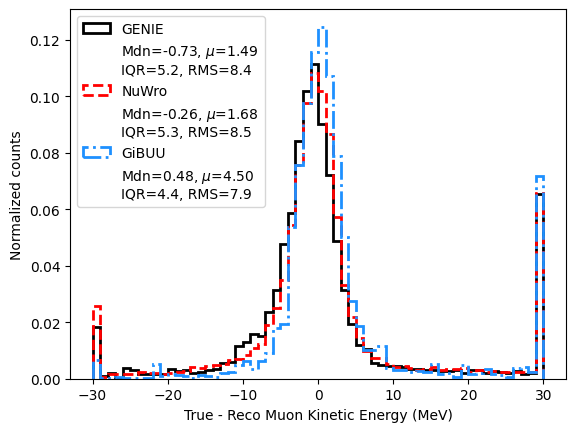

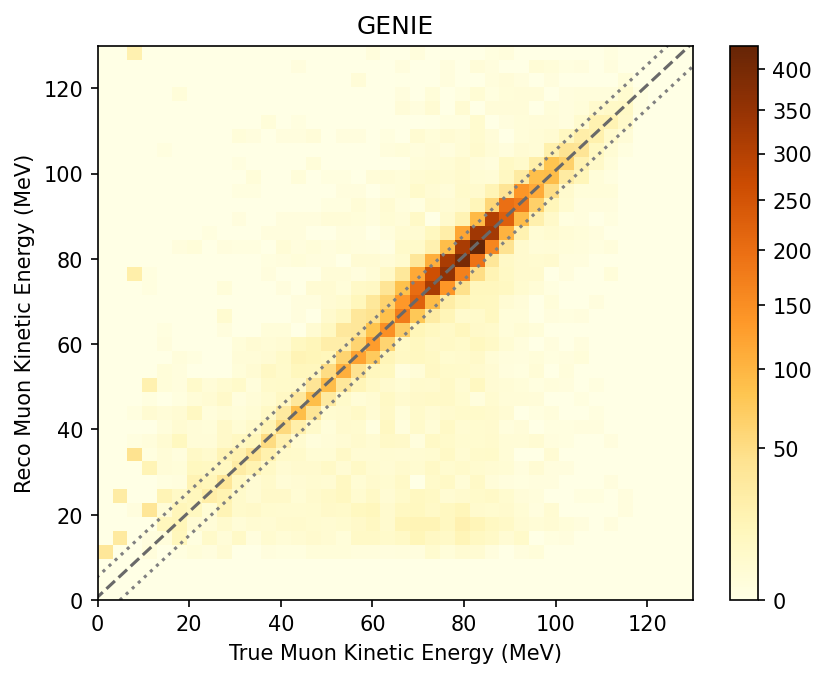

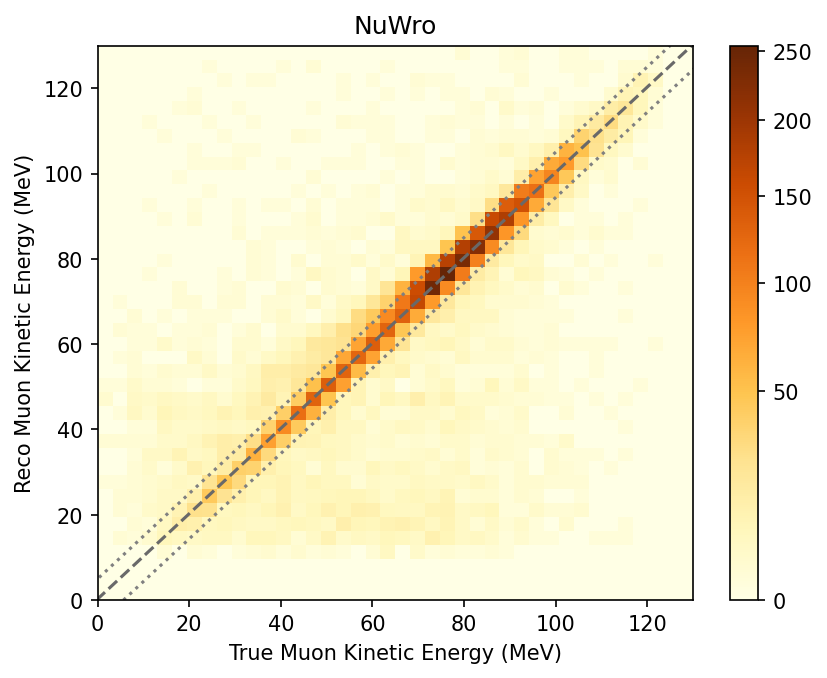

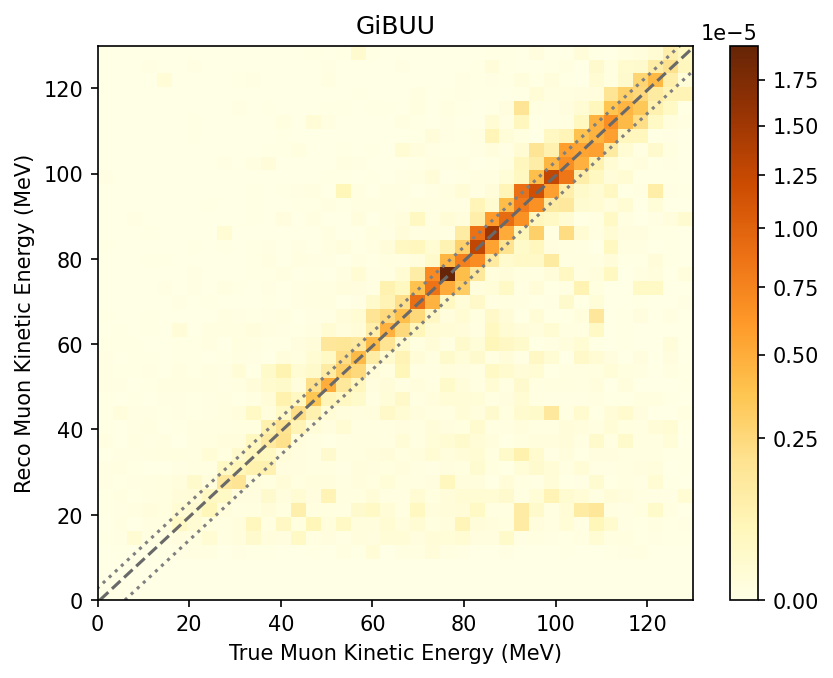

/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_12099/1993924345.py:75: RuntimeWarning: invalid value encountered in divide
  c = plt.pcolormesh(x, y, (dist).T/row_sum,cmap='YlGnBu',vmin=vmin3,vmax=vmax3)


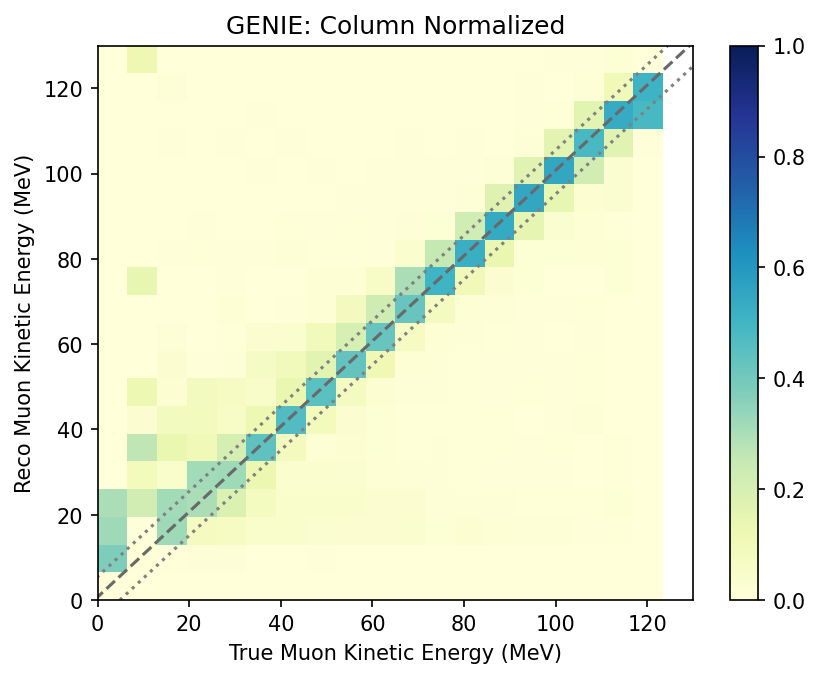

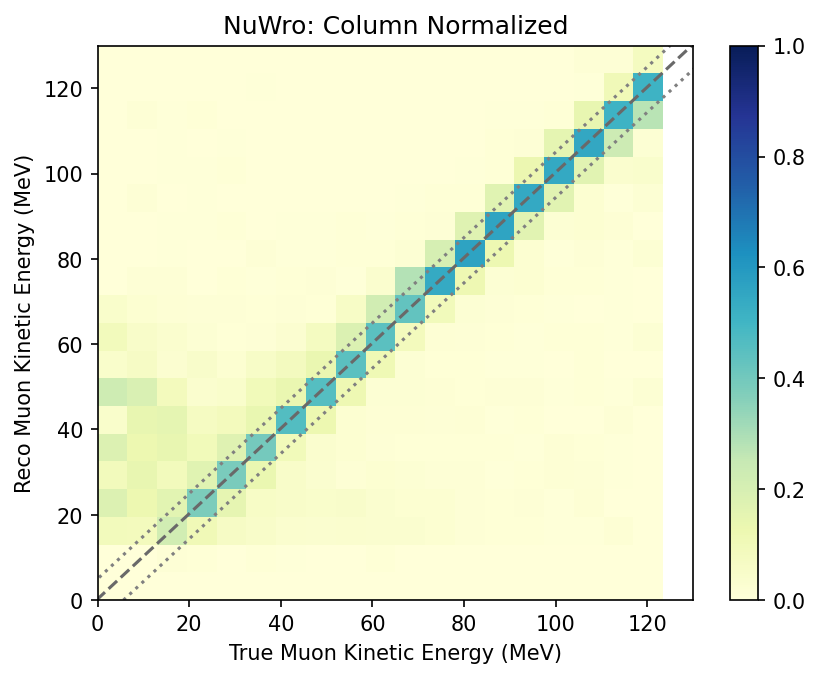

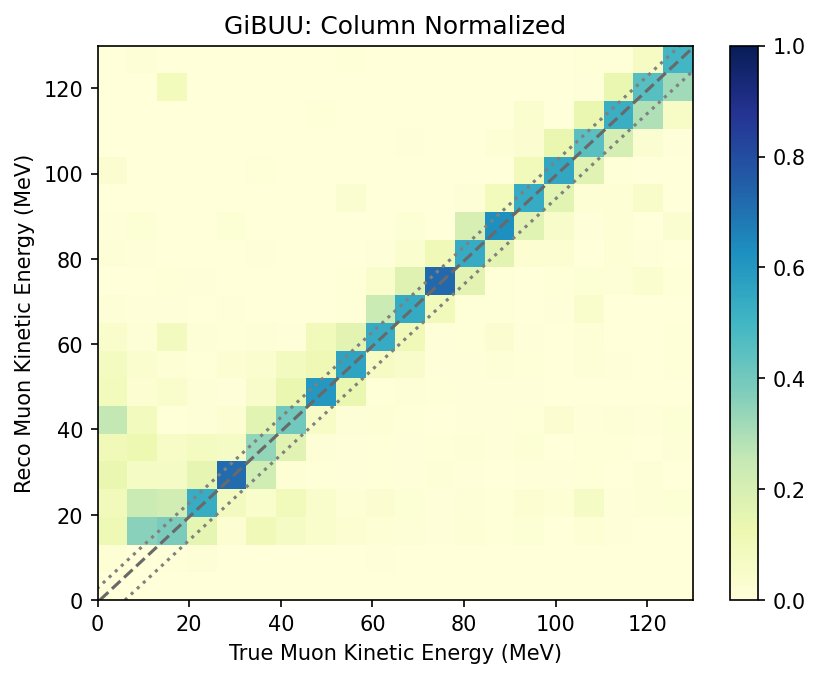

In [75]:
this_query = presel_query + "and ssm_kine_energy>0 and is_KDAR==1"
plot_res_all([kdar_overlay_df,nuwro_df,gibuu_df],this_query,"truth_Emuon","ssm_kine_energy",
                 -30,30,60,
                 0,130,40,0,130,40,0.6,
                 0,130,20,0,130,20,0,1,
                 axis_label="Muon Kinetic Energy (MeV)",
)


GENIE
mean: 13.931070145581366
median: 0.44289052800256457
std: 104.41958001098841
q1: -11.490255148021717
q3: 20.48219530084221
IQR: 15.986225224431964
FWHM: 11.742511312624764
RMS: 25.78526121138702

NuWro
mean: 16.17404306822502
median: 1.1820531243758694
std: 111.32724601746003
q1: -11.489108202782475
q3: 23.878933899590464
IQR: 17.68402105118647
FWHM: 13.249557459366844
RMS: 28.022403460854445

GiBUU
mean: 18.061488104166862
median: 1.5903202013303428
std: 114.18342335714038
q1: -7.228775555482585
q3: 20.889286721002662
IQR: 14.059031138242624
FWHM: 11.052346987674165
RMS: 27.11310022623395



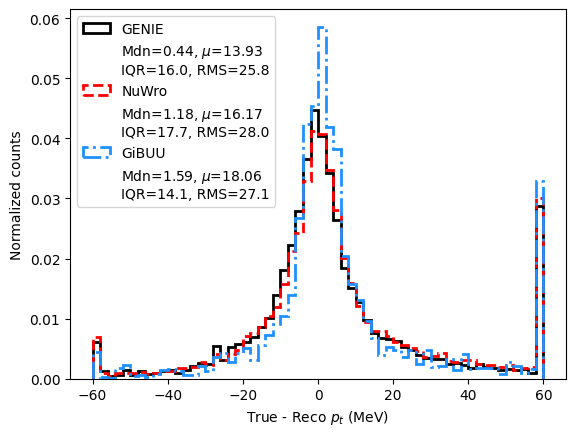

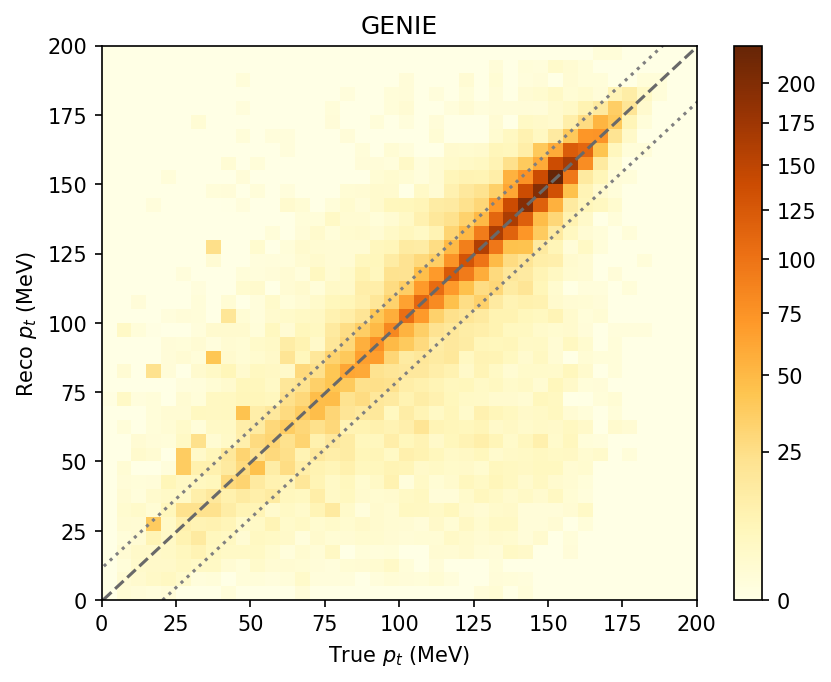

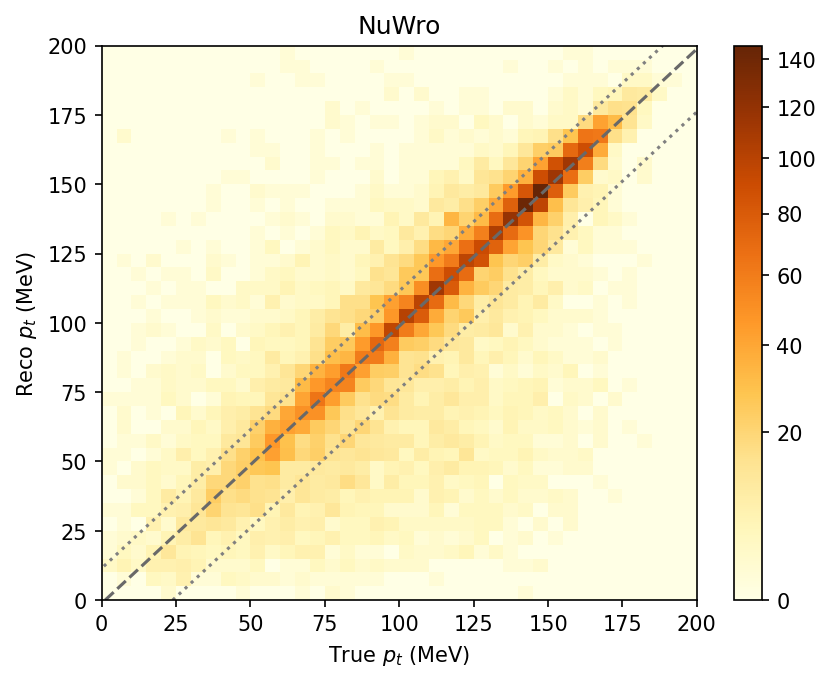

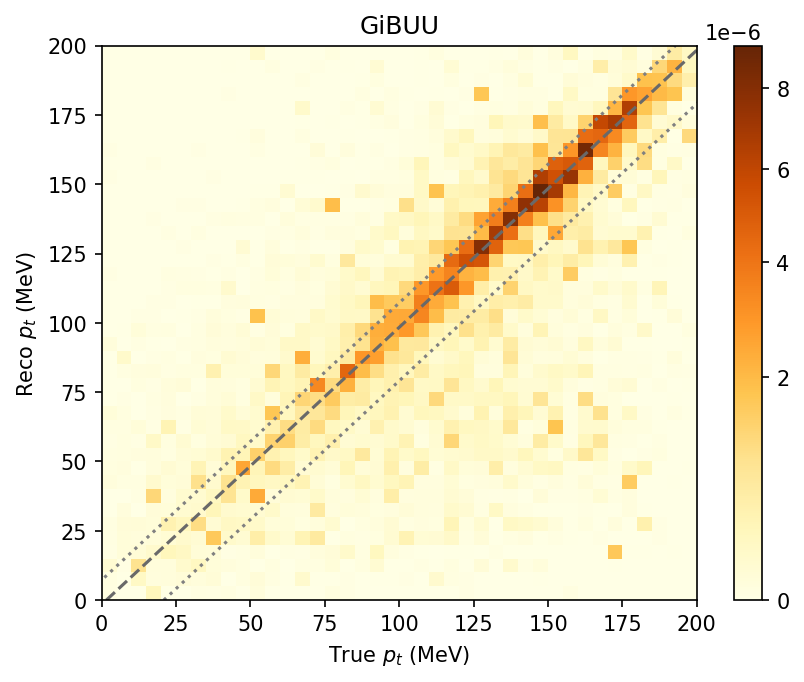

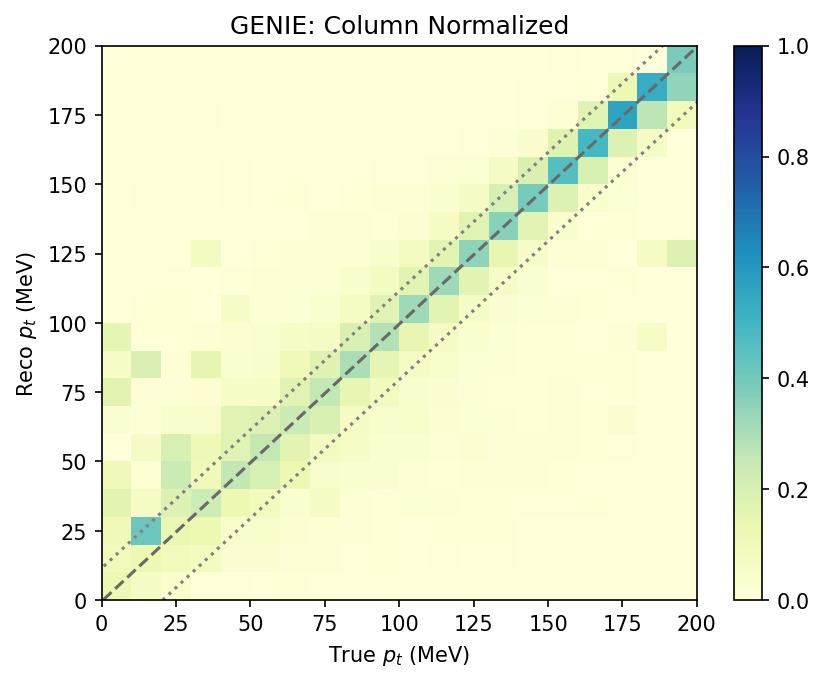

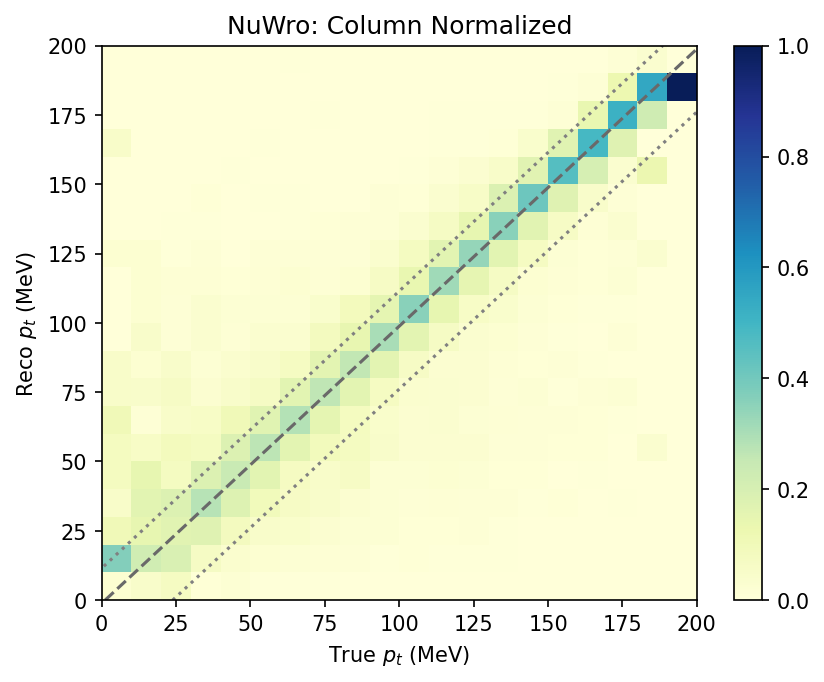

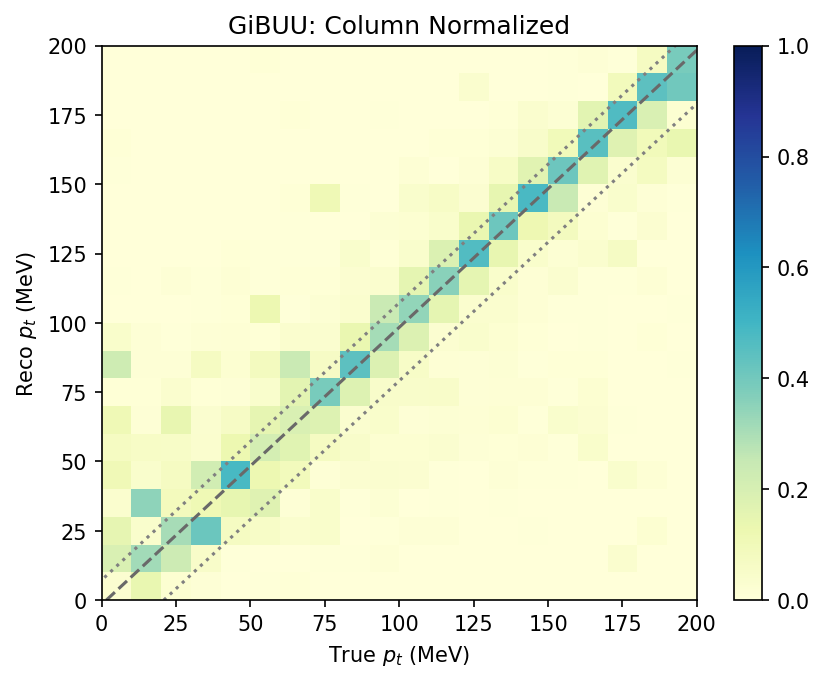

In [76]:
this_query = presel_query + "and ssm_kine_energy>0 and is_KDAR==1"
plot_res_all([kdar_overlay_df,nuwro_df,gibuu_df],this_query,"true_pt","ssm_pt",
                 -60,60,60,
                 0,200,40,0,200,40,0.6,
                 0,200,20,0,200,20,0,1,
                 axis_label=r"$p_t$ (MeV)",
)

GENIE
mean: 19.239400898990795
median: 6.3368517697494084
std: 119.70033917849737
q1: -18.32535964073371
q3: 49.85915254219955
IQR: 34.09225609146663
FWHM: 26.560091764659607
RMS: 54.1362511812967

NuWro
mean: 35.650737318172325
median: 11.096660901517453
std: 137.04498378047072
q1: -12.877707792419105
q3: 89.2701164911607
IQR: 51.073912141789904
FWHM: 45.097087090887406
RMS: 67.17665206897234

GiBUU
mean: 24.9583474820019
median: 2.986136665622169
std: 141.62740648012144
q1: -22.704124842726756
q3: 89.82569939072641
IQR: 56.264912116726585
FWHM: 46.325299664188
RMS: 69.92368619240683



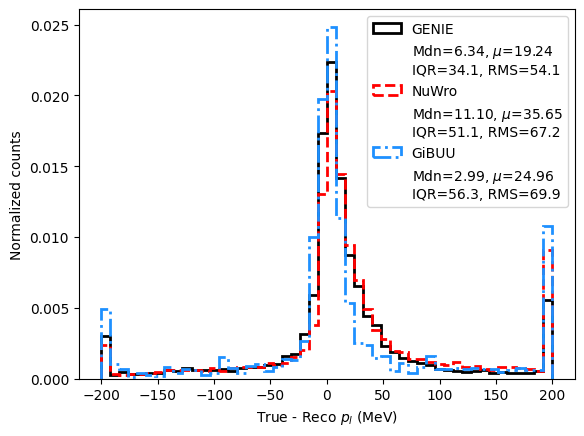

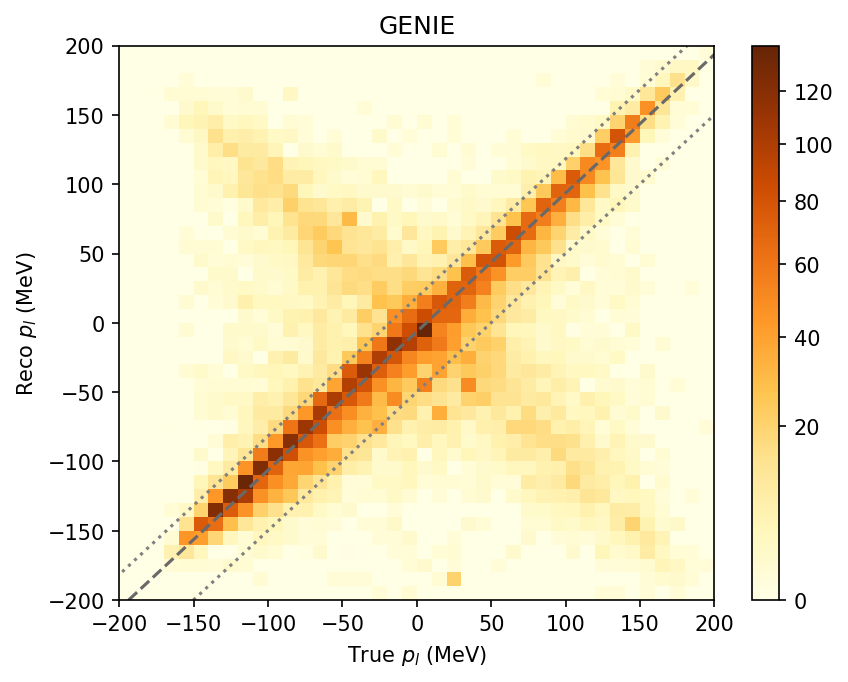

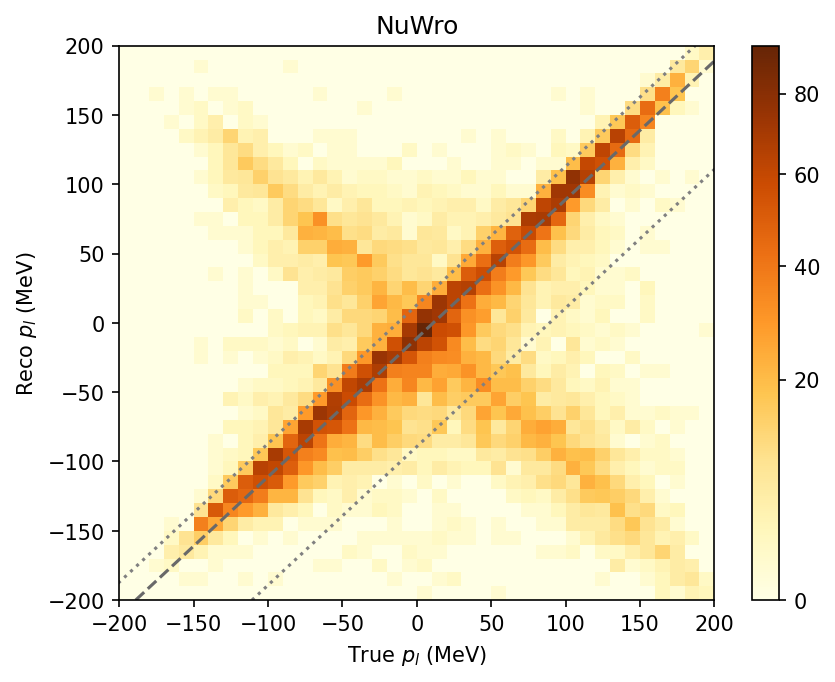

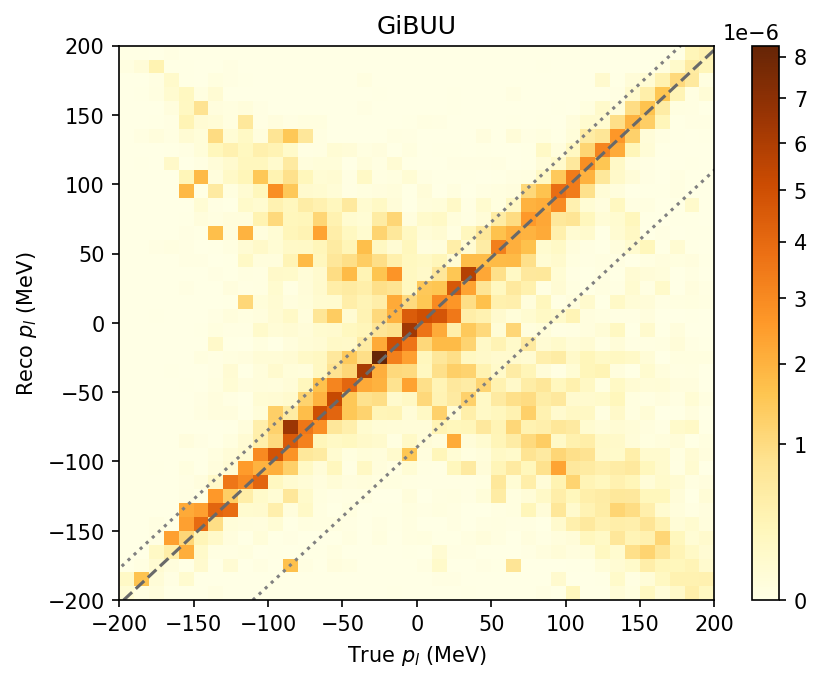

/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_12099/1993924345.py:75: RuntimeWarning: invalid value encountered in divide
  c = plt.pcolormesh(x, y, (dist).T/row_sum,cmap='YlGnBu',vmin=vmin3,vmax=vmax3)


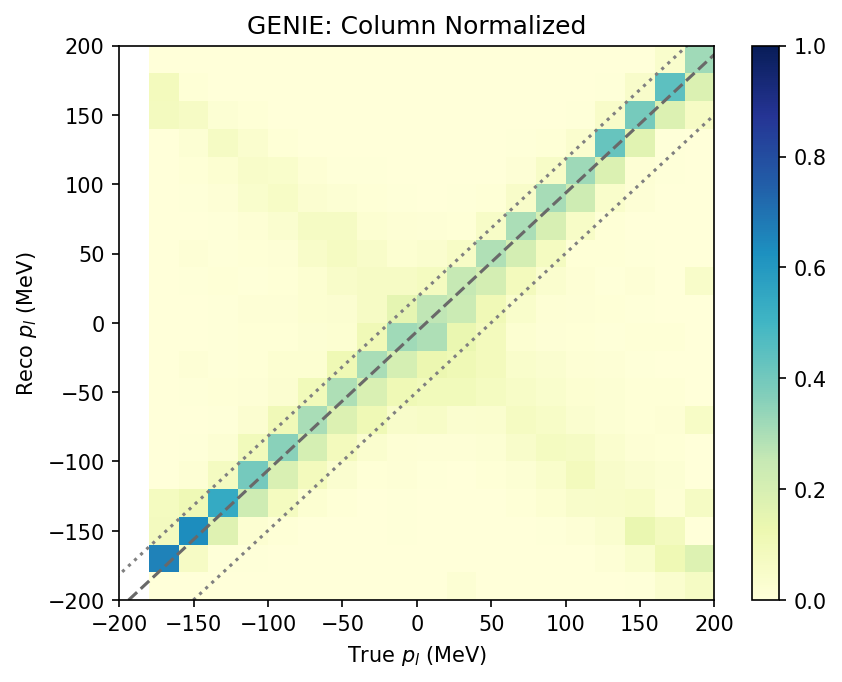

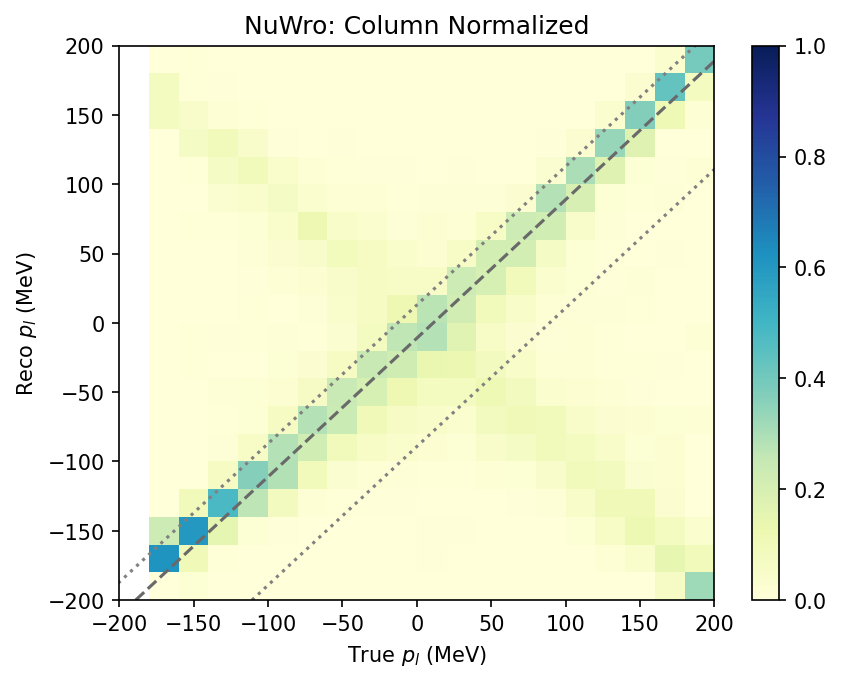

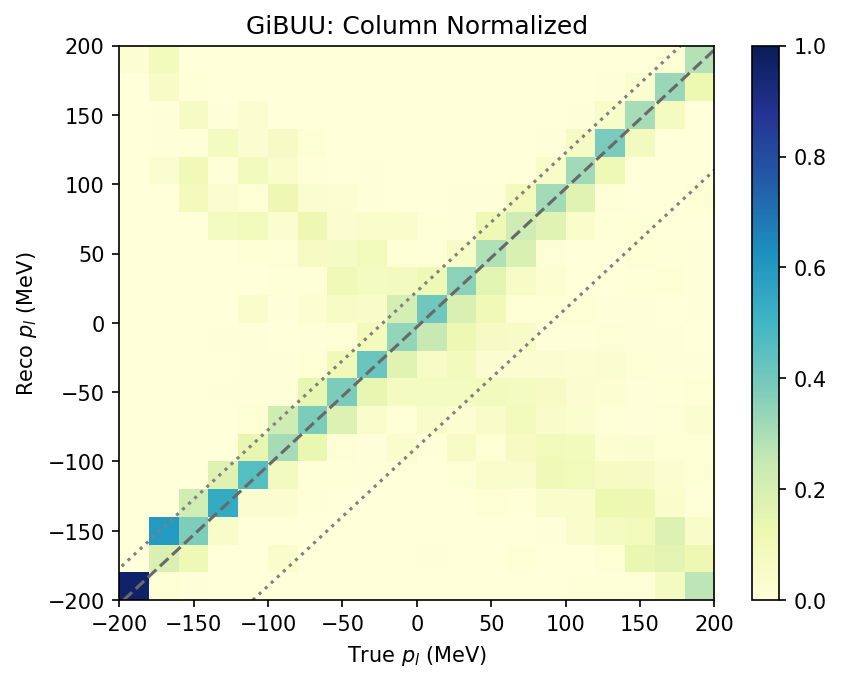

In [77]:
this_query = presel_query + "and ssm_kine_energy>0 and is_KDAR==1"
plot_res_all([kdar_overlay_df,nuwro_df,gibuu_df],this_query,"true_pl","ssm_pl",
                 -200,200,50,
                 -200,200,40,-200,200,40,0.6,
                 -200,200,20,-200,200,20,0,1,
                 axis_label=r"$p_l$ (MeV)",
)

GENIE
mean: 4.314706148481283
median: -5.199412595638336
std: 146.6640151486305
q1: -40.87383297729593
q3: 21.462494883970578
IQR: 31.168163930633256
FWHM: 23.083050648150625
RMS: 53.63378719491307

NuWro
mean: -7.282310572817557
median: -9.356875336564656
std: 155.2267845814442
q1: -71.24076767130907
q3: 20.019301620147814
IQR: 45.63003464572844
FWHM: 37.00006559371175
RMS: 64.87819036807986

GiBUU
mean: 4.366785421132835
median: -1.3339359343148942
std: 166.00554229012505
q1: -53.893279247483235
q3: 35.79996648832787
IQR: 44.84662286790555
FWHM: 32.35012808557566
RMS: 66.4872364132866



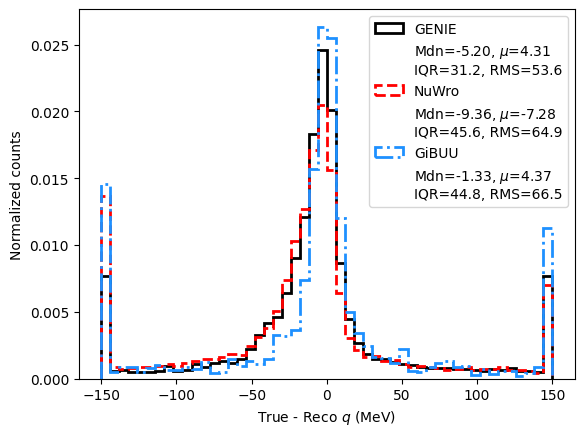

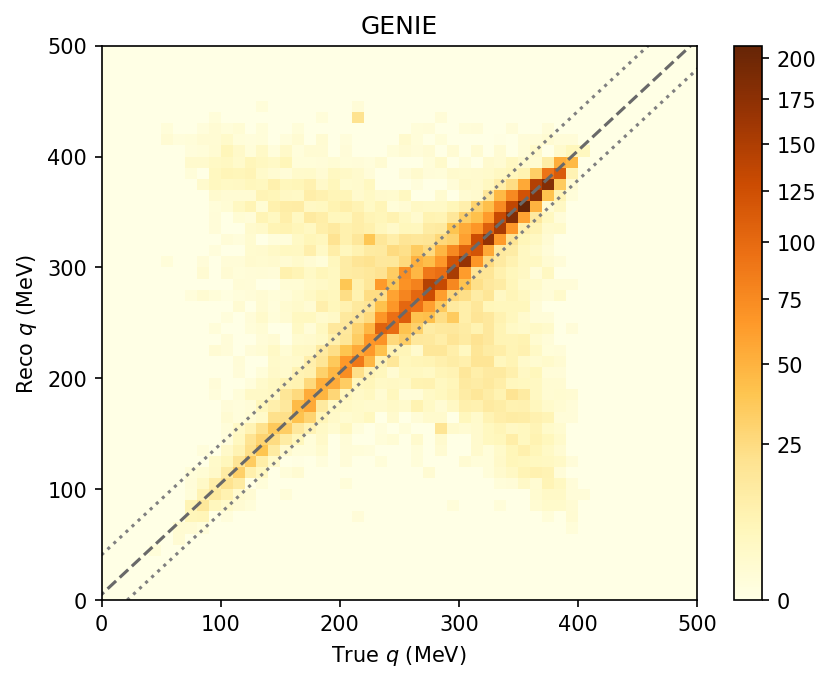

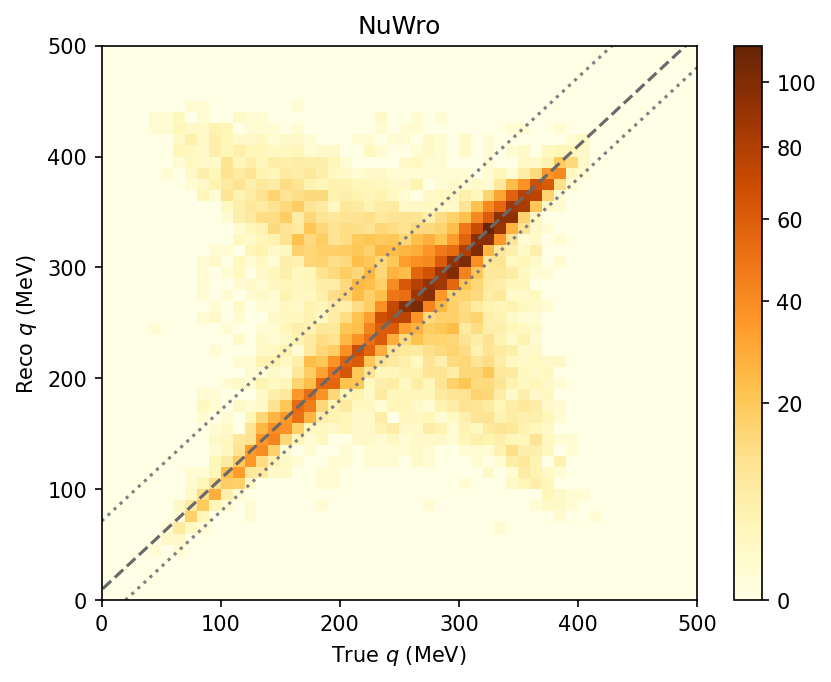

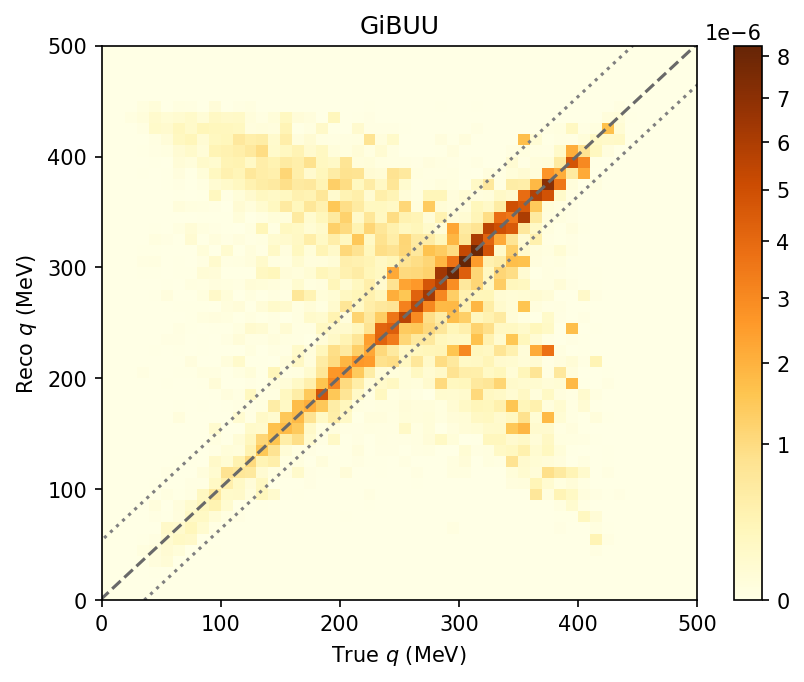

/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_12099/1993924345.py:75: RuntimeWarning: invalid value encountered in divide
  c = plt.pcolormesh(x, y, (dist).T/row_sum,cmap='YlGnBu',vmin=vmin3,vmax=vmax3)


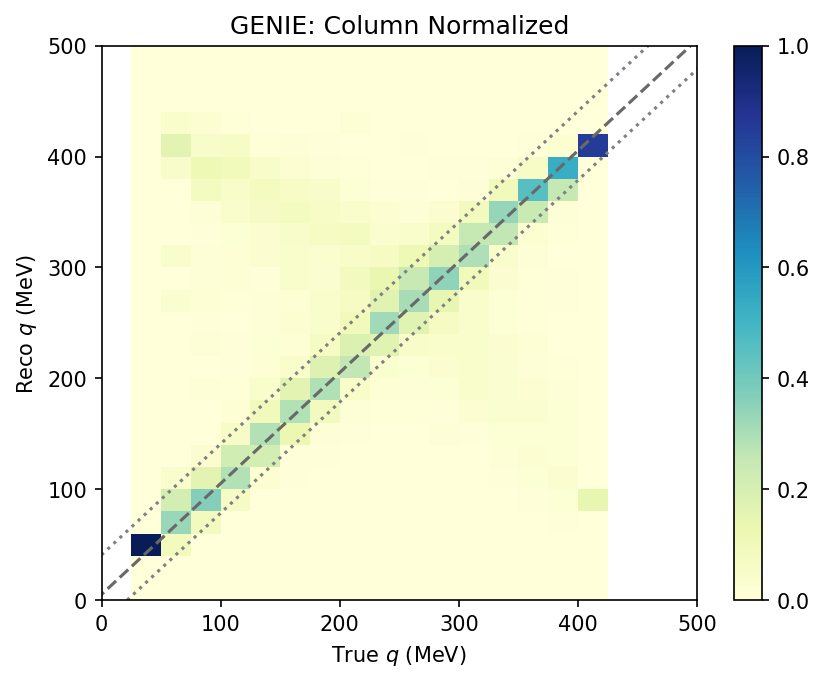

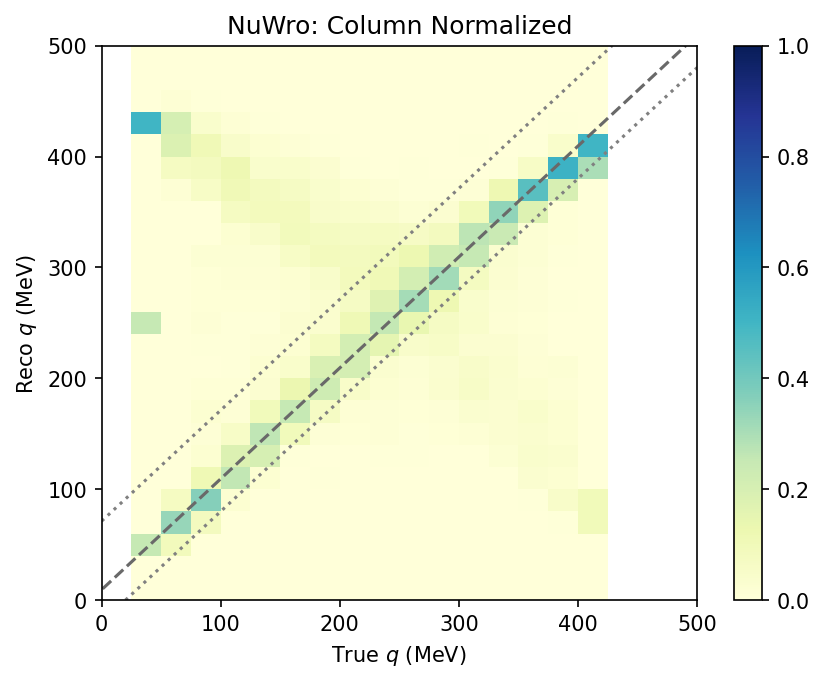

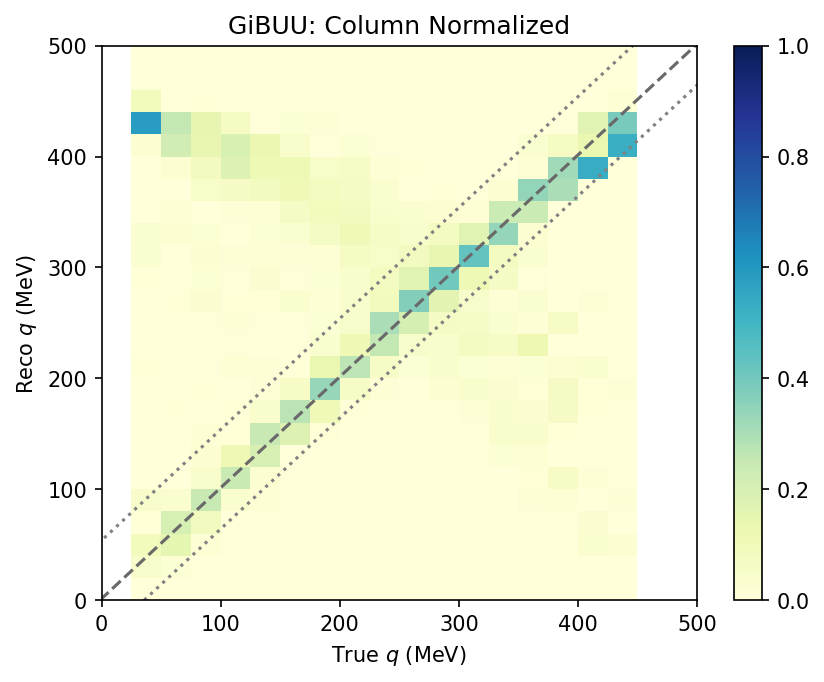

In [78]:
this_query = presel_query + "and ssm_kine_energy>0 and is_KDAR==1"
plot_res_all([kdar_overlay_df,nuwro_df,gibuu_df],this_query,"true_q","ssm_q",
                 -150,150,50,
                 0,500,50,0,500,50,0.6,
                 0,500,20,0,500,25,0,1,
                 axis_label=r"$q$ (MeV)",
)

GENIE
mean: 4.7918403132377
median: -5.443433598456863
std: 147.63225863089409
q1: -42.08538181068968
q3: 24.75434195848564
IQR: 33.41986188458766
FWHM: 24.41289007854853
RMS: 55.74027543285283

NuWro
mean: -7.14266603578786
median: -9.494639627810443
std: 155.97534615322039
q1: -73.71621516957512
q3: 23.659849816540714
IQR: 48.68803249305792
FWHM: 38.71004027467667
RMS: 67.17942459423965

GiBUU
mean: 5.676581254805471
median: -0.9627181834270289
std: 166.57121810176332
q1: -54.854143808364825
q3: 41.49301160923574
IQR: 48.17357770880028
FWHM: 34.38984990281631
RMS: 67.75456083117716



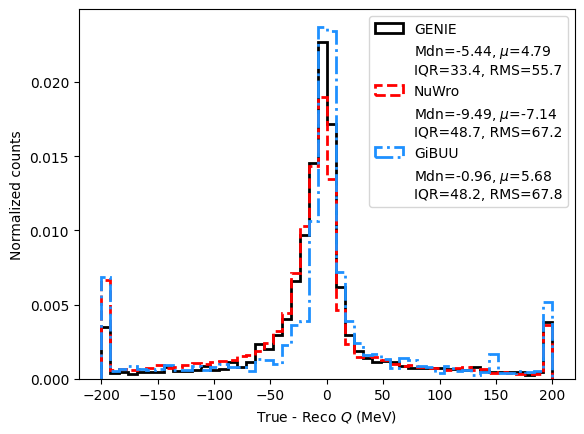

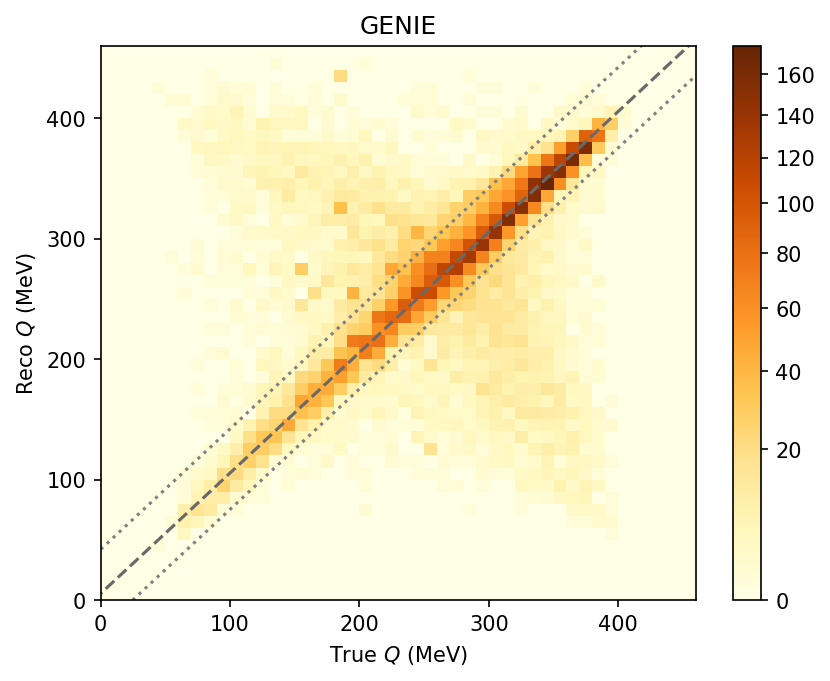

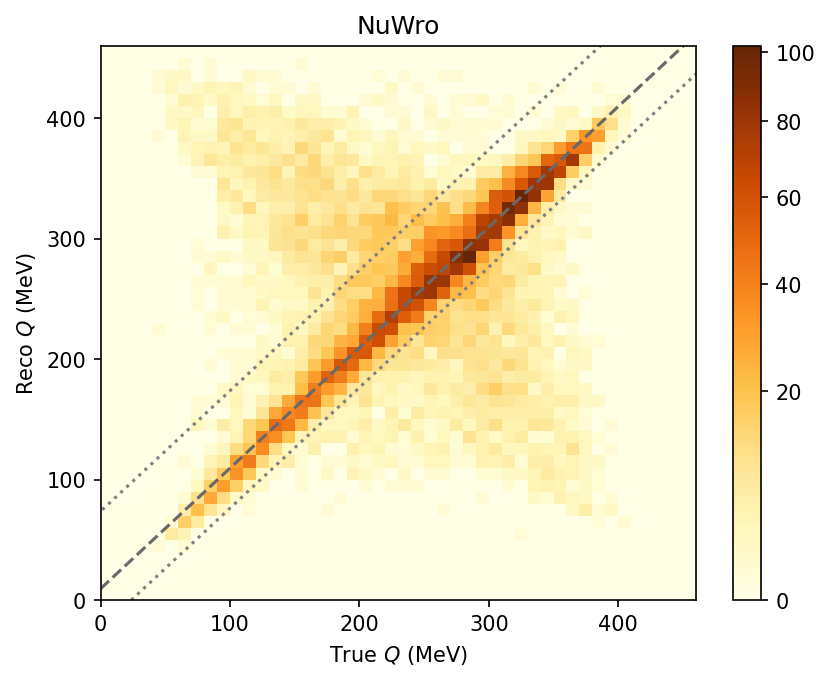

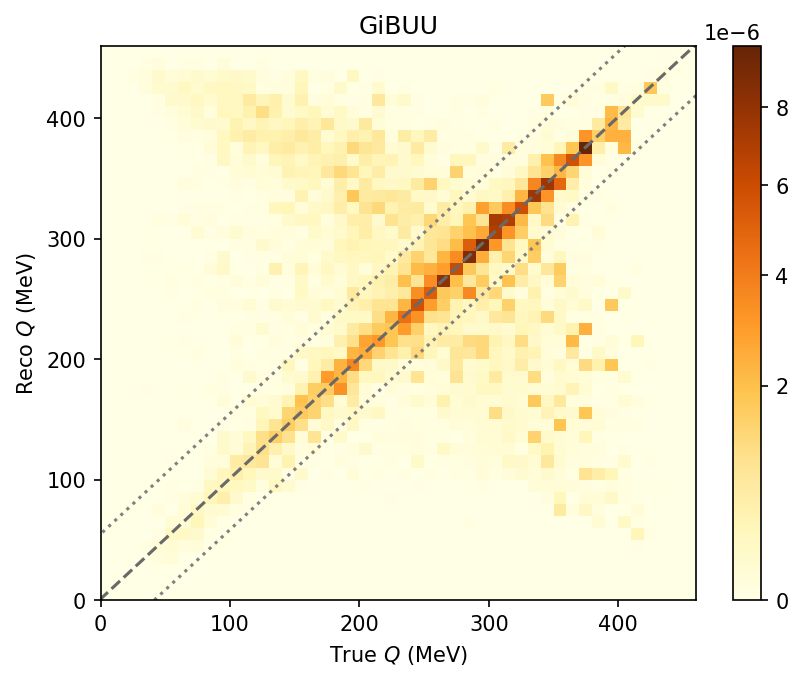

/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_12099/1993924345.py:75: RuntimeWarning: invalid value encountered in divide
  c = plt.pcolormesh(x, y, (dist).T/row_sum,cmap='YlGnBu',vmin=vmin3,vmax=vmax3)


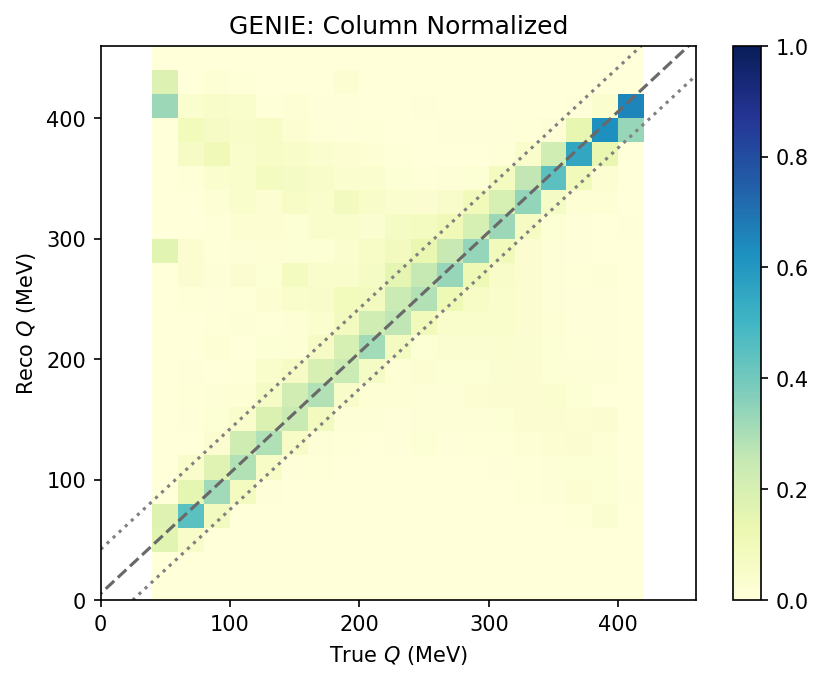

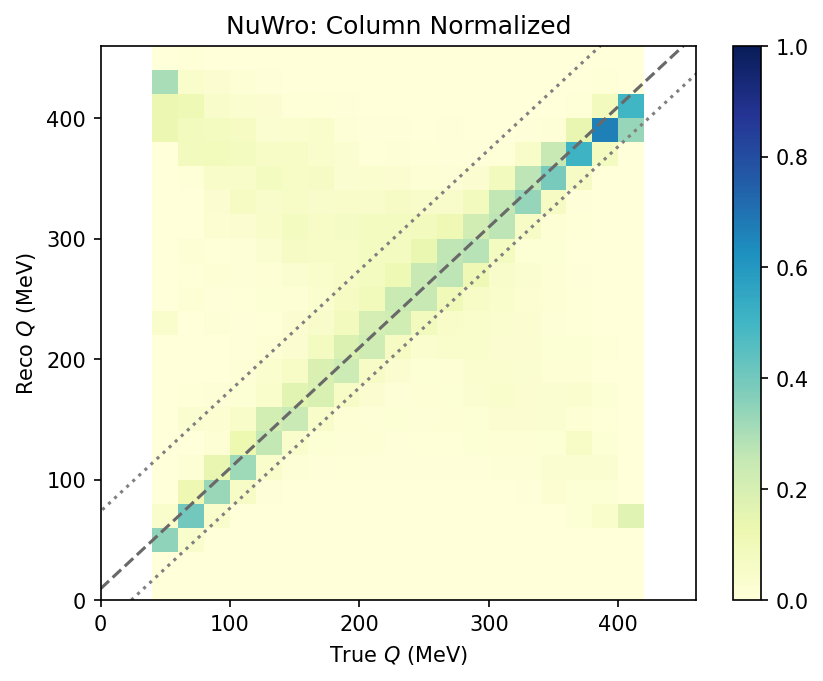

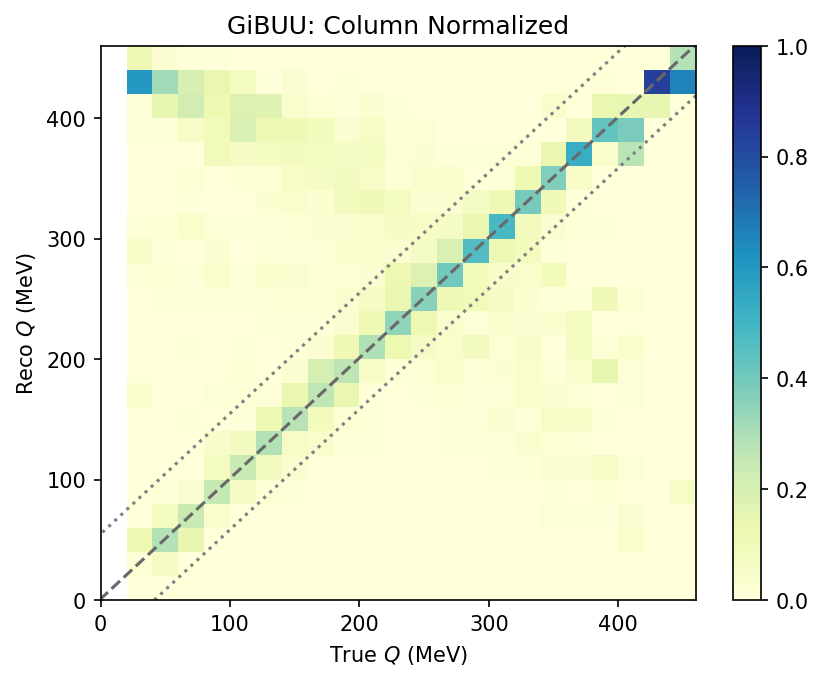

In [79]:
this_query = presel_query + "and ssm_kine_energy>0 and is_KDAR==1"
plot_res_all([kdar_overlay_df,nuwro_df,gibuu_df],this_query,"true_sqrtQ2","ssm_sqrtQ2",
                 -200,200,50,
                 0,460,46,0,460,46,0.6,
                 0,460,23,0,460,23,0,1,
                 axis_label=r"$Q$ (MeV)",
)

GENIE
mean: -4.648907660832145
median: -2.984970823821044
std: 38.95512844866662
q1: -22.978538801906737
q3: 8.906498035093136
IQR: 15.942518418499937
FWHM: 12.32212393136682
RMS: 22.564116329808883

NuWro
mean: -11.018901362249881
median: -4.974944583528924
std: 44.94861590667399
q1: -43.33338938415331
q3: 7.008564875787481
IQR: 25.170977129970396
FWHM: 21.948249458309725
RMS: 28.45507679633928

GiBUU
mean: -5.218100056947345
median: -1.0867447056067618
std: 43.26071273639854
q1: -35.49853354549418
q3: 10.358914232445898
IQR: 22.92872388897004
FWHM: 18.48954426125578
RMS: 25.208356685495634



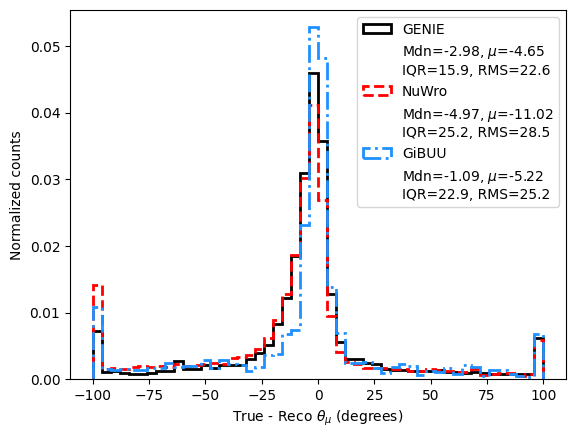

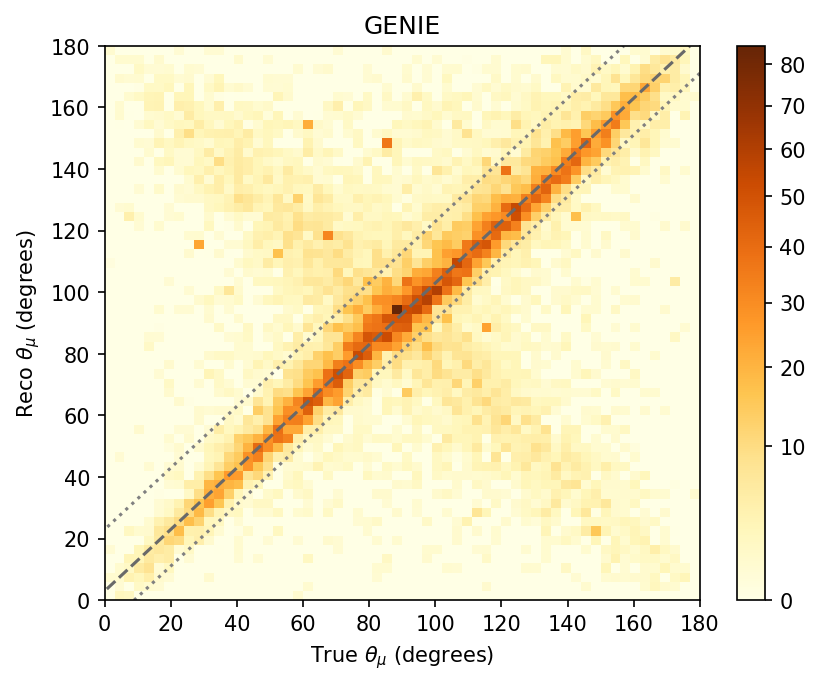

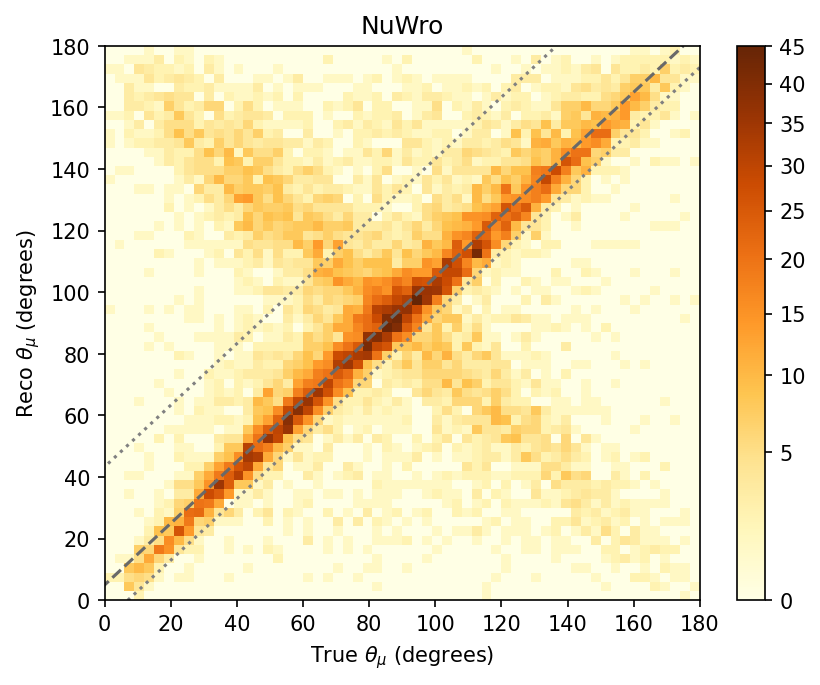

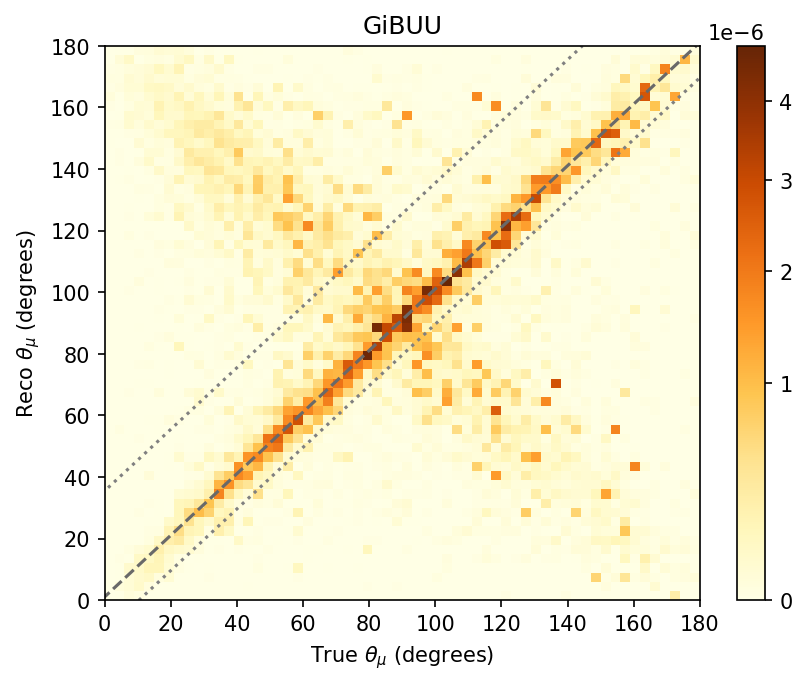

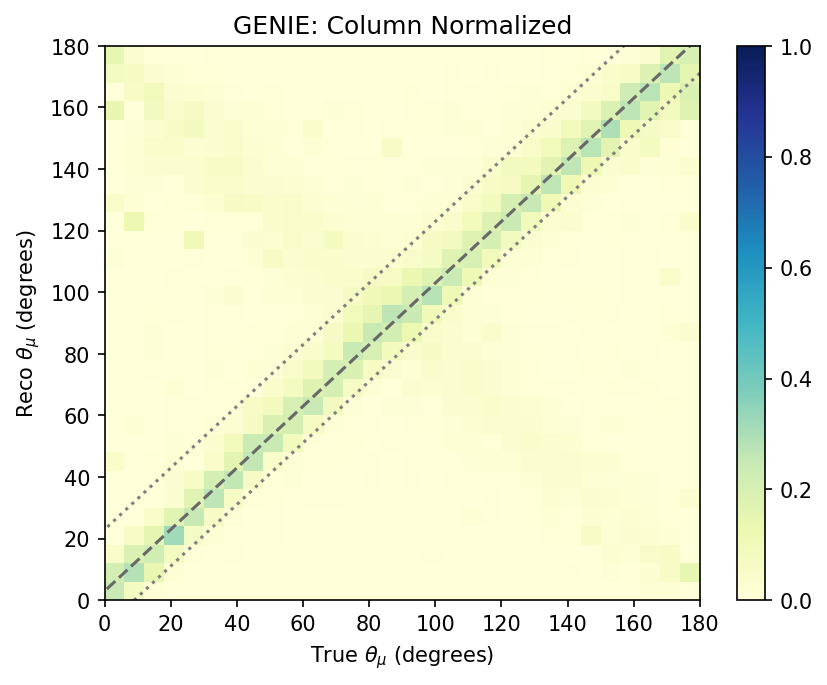

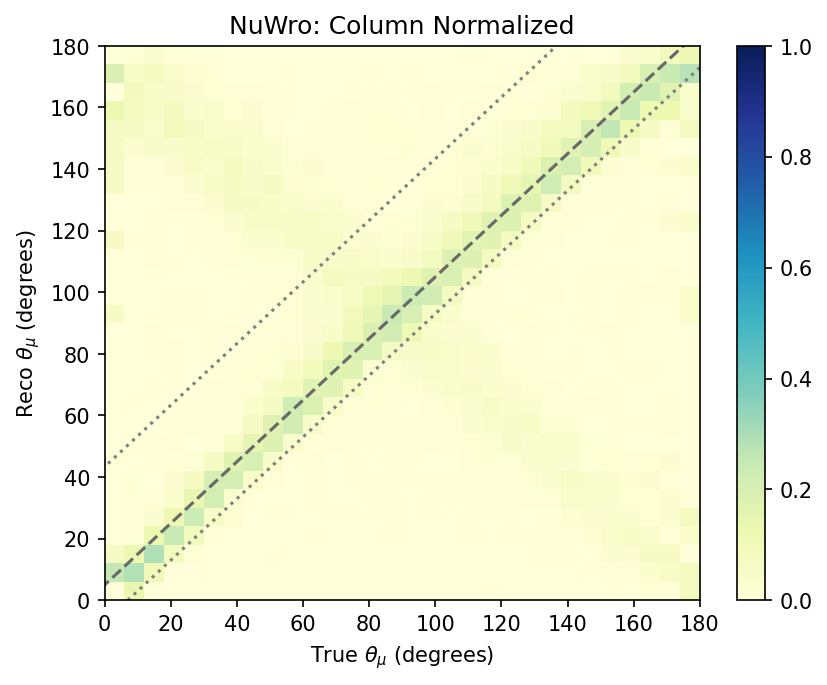

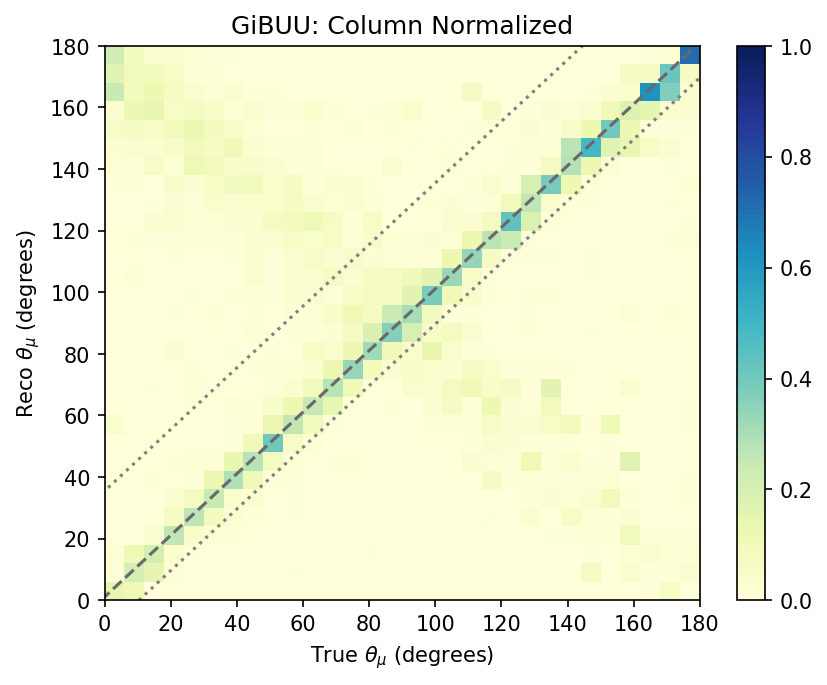

In [80]:
this_query = presel_query + "and ssm_kine_energy>0 and is_KDAR==1 and ssm_angle_to_absorber_deg>0 and ssm_angle_to_absorber_deg<180"
plot_res_all([kdar_overlay_df,nuwro_df,gibuu_df],this_query,"true_angle_deg","ssm_angle_to_absorber_deg",
                 -100,100,50,
                 0,180,60,0,180,60,0.6,
                 0,180,30,0,180,30,0,1,
                 axis_label=r"$\theta_\mu$ (degrees)",
)

GENIE
mean: 4.520410131031565
median: 6.044632270812997
std: 22.737114394967186
q1: -11.016738578796382
q3: 20.030294254302987
IQR: 15.523516416549684
FWHM: 11.430017681826916
RMS: 15.958527620780908

NuWro
mean: 3.155521863130226
median: 5.370124176025399
std: 26.155057202653282
q1: -14.096946403503413
q3: 22.622100189208993
IQR: 18.3595232963562
FWHM: 13.327446444029116
RMS: 18.237605101358962

GiBUU
mean: -2.0197327930420257
median: 6.879267051696782
std: 26.51603907048217
q1: -18.85337702941894
q3: 13.719968631744393
IQR: 16.286672830581665
FWHM: 11.658552275791706
RMS: 17.560703448350264



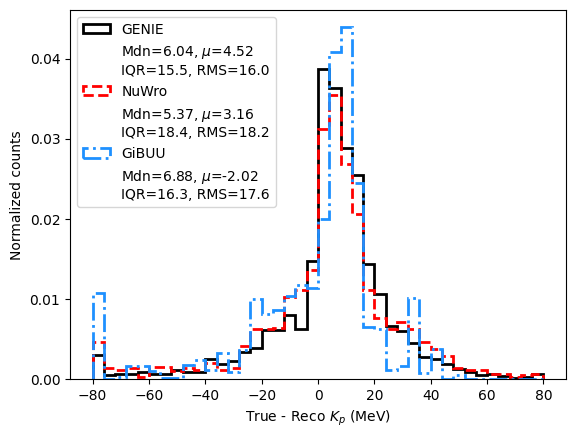

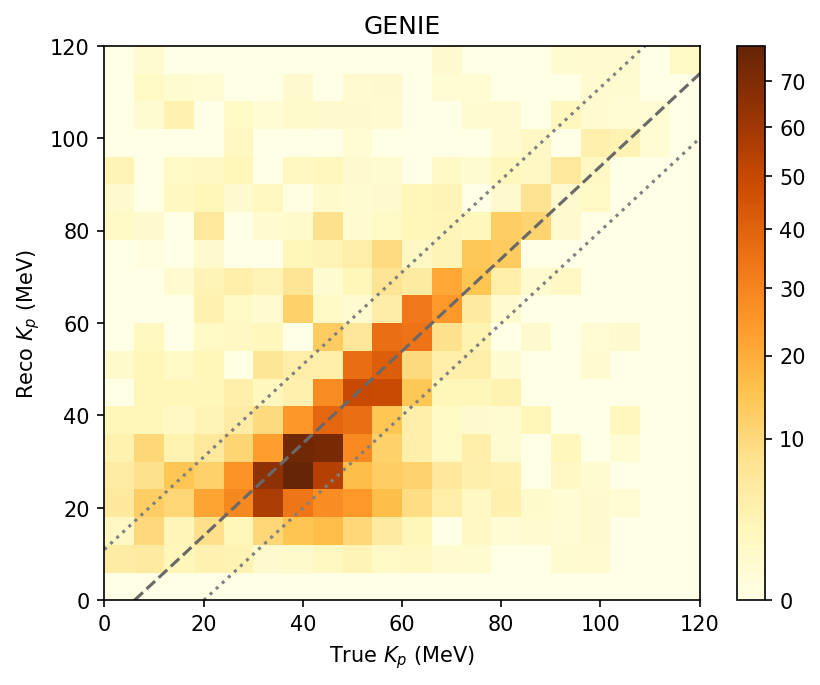

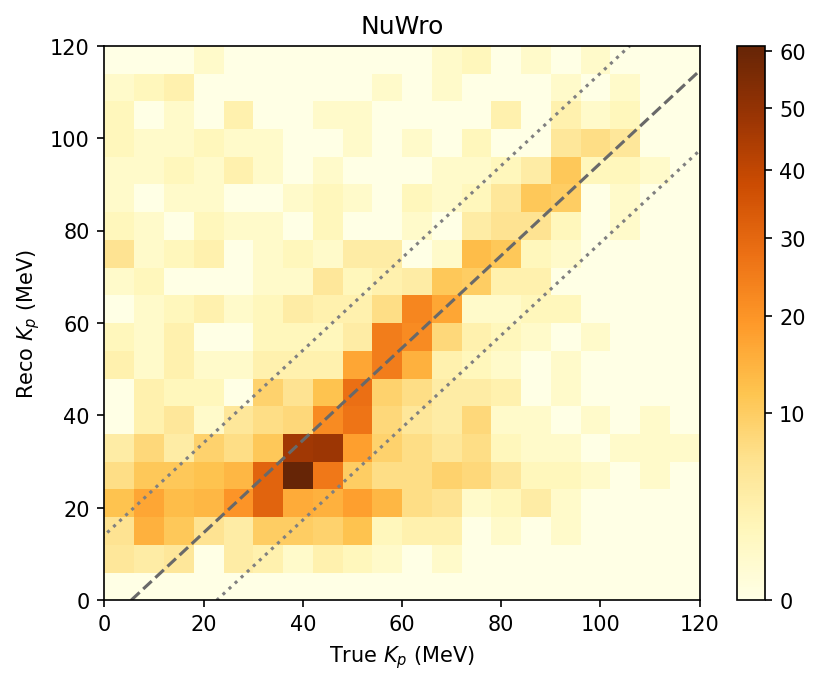

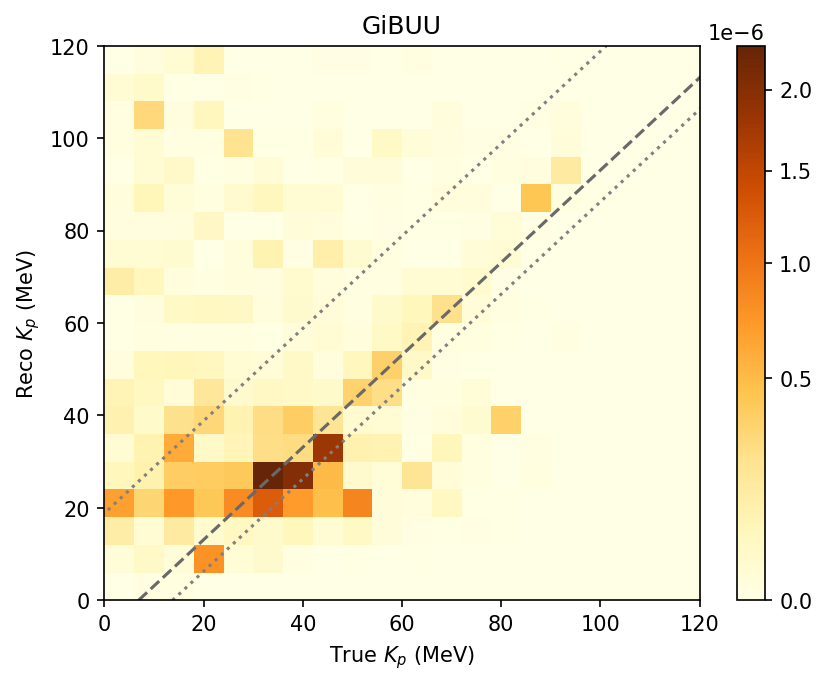

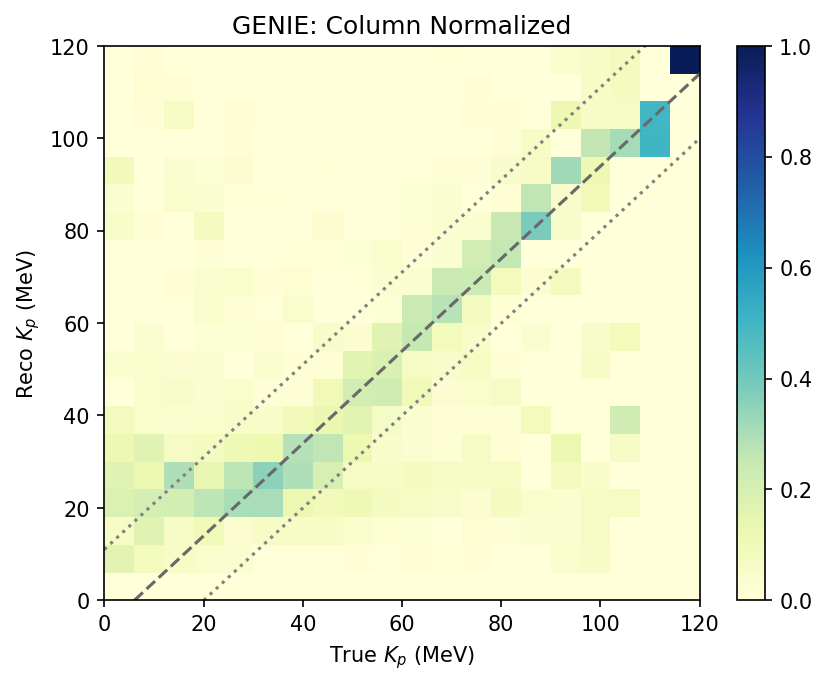

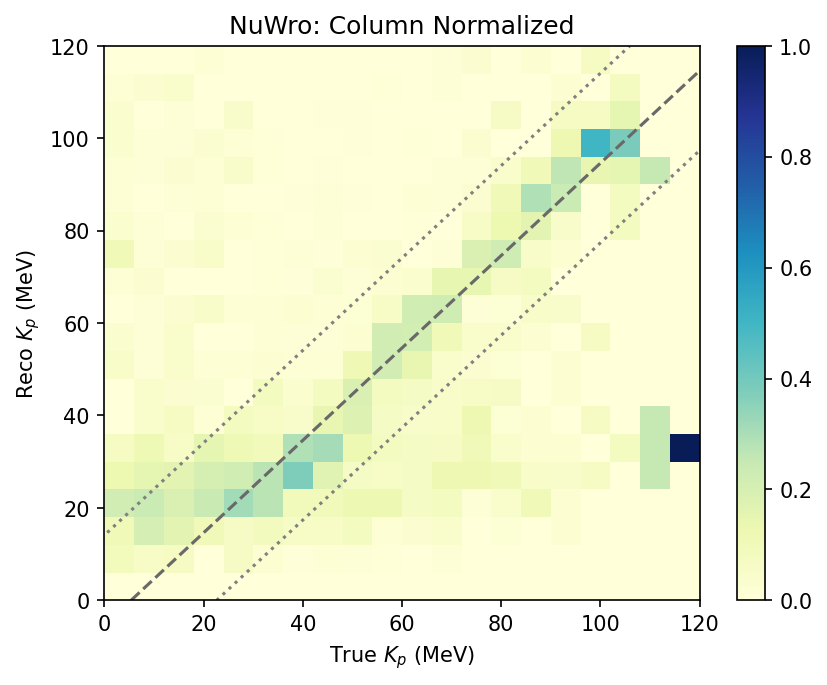

/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_12099/1993924345.py:75: RuntimeWarning: invalid value encountered in divide
  c = plt.pcolormesh(x, y, (dist).T/row_sum,cmap='YlGnBu',vmin=vmin3,vmax=vmax3)


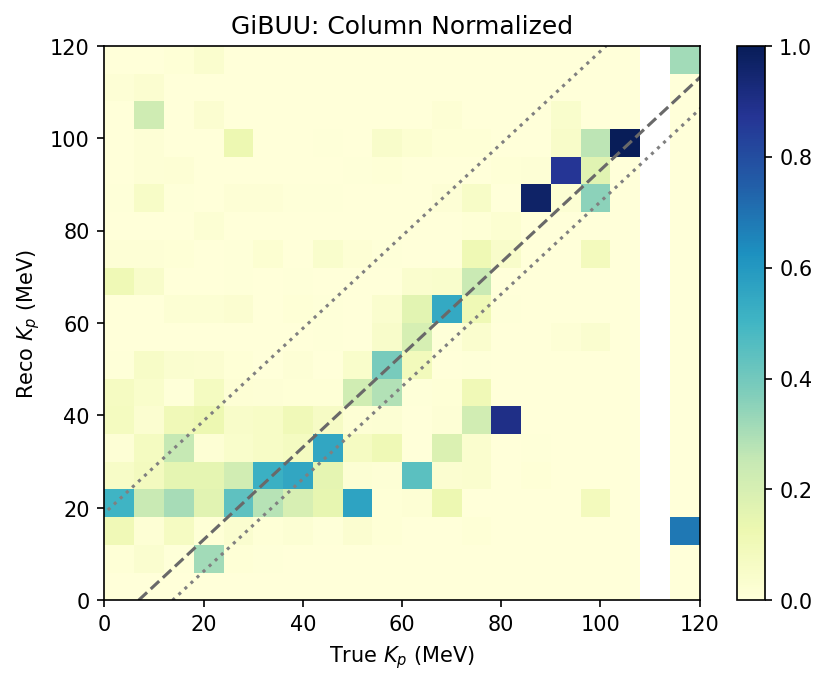

In [81]:
this_query = presel_query + "and ssm_kine_energy>0 and is_KDAR==1 and truth_prim_p_energy>0 and ssm_prim_track1_kine_energy_range>0"
plot_res_all([kdar_overlay_df,nuwro_df,gibuu_df],this_query,"truth_prim_p_energy","ssm_prim_track1_kine_energy_range",
                 -80,80,40,
                 0,120,20,0,120,20,0.6,
                 0,120,20,0,120,20,0,1,
                 axis_label=r"$K_p$ (MeV)",
)

GENIE
mean: -5.324287172851156
median: 3.9216526298523
std: 35.033039304877036
q1: -22.60740296554565
q3: 14.426976516723641
IQR: 18.517189741134644
FWHM: 13.409253523785894
RMS: 19.625691974867024

NuWro
mean: -10.041139287858027
median: 3.080086544036874
std: 39.634472258494355
q1: -32.64263980102538
q3: 13.290206745147714
IQR: 22.966423273086548
FWHM: 17.622226934387836
RMS: 22.982533792021556

GiBUU
mean: -15.115877479566814
median: 1.567214324951177
std: 46.86456962090249
q1: -34.25402085494994
q3: 10.819694831848153
IQR: 22.536857843399048
FWHM: 17.961095045860006
RMS: 24.650011846673358



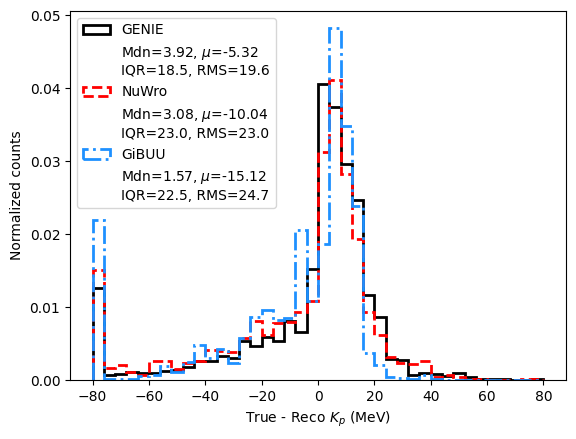

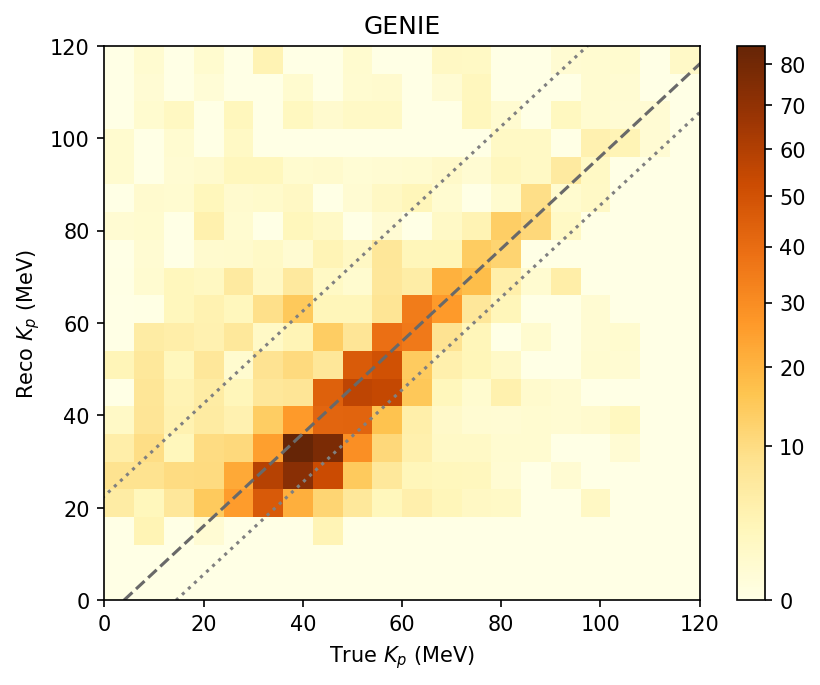

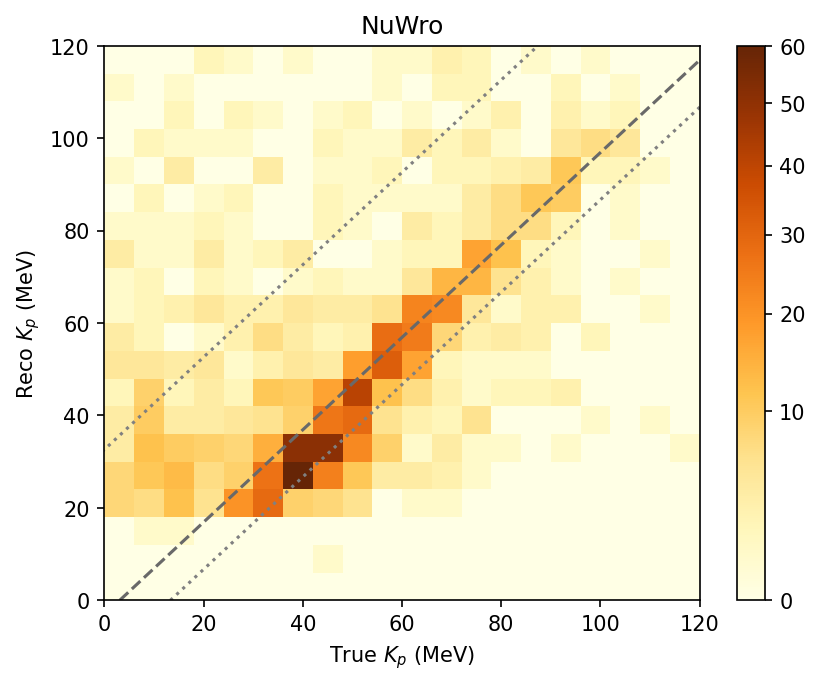

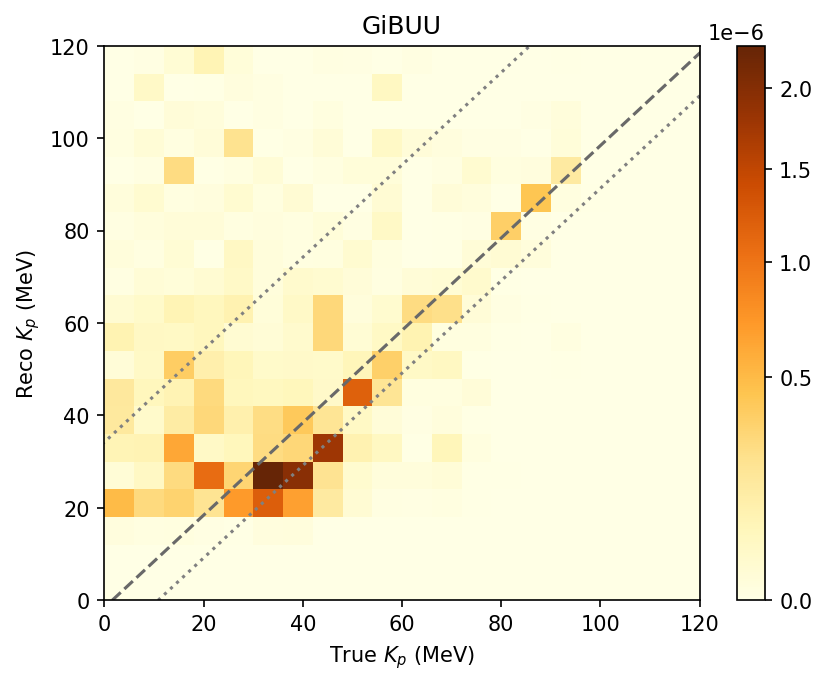

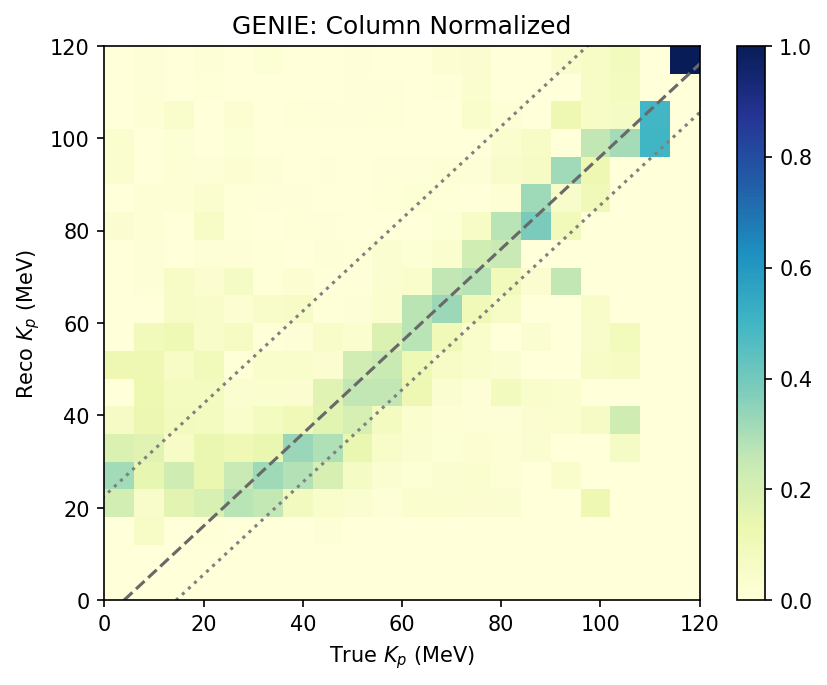

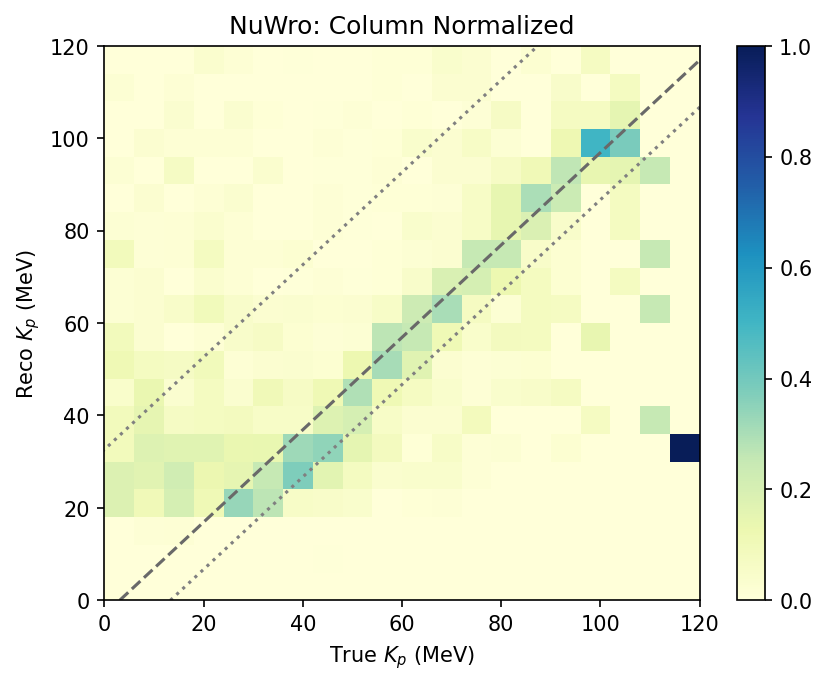

/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_12099/1993924345.py:75: RuntimeWarning: invalid value encountered in divide
  c = plt.pcolormesh(x, y, (dist).T/row_sum,cmap='YlGnBu',vmin=vmin3,vmax=vmax3)


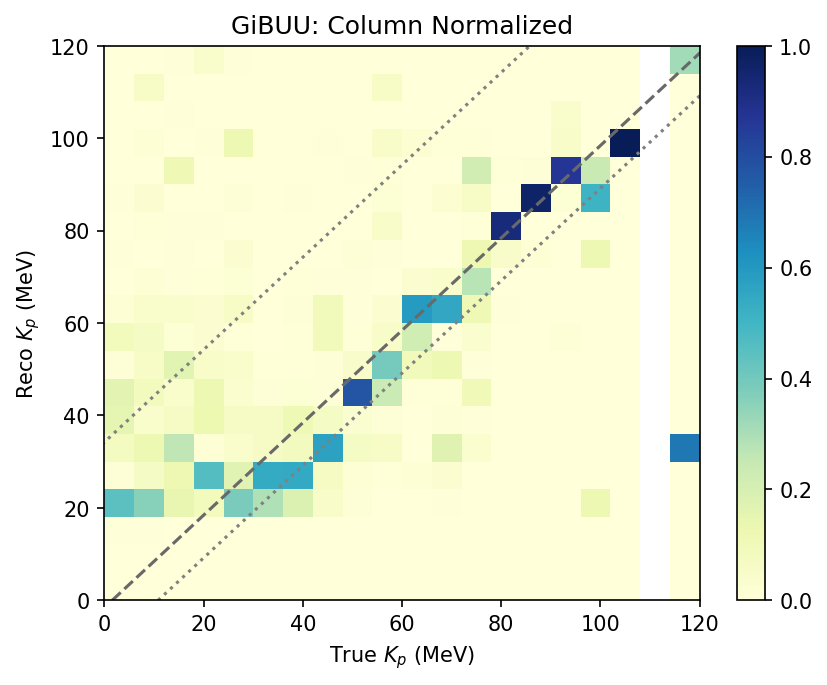

In [82]:
this_query = presel_query + "and ssm_kine_energy>0 and is_KDAR==1 and truth_prim_p_energy>0 and ssm_prim_track1_kine_energy_range>0"
plot_res_all([kdar_overlay_df,nuwro_df,gibuu_df],this_query,"truth_prim_p_energy","ssm_prim_track1_kine_energy_range_p",
                 -80,80,40,
                 0,120,20,0,120,20,0.6,
                 0,120,20,0,120,20,0,1,
                 axis_label=r"$K_p$ (MeV)",
)


GENIE
mean: 18.930258839367948
median: 18.935836151123052
std: 20.981200571421315
q1: 3.5563867835998586
q3: 36.15663178253175
IQR: 16.300122499465942
FWHM: 18.16555744267258
RMS: 22.950439310922896

NuWro
mean: 19.296464498862882
median: 18.52612479019166
std: 23.82002517290679
q1: 1.6535352020263758
q3: 40.122996643066415
IQR: 19.23473072052002
FWHM: 20.078527325751875
RMS: 24.52559206008046

GiBUU
mean: 13.986665257937428
median: 17.631845787048345
std: 23.941299720959805
q1: 0.8499944953918508
q3: 32.45555408287049
IQR: 15.80277979373932
FWHM: 16.233341318628213
RMS: 22.407372307880273



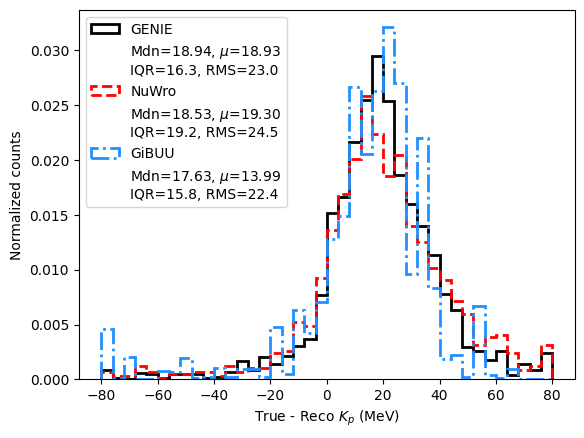

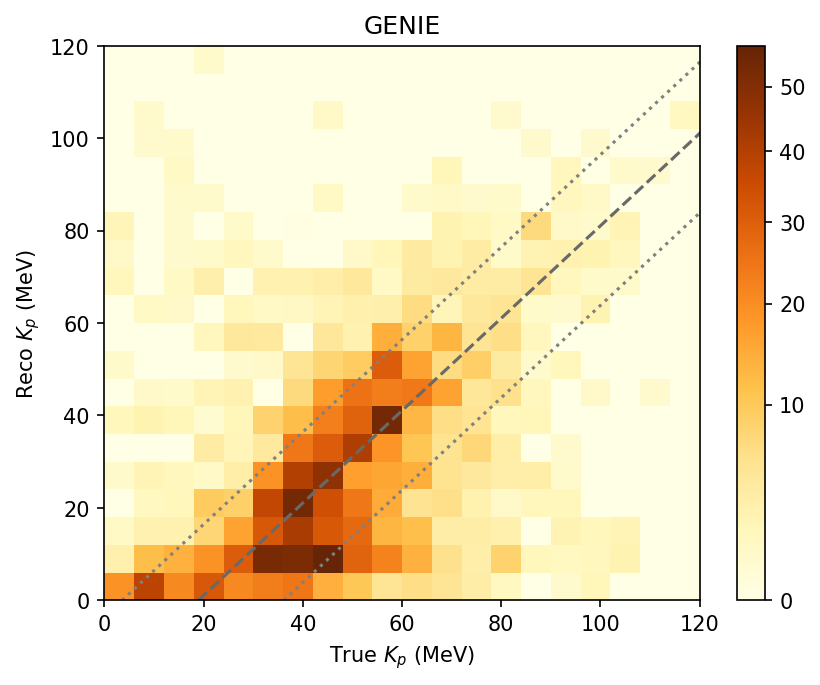

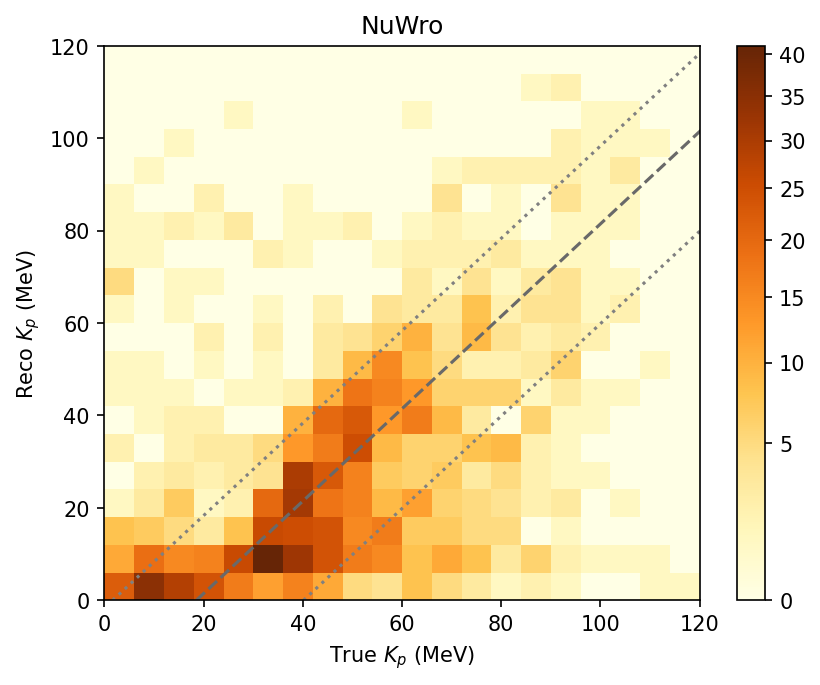

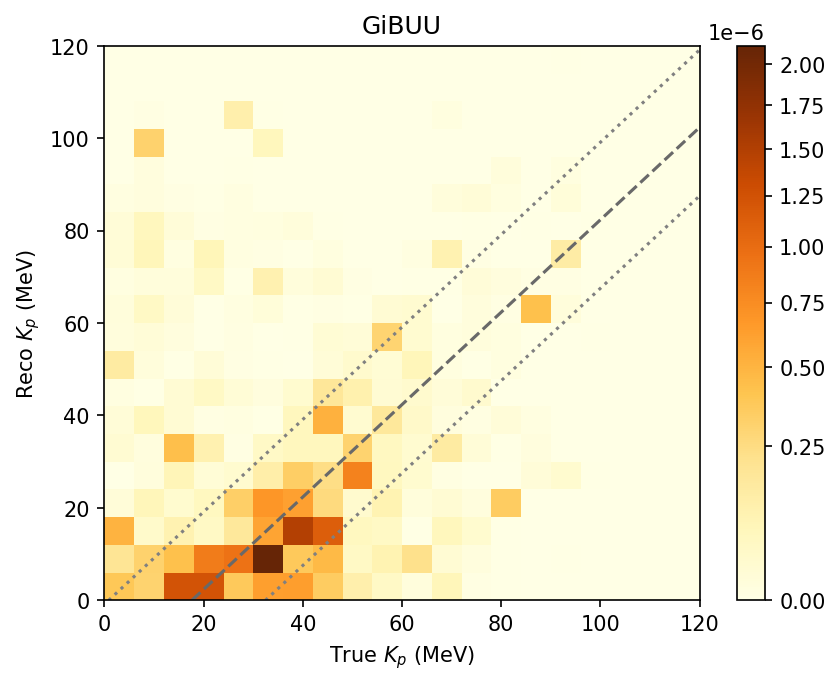

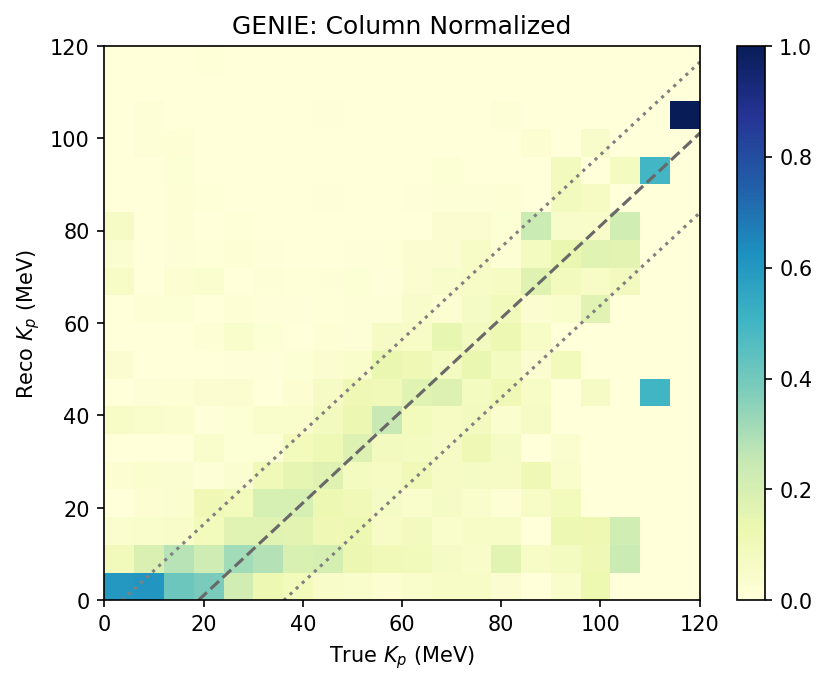

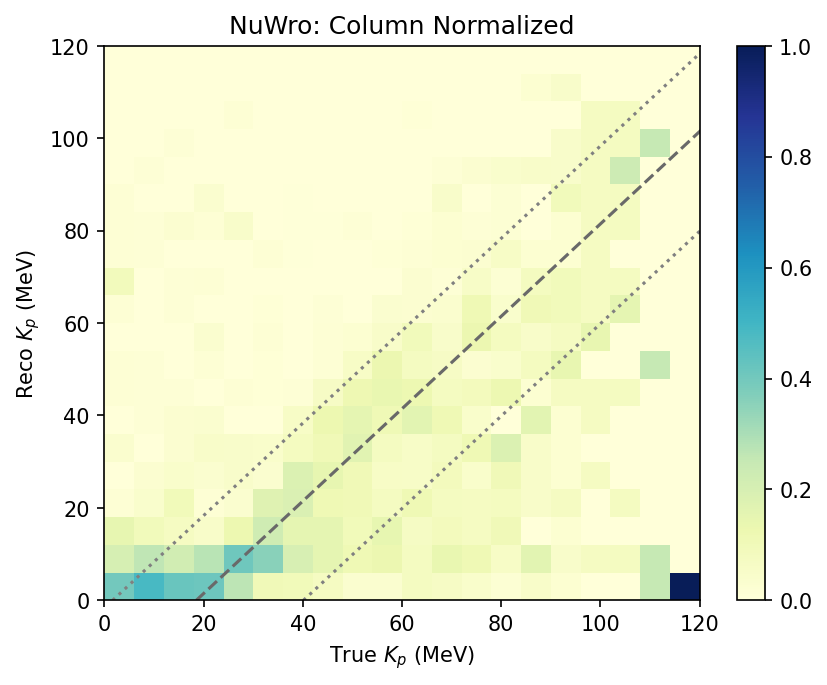

/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_12099/1993924345.py:75: RuntimeWarning: invalid value encountered in divide
  c = plt.pcolormesh(x, y, (dist).T/row_sum,cmap='YlGnBu',vmin=vmin3,vmax=vmax3)


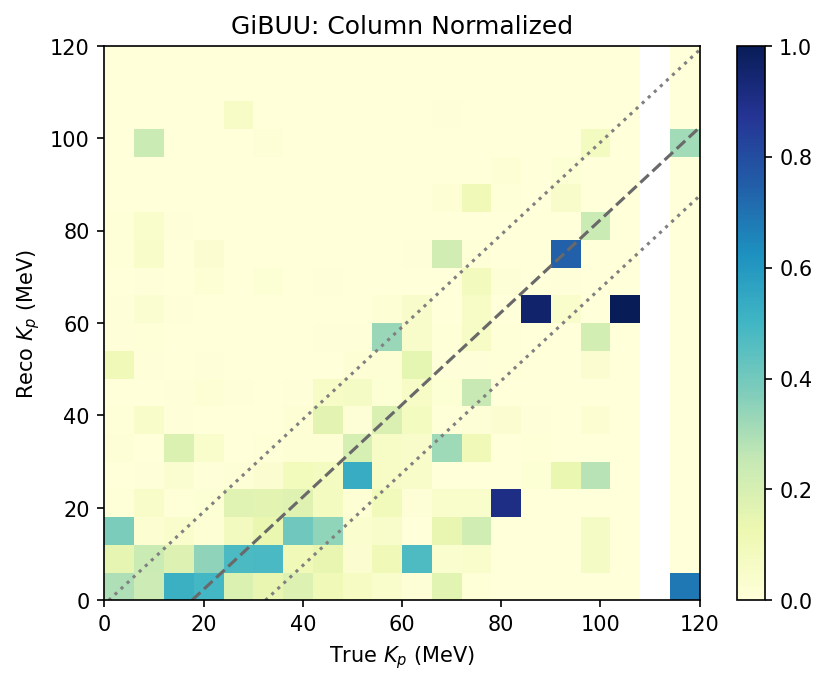

In [83]:
this_query = presel_query + "and ssm_kine_energy>0 and is_KDAR==1 and truth_prim_p_energy>0 and ssm_prim_track1_kine_energy_range>0"
plot_res_all([kdar_overlay_df,nuwro_df,gibuu_df],this_query,"truth_prim_p_energy","ssm_prim_track1_kine_energy_cal",
                 -80,80,40,
                 0,120,20,0,120,20,0.6,
                 0,120,20,0,120,20,0,1,
                 axis_label=r"$K_p$ (MeV)",
)


GENIE
mean: -19.66217928933651
median: -5.054417916606816
std: 48.77356084253464
q1: -72.15903786142388
q3: 7.852086954097032
IQR: 40.00556240776046
FWHM: 36.292499275405056
RMS: 33.98406527354762

NuWro
mean: -34.679338034236835
median: -11.642396557488702
std: 49.45175064493941
q1: -94.72605924741507
q3: 2.7988620202211756
IQR: 48.76246063381812
FWHM: 47.383699542018206
RMS: 41.20491723861275

GiBUU
mean: -14.769109124711985
median: -8.106637881168936
std: 49.26302727334002
q1: -68.01249905251596
q3: 17.897796996367674
IQR: 42.95514802444182
FWHM: 35.16401272853993
RMS: 35.177516509881734



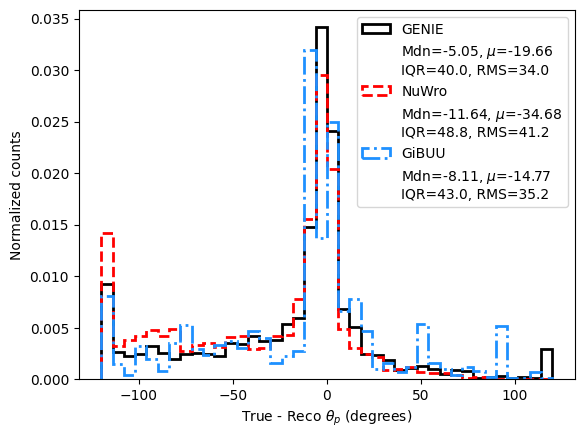

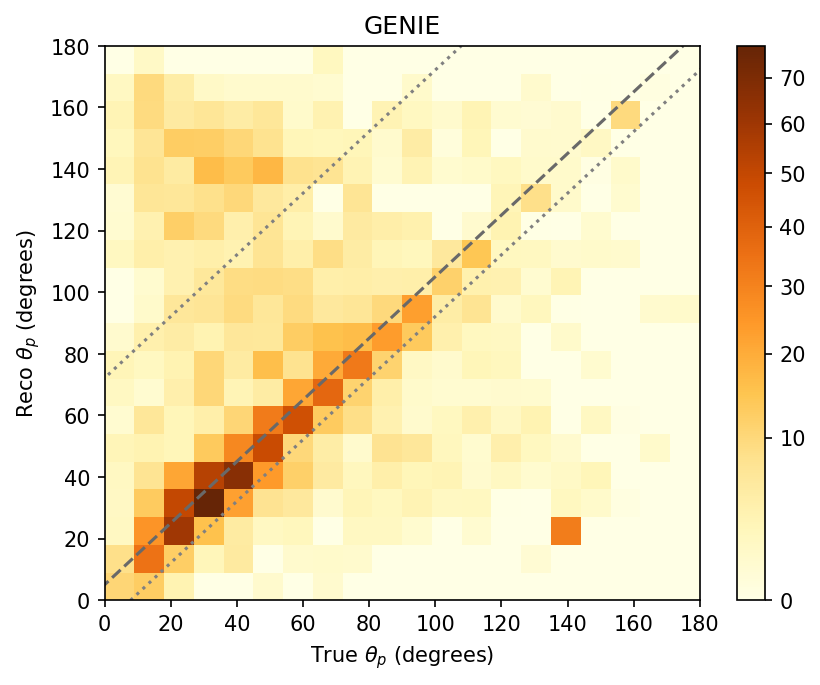

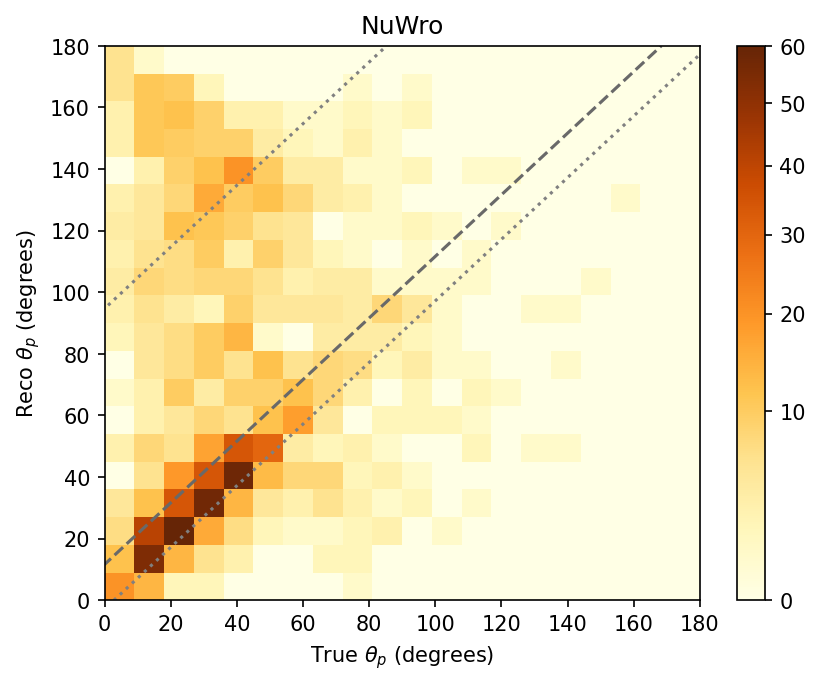

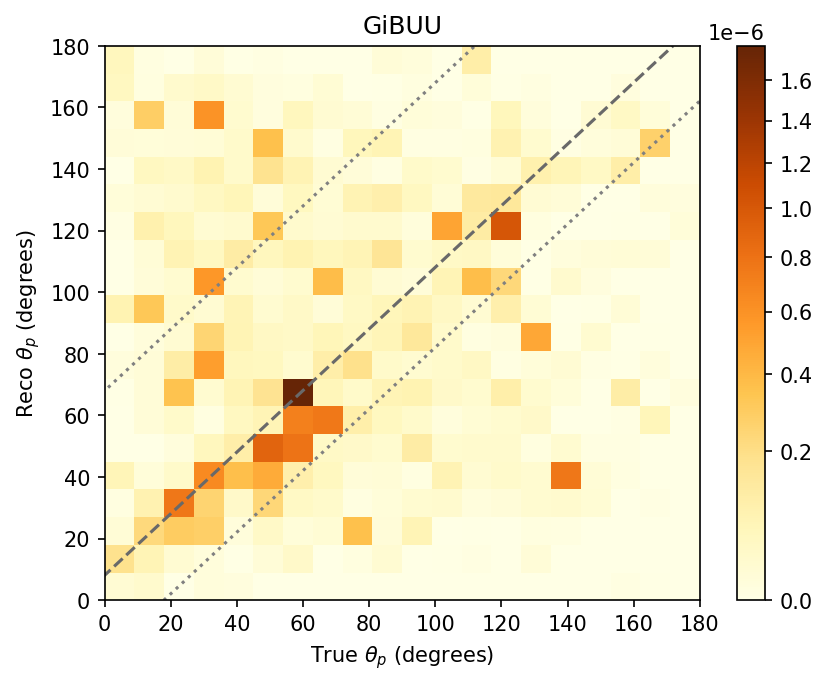

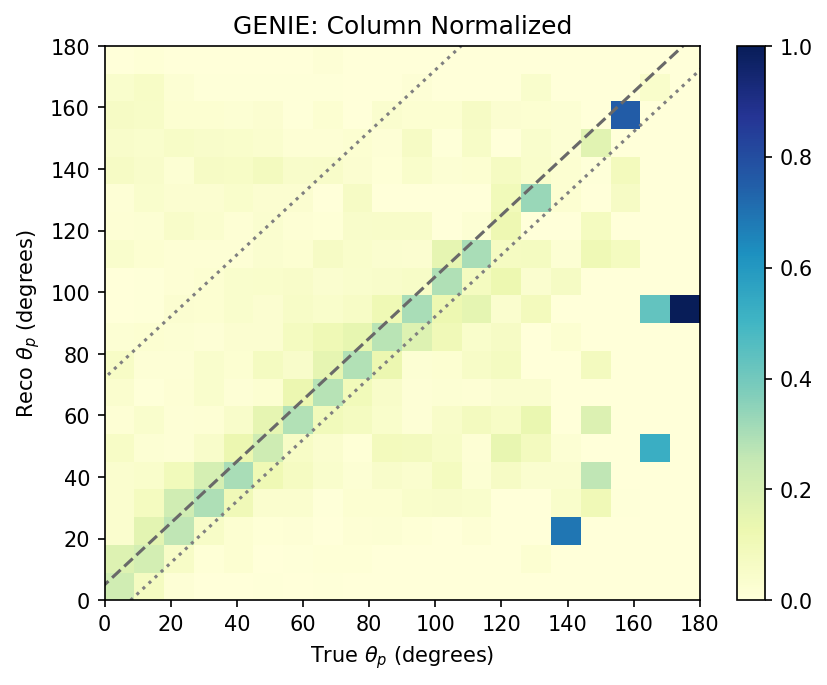

/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_12099/1993924345.py:75: RuntimeWarning: invalid value encountered in divide
  c = plt.pcolormesh(x, y, (dist).T/row_sum,cmap='YlGnBu',vmin=vmin3,vmax=vmax3)


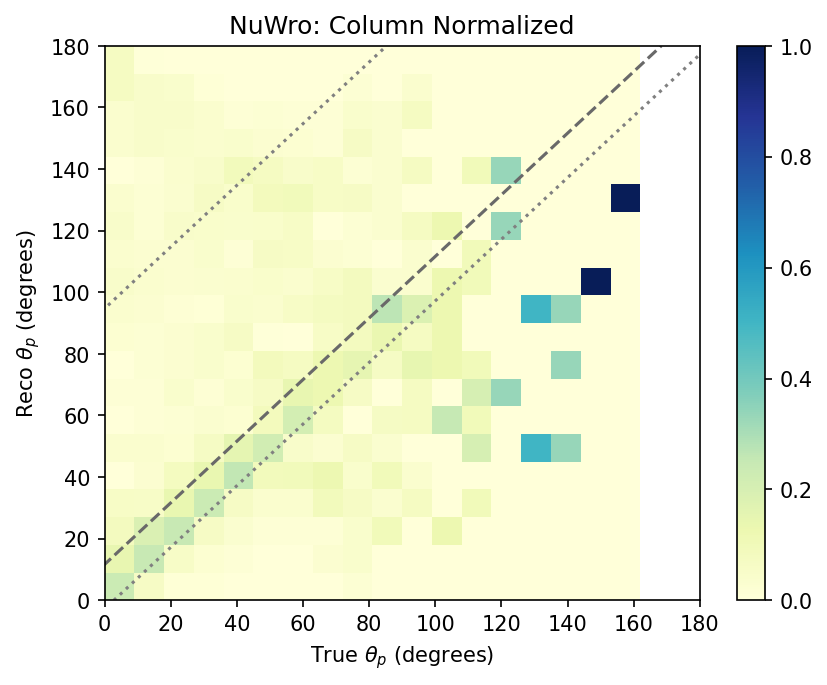

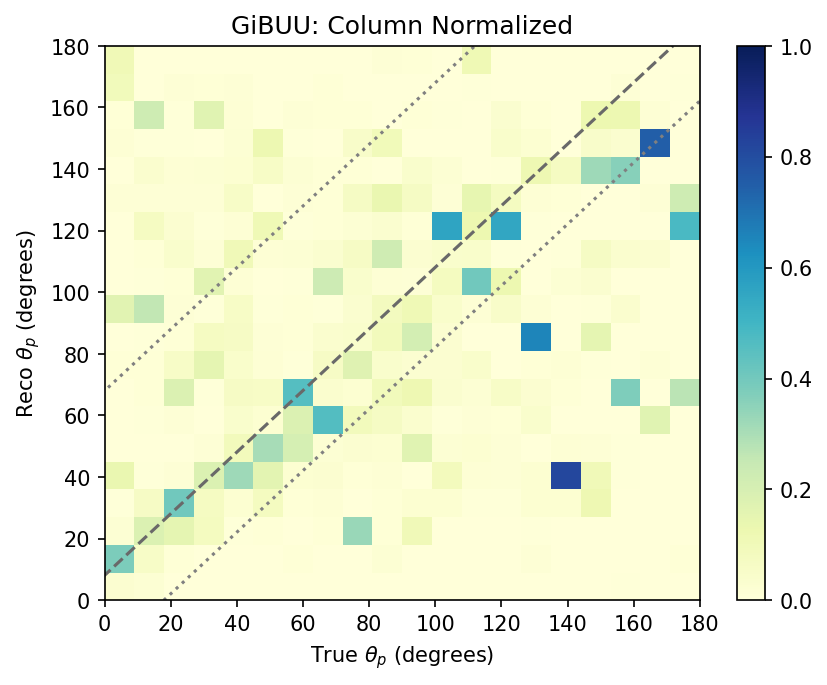

In [84]:

this_query = presel_query + "and ssm_kine_energy>0 and is_KDAR==1 and truth_prim_p_energy>0 and ssm_prim_track1_kine_energy_range>0"
plot_res_all([kdar_overlay_df,nuwro_df,gibuu_df],this_query,"true_angle_P_deg","ssm_angle_P_deg",
                 -120,120,40,
                 0,180,20,0,180,20,0.6,
                 0,180,20,0,180,20,0,1,
                 axis_label=r"$\theta_p$ (degrees)",
)


GENIE
mean: 17.516396927684873
median: 6.380239322662362
std: 102.15473048250725
q1: -8.121776268005362
q3: 26.257571056365975
IQR: 17.18967366218567
FWHM: 13.742482376991095
RMS: 26.074262776122392

NuWro
mean: 17.72825686498462
median: 7.303315475463876
std: 107.08946845428778
q1: -14.078949138641349
q3: 31.78296311187745
IQR: 22.9309561252594
FWHM: 17.380833934390292
RMS: 29.784319626499165

GiBUU
mean: 12.350823676347101
median: 5.181659057617196
std: 97.03312256174092
q1: -15.79004924011231
q3: 26.576752498626718
IQR: 21.183400869369514
FWHM: 15.456789999692957
RMS: 25.400738388456364



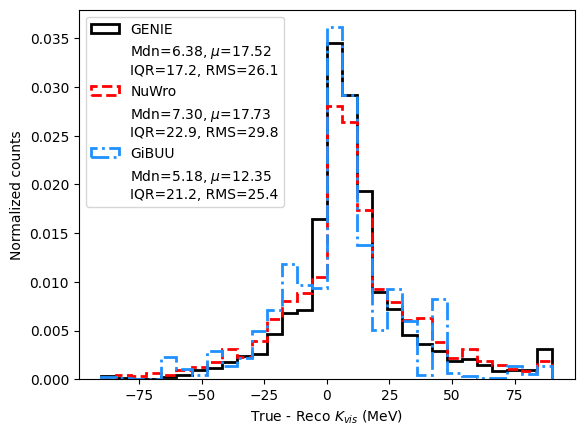

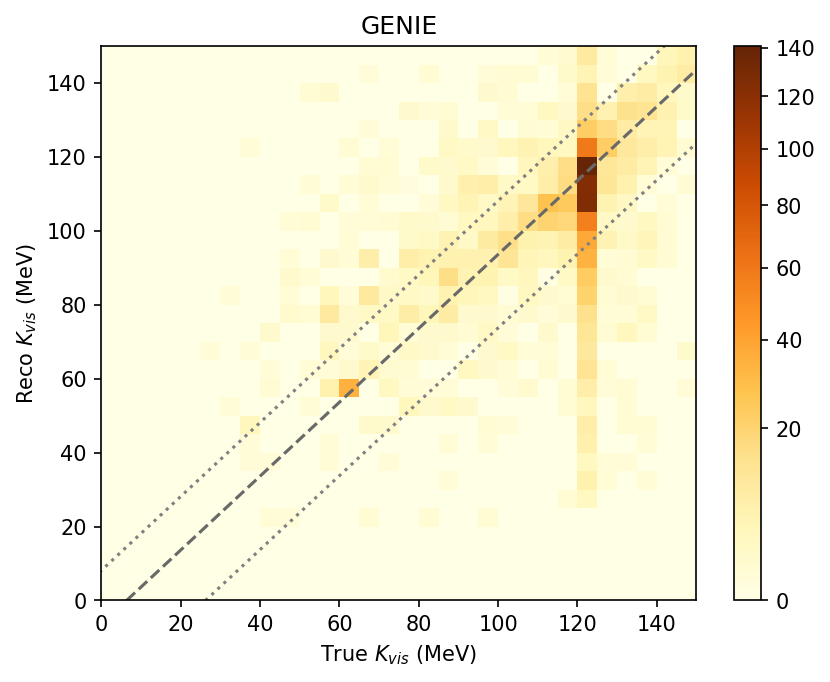

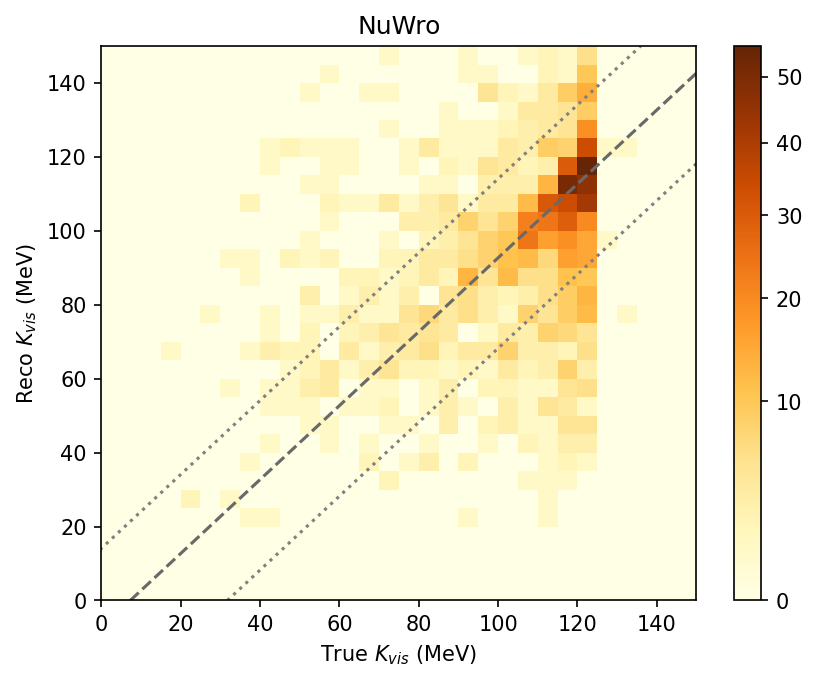

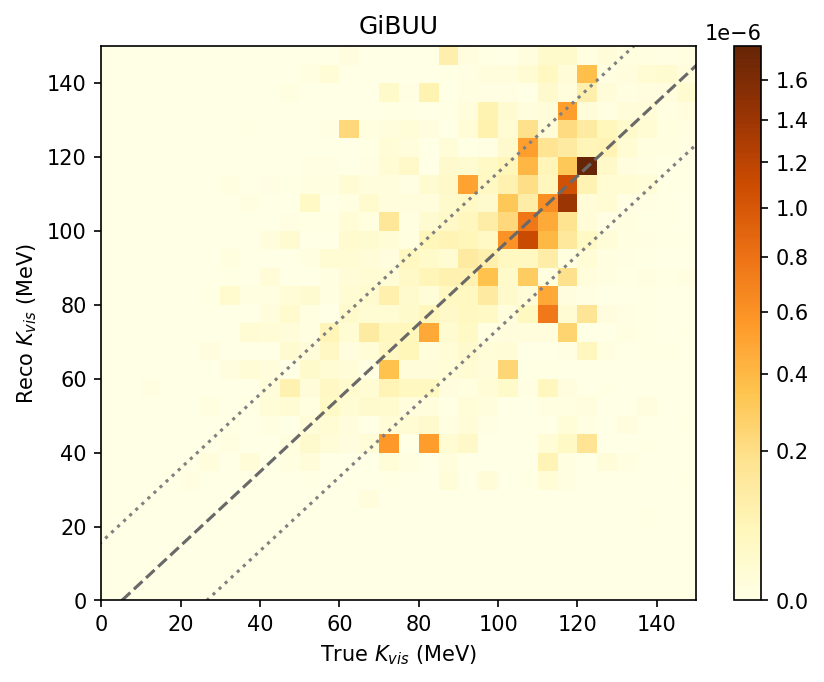

/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_12099/1993924345.py:75: RuntimeWarning: invalid value encountered in divide
  c = plt.pcolormesh(x, y, (dist).T/row_sum,cmap='YlGnBu',vmin=vmin3,vmax=vmax3)


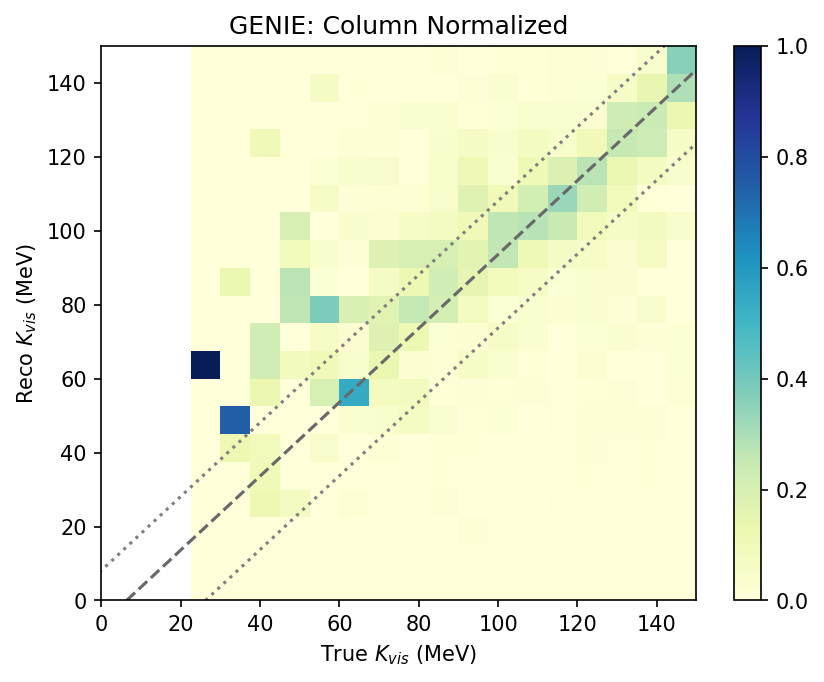

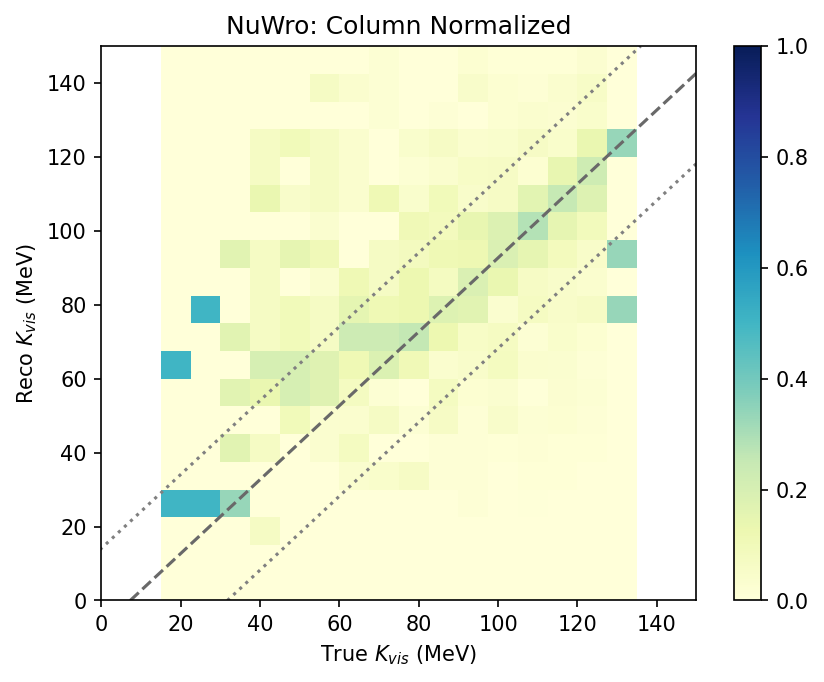

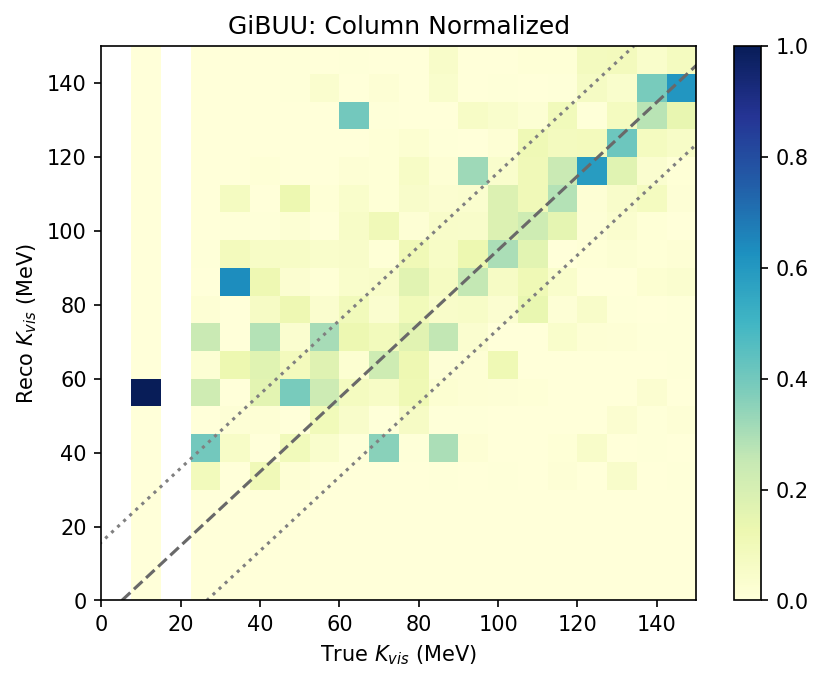

In [85]:
this_query = presel_query + "and ssm_kine_energy>0 and is_KDAR==1 and ssm_prim_track1_kine_energy_range>0 and truth_prim_p_energy>0 "
plot_res_all([kdar_overlay_df,nuwro_df,gibuu_df],this_query,"true_KE","ssm_KE",
                 -90,90,30,
                 0,150,30,0,150,30,0.6,
                 0,150,20,0,150,20,0,1,
                 axis_label=r"$K_{vis}$ (MeV)",
)

GENIE
mean: 12.03337800065623
median: 4.657674148559579
std: 103.51231545796853
q1: -24.03887939453125
q3: 26.085953071594247
IQR: 25.06241623306275
FWHM: 17.73657710917073
RMS: 29.613061629275574

NuWro
mean: 12.284074059259964
median: 5.282965019226083
std: 108.3030369243967
q1: -26.196701049804688
q3: 31.182078674316415
IQR: 28.68938986206055
FWHM: 20.3628901211499
RMS: 33.01147362989555

GiBUU
mean: 2.178842237367738
median: -4.981523200988761
std: 98.55607331167414
q1: -31.071746826171875
q3: 26.576752498626718
IQR: 28.824249662399296
FWHM: 20.443686214837722
RMS: 31.775598633777836



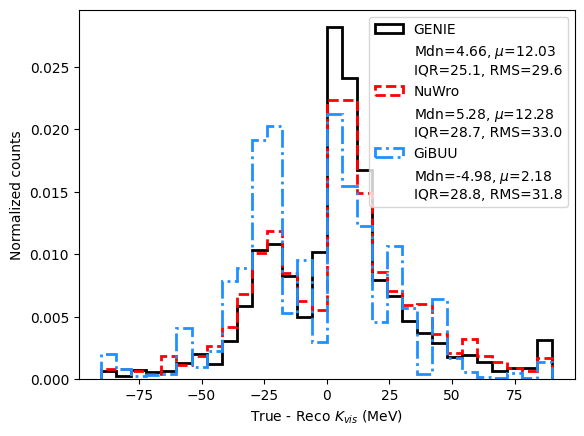

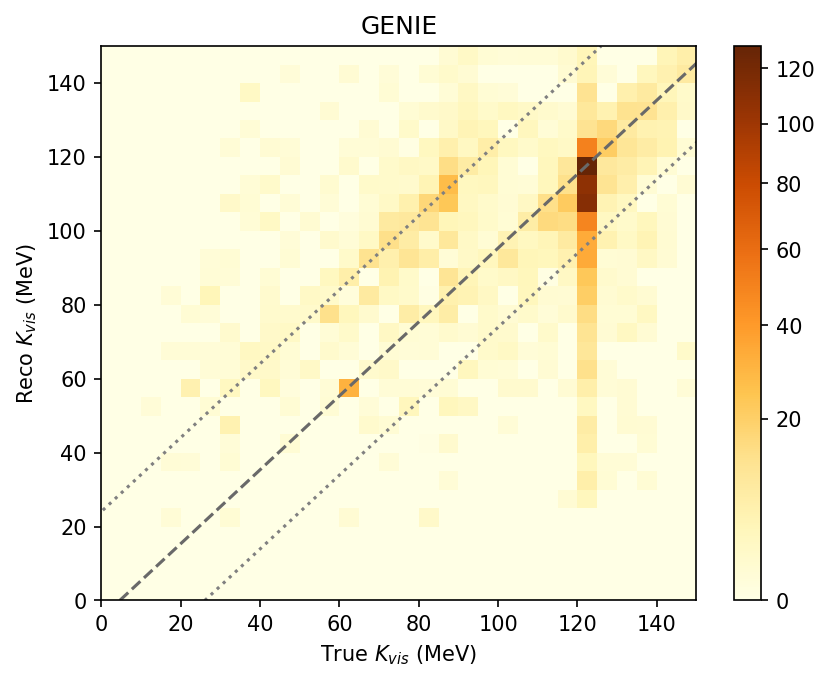

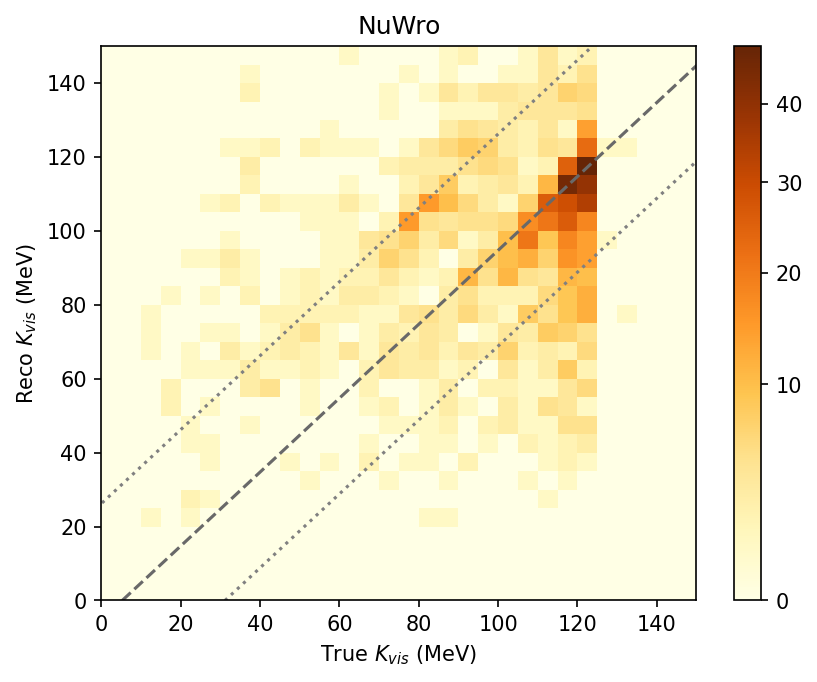

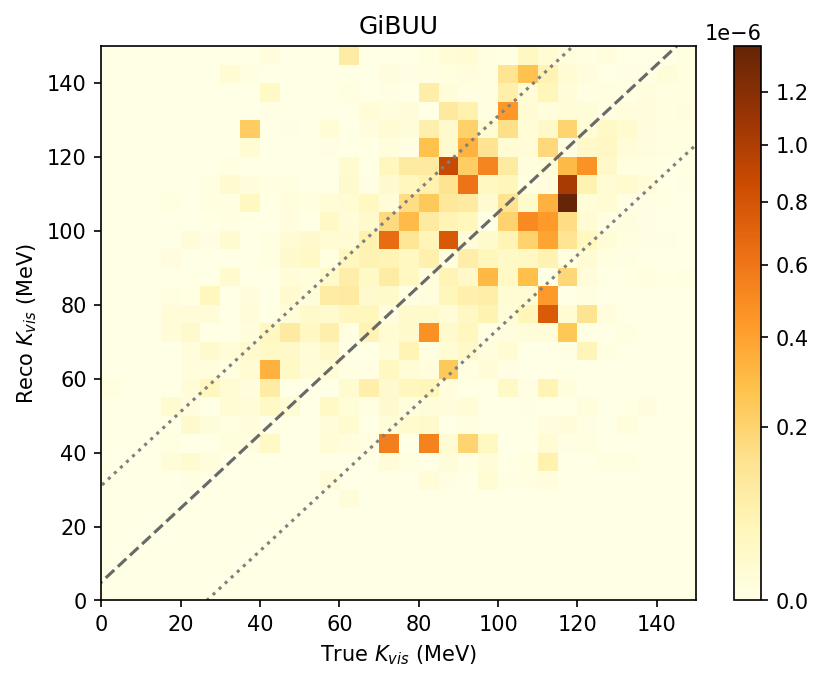

/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_12099/1993924345.py:75: RuntimeWarning: invalid value encountered in divide
  c = plt.pcolormesh(x, y, (dist).T/row_sum,cmap='YlGnBu',vmin=vmin3,vmax=vmax3)


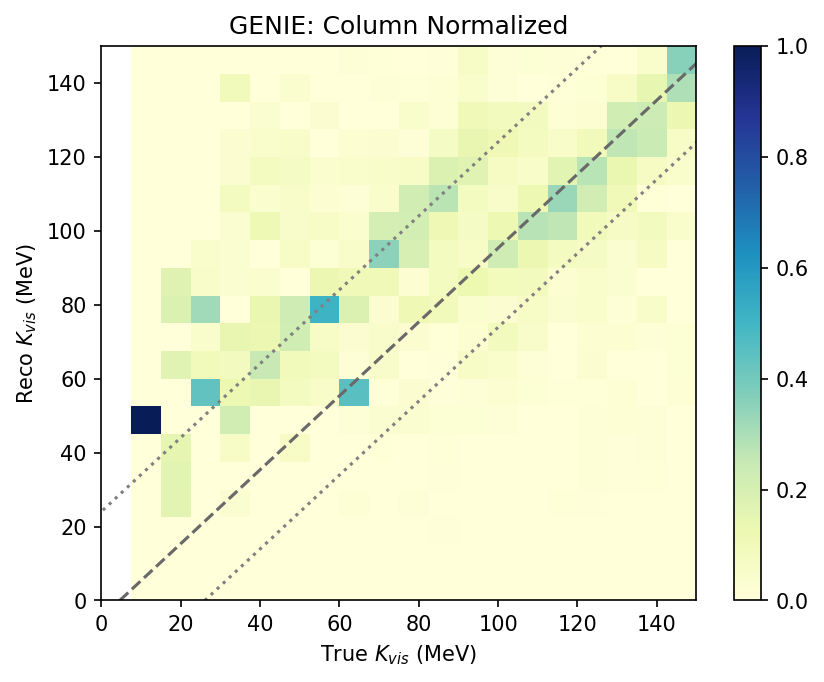

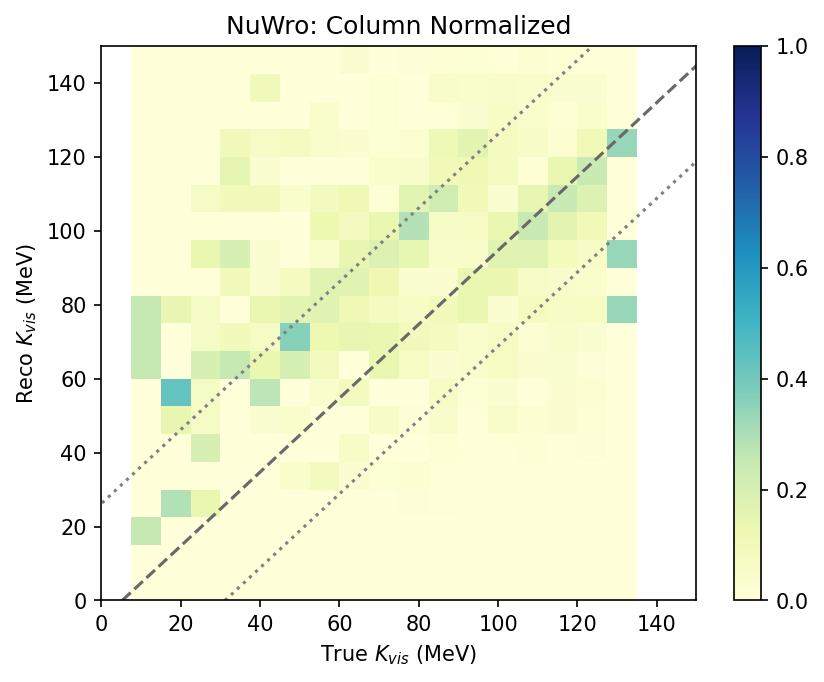

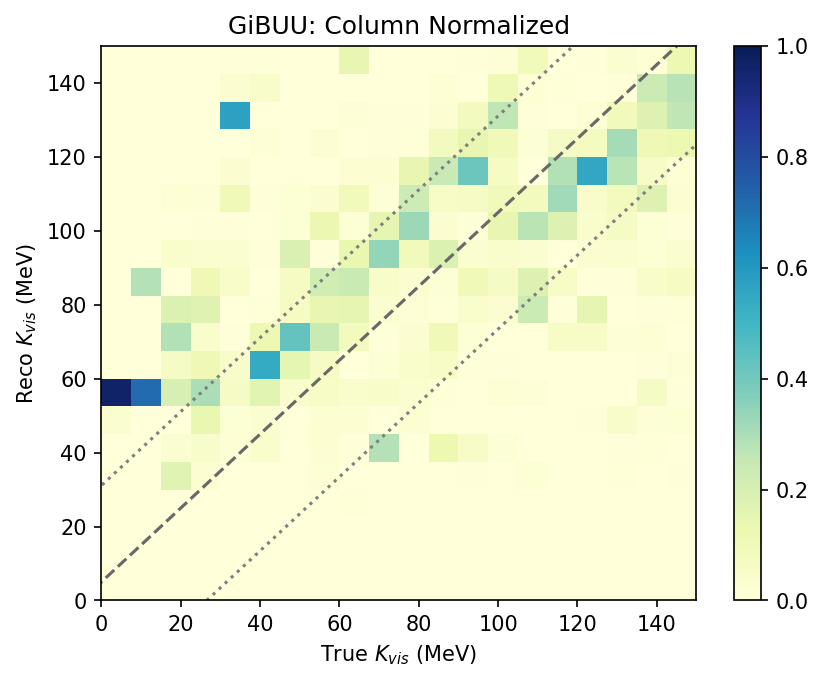

In [86]:
this_query = presel_query + "and ssm_kine_energy>0 and is_KDAR==1 and ssm_prim_track1_kine_energy_range>0 and truth_prim_p_energy>0 "
plot_res_all([kdar_overlay_df,nuwro_df,gibuu_df],this_query,"true_KE_th35","ssm_KE",
                 -90,90,30,
                 0,150,30,0,150,30,0.6,
                 0,150,20,0,150,20,0,1,
                 axis_label=r"$K_{vis}$ (MeV)",
)

GENIE
mean: 41.143623709383085
median: 28.34382851409913
std: 107.85377159407889
q1: 8.428678348541268
q3: 54.288789585113534
IQR: 22.930055618286133
FWHM: 27.469598164697917
RMS: 42.93812673583346

NuWro
mean: 38.86954316812307
median: 24.546710327148446
std: 115.3613392849168
q1: 2.9024505615234375
q3: 54.07433684158326
IQR: 25.58594314002991
FWHM: 27.076087808798636
RMS: 41.756833982437065

GiBUU
mean: 26.76724930560708
median: 9.20143349456788
std: 115.04477552002822
q1: -0.438629150390625
q3: 33.400717571258554
IQR: 16.91967336082459
FWHM: 16.701798778923127
RMS: 29.59612243646311



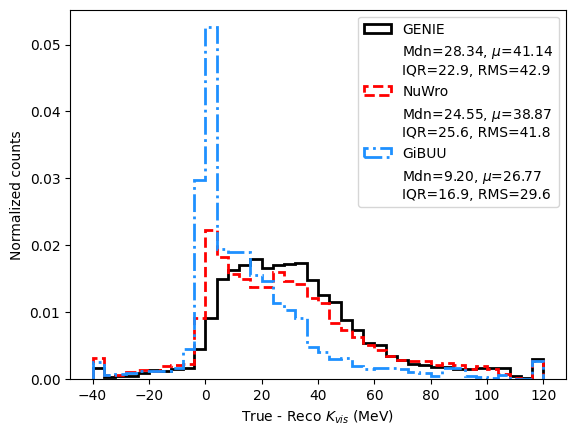

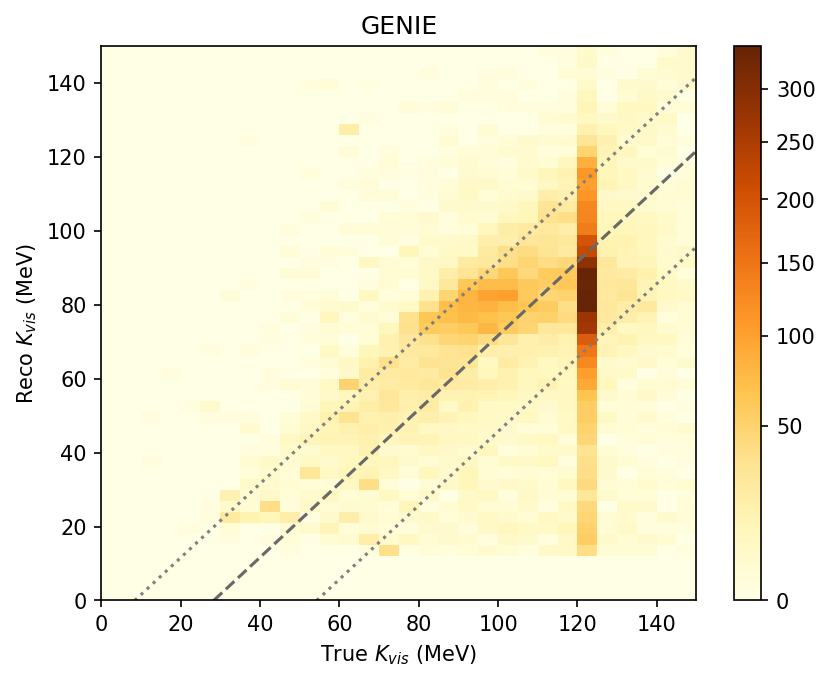

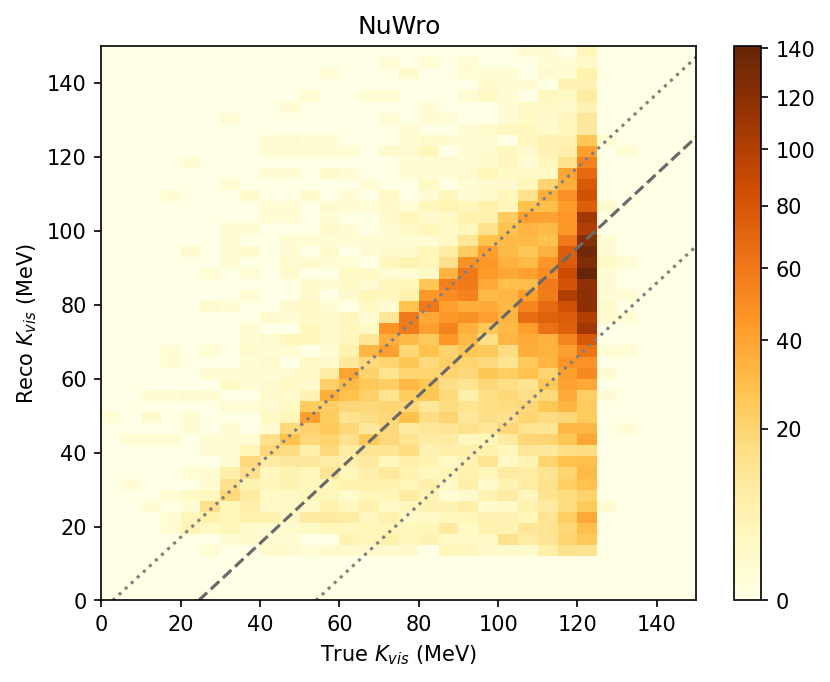

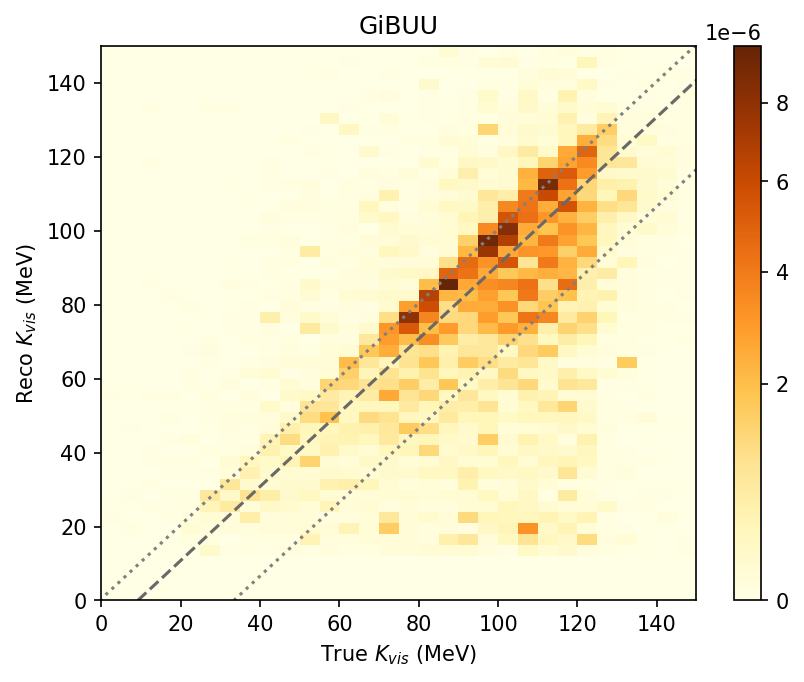

/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_12099/1993924345.py:75: RuntimeWarning: invalid value encountered in divide
  c = plt.pcolormesh(x, y, (dist).T/row_sum,cmap='YlGnBu',vmin=vmin3,vmax=vmax3)


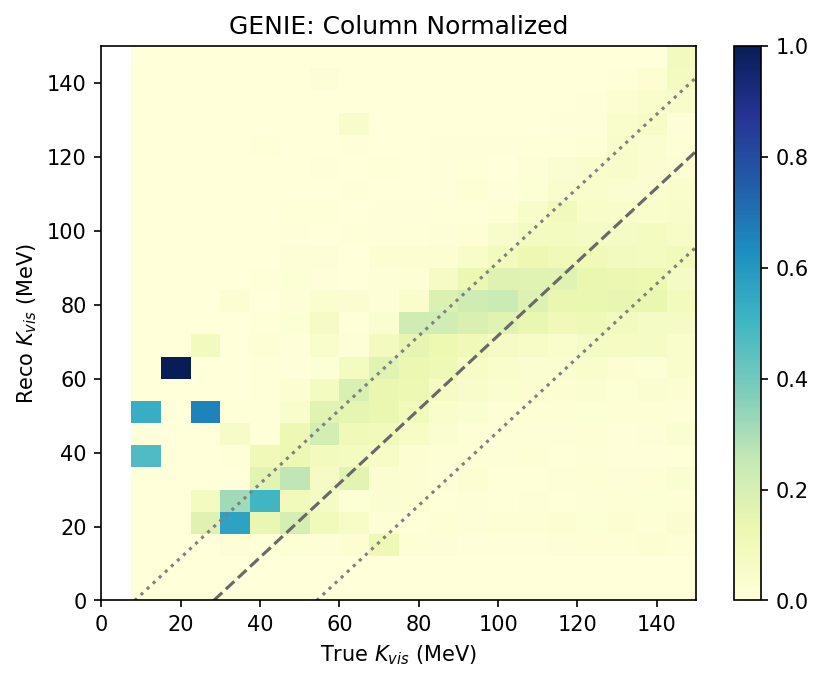

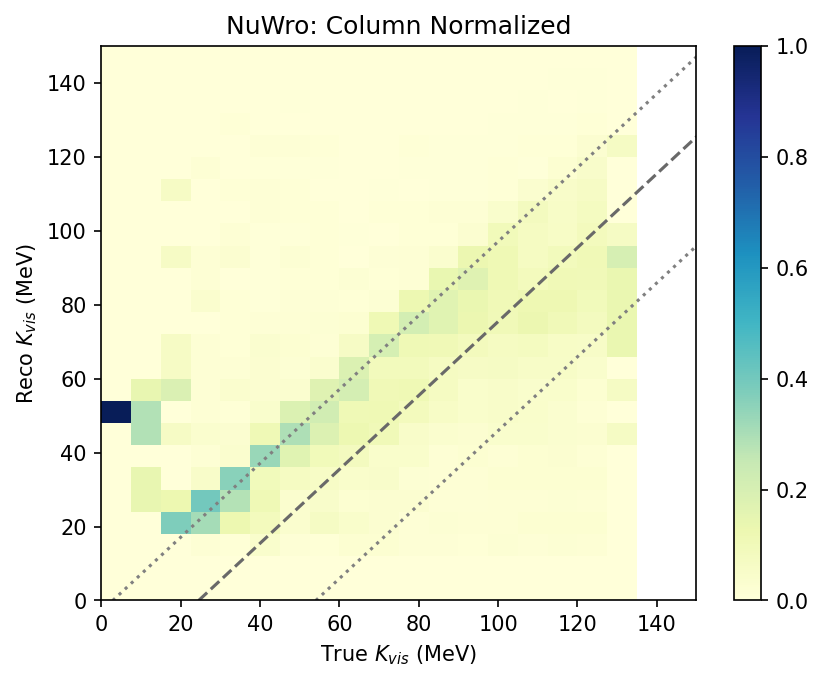

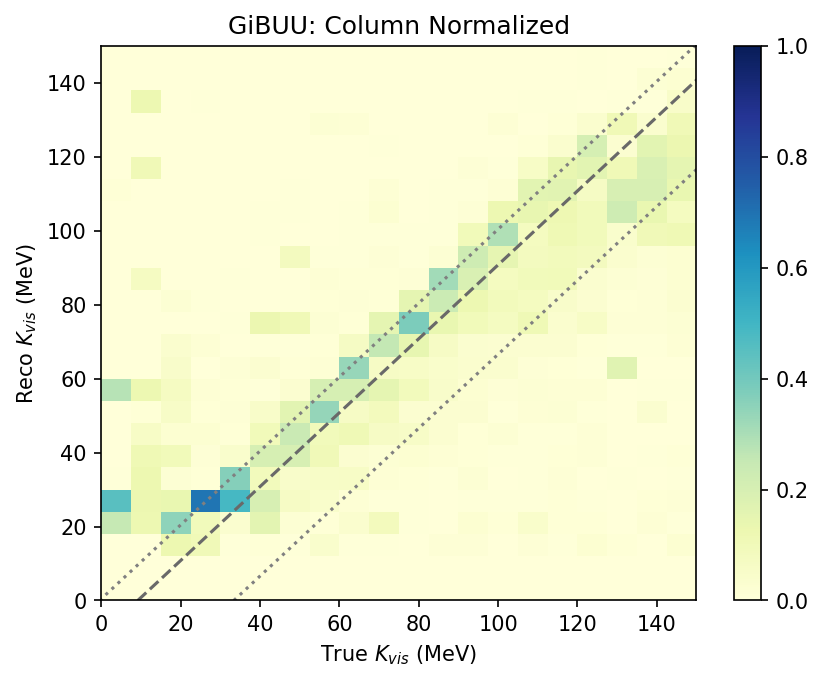

In [87]:
this_query = presel_query + "and ssm_kine_energy>0 and is_KDAR==1"
plot_res_all([kdar_overlay_df,nuwro_df,gibuu_df],this_query,"true_KE","ssm_KE",
                 -40,120,40,
                 0,150,30,0,150,50,0.6,
                 0,150,20,0,150,25,0,1,
                 axis_label=r"$K_{vis}$ (MeV)",
)

GENIE
mean: 30.961274769069053
median: 5.595147922515878
std: 109.57437818097067
q1: -2.289306640625
q3: 52.6075439453125
IQR: 27.44842529296875
FWHM: 26.328665959618974
RMS: 35.574374357994586

NuWro
mean: 30.063699952529948
median: 3.1617584228515625
std: 116.43232925189517
q1: -2.3724212646484375
q3: 52.52148278045655
IQR: 27.446952022552495
FWHM: 26.287518597781105
RMS: 35.42378161937753

GiBUU
mean: 18.615138534481616
median: 0.9083251953125
std: 115.29666205644901
q1: -2.6554718017578125
q3: 23.361378028869638
IQR: 13.008424915313725
FWHM: 11.755908236900328
RMS: 23.49835981473211



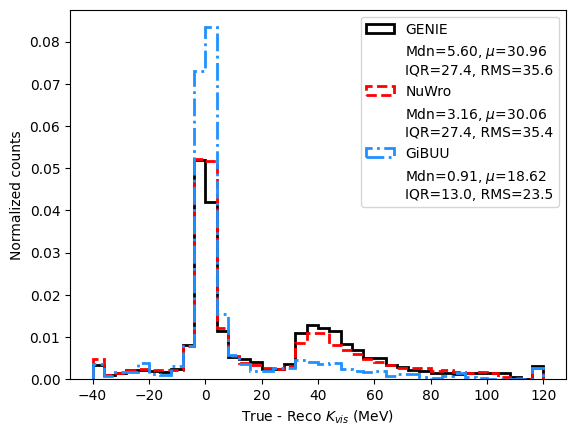

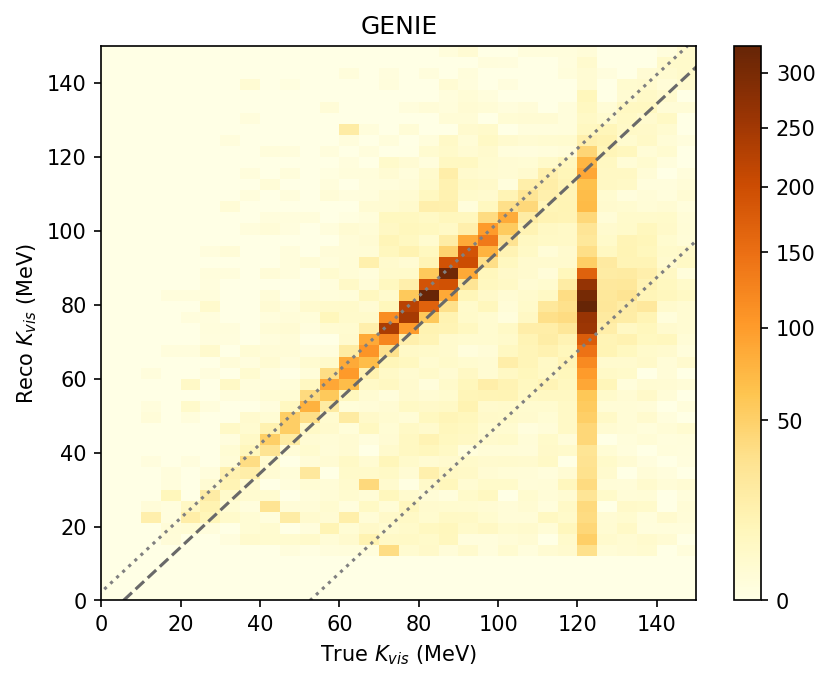

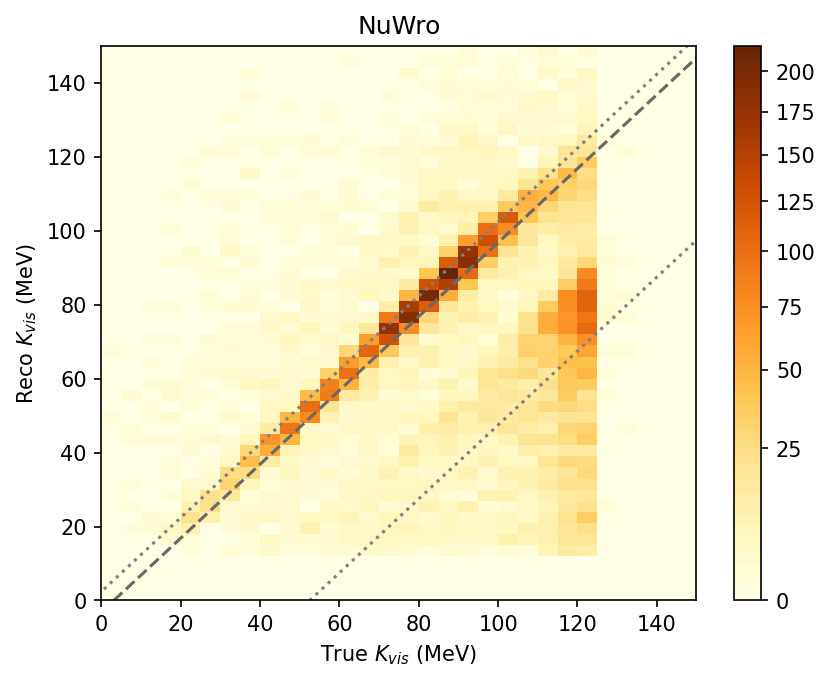

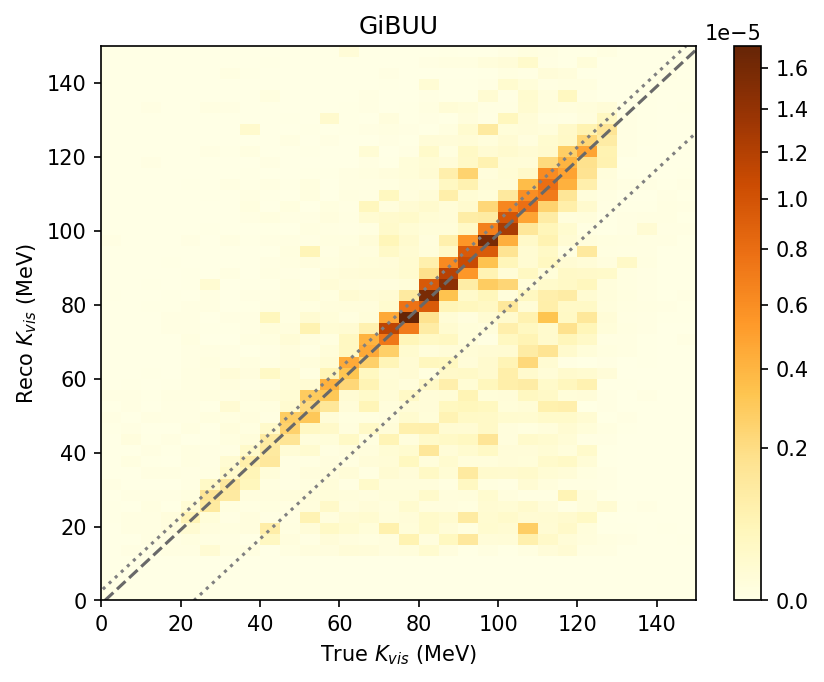

/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_12099/1993924345.py:75: RuntimeWarning: invalid value encountered in divide
  c = plt.pcolormesh(x, y, (dist).T/row_sum,cmap='YlGnBu',vmin=vmin3,vmax=vmax3)


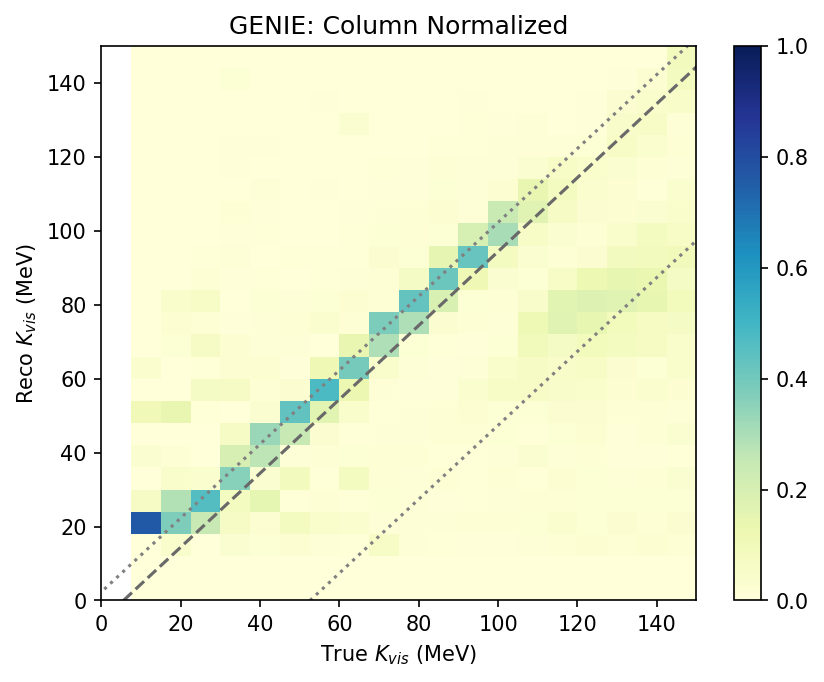

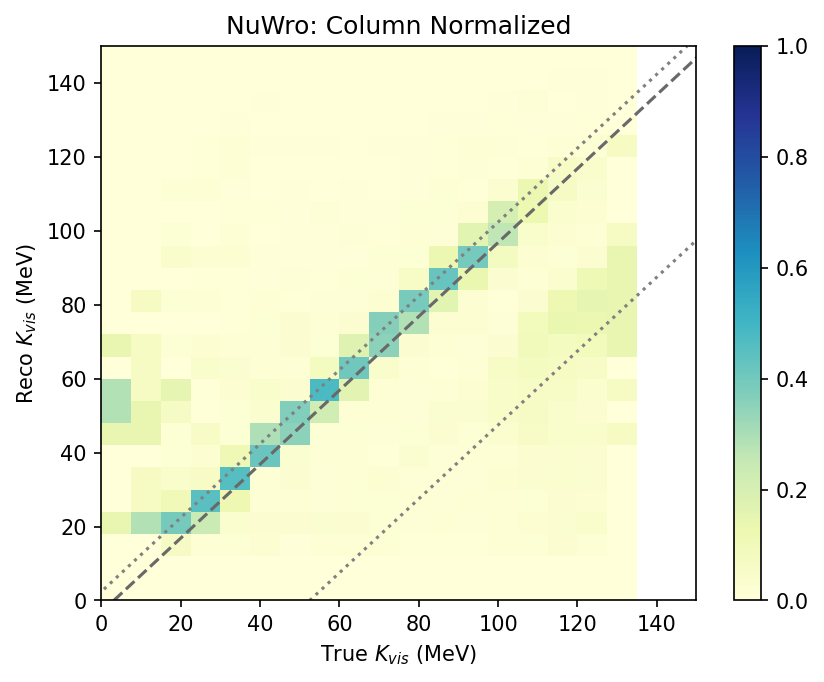

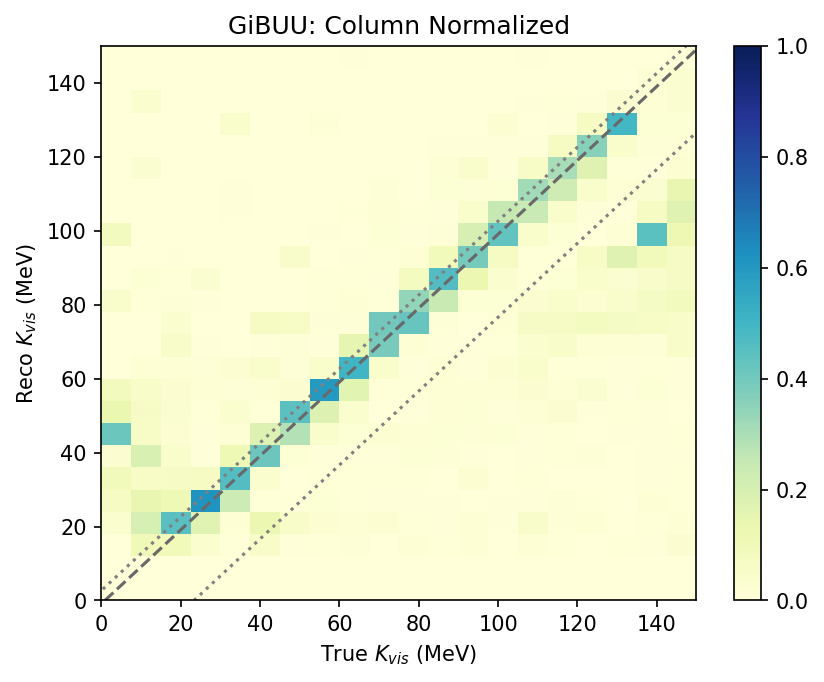

In [88]:
this_query = presel_query + "and ssm_kine_energy>0 and is_KDAR==1"
plot_res_all([kdar_overlay_df,nuwro_df,gibuu_df],this_query,"true_KE_th35","ssm_KE",
                 -40,120,40,
                 0,150,30,0,150,50,0.6,
                 0,150,20,0,150,25,0,1,
                 axis_label=r"$K_{vis}$ (MeV)",
)

genie
mean: -3.5318508596402243
median: -2.937554006099802
std: 41.15052242290017
q1: -22.47230448474818
q3: 9.269935522285849
IQR: 15.871120003517014
FWHM: 12.154589394983383
RMS: 23.37961240998402

genie,computed with weights
mean: -10.002136860993687
median: -4.0147623771717775
std: 49.11303920321231
q1: -52.308848103605484
q3: 18.66178909069278
IQR: 35.48531859714913
FWHM: 27.76903834305201
RMS: 32.28689640621223


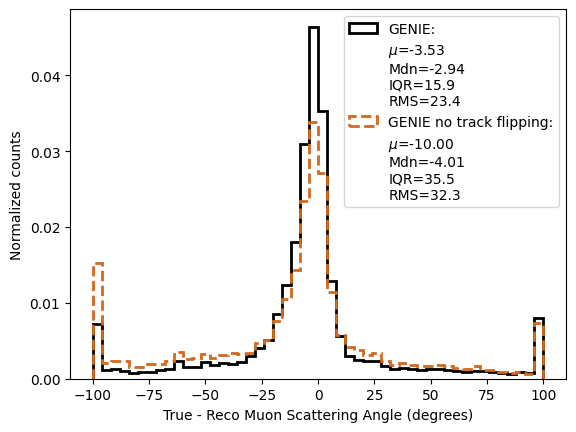

In [89]:
true_genie = kdar_overlay_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["true_angle"].to_numpy()*180/3.14
reco_genie = np.nan_to_num(np.arccos(kdar_overlay_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["ssm_cosMu"].to_numpy())*180/3.14,nan=0)
ssm_vtxX = kdar_overlay_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["ssm_vtxX"].to_numpy()
ssm_vtxY = kdar_overlay_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["ssm_vtxY"].to_numpy()
ssm_vtxZ = kdar_overlay_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["ssm_vtxZ"].to_numpy()
reco_nuvtxX = kdar_overlay_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["reco_nuvtxX"].to_numpy()
reco_nuvtxY = kdar_overlay_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["reco_nuvtxY"].to_numpy()
reco_nuvtxZ = kdar_overlay_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["reco_nuvtxZ"].to_numpy()
reco_genie_og = []
for i in range(len(reco_genie)):
    if abs(ssm_vtxX[i]-reco_nuvtxX[i])>1 or abs(ssm_vtxY[i]-reco_nuvtxY[i])>1 or abs(ssm_vtxZ[i]-reco_nuvtxZ[i])>1:
        reco_genie_og.append(180-reco_genie[i])
    else: reco_genie_og.append(reco_genie[i])

genie_weights = kdar_overlay_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["net_weight"].to_numpy()

print("genie")
diff_genie = true_genie-reco_genie
genie_mean,genie_q,genie_std,genie_iqr,genie_rms = get_stats(diff_genie,weights=genie_weights)
print("")

print("genie,computed with weights")
diff_genie_og = true_genie-np.array(reco_genie_og)
genie_og_mean,genie_og_q,genie_og_std,genie_og_iqr,genie_og_rms = get_stats(diff_genie_og,weights=genie_weights)

xmin = -100
xmax = 100
nbins = 50
plt.figure()
plt.hist(np.clip(diff_genie,xmin,xmax),bins=nbins,range=(xmin,xmax),label=f'GENIE:',histtype='step',color='black',lw=2,density=True,weights=genie_weights)
plt.plot([],[],lw=0,label=f'$\mu$={genie_mean:.2f}'+'\n'+f'Mdn={genie_q[1]:.2f}'+'\n'+f'IQR={genie_iqr:.1f}'+'\n'+f'RMS={genie_rms:.1f}')
plt.hist(np.clip(diff_genie_og,xmin,xmax),bins=nbins,range=(xmin,xmax),label=f'GENIE no track flipping:',color='chocolate',lw=2,density=True,histtype='step',weights=genie_weights,ls='--')
plt.plot([],[],lw=0,label=f'$\mu$={genie_og_mean:.2f}'+'\n'+f'Mdn={genie_og_q[1]:.2f}'+'\n'+f'IQR={genie_og_iqr:.1f}'+'\n'+f'RMS={genie_og_rms:.1f}')
plt.legend()
plt.ylabel("Normalized counts")
plt.xlabel(r"True - Reco Muon Scattering Angle (degrees)")
plt.show()

nuwro
mean: -10.328409078143427
median: -4.905445928623479
std: 46.084922863674315
q1: -41.41148759868627
q3: 6.922502420885859
IQR: 24.166995009786064
FWHM: 20.993048521494668
RMS: 28.599809962051868

nuwro,computed with weights
mean: -19.412781390182275
median: -7.463581433019158
std: 53.512983626176656
q1: -74.72670964533015
q3: 12.246293306294234
IQR: 43.48650147581219
FWHM: 37.86176446681158
RMS: 38.30286289320685


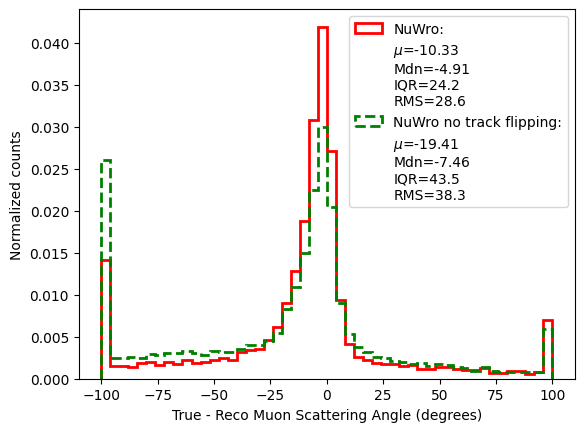

In [90]:
true_nuwro = nuwro_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["true_angle"].to_numpy()*180/3.14
reco_nuwro = np.nan_to_num(np.arccos(nuwro_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["ssm_cosMu"].to_numpy())*180/3.14,nan=0)
ssm_vtxX = nuwro_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["ssm_vtxX"].to_numpy()
ssm_vtxY = nuwro_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["ssm_vtxY"].to_numpy()
ssm_vtxZ = nuwro_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["ssm_vtxZ"].to_numpy()
reco_nuvtxX = nuwro_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["reco_nuvtxX"].to_numpy()
reco_nuvtxY = nuwro_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["reco_nuvtxY"].to_numpy()
reco_nuvtxZ = nuwro_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["reco_nuvtxZ"].to_numpy()
reco_nuwro_og = []
for i in range(len(reco_nuwro)):
    if abs(ssm_vtxX[i]-reco_nuvtxX[i])>1 or abs(ssm_vtxY[i]-reco_nuvtxY[i])>1 or abs(ssm_vtxZ[i]-reco_nuvtxZ[i])>1:
        reco_nuwro_og.append(180-reco_nuwro[i])
    else: reco_nuwro_og.append(reco_nuwro[i])

nuwro_weights = nuwro_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["net_weight"].to_numpy()

print("nuwro")
diff_nuwro = true_nuwro-reco_nuwro
nuwro_mean,nuwro_q,nuwro_std,nuwro_iqr,nuwro_rms = get_stats(diff_nuwro,weights=nuwro_weights)
print("")

print("nuwro,computed with weights")
diff_nuwro_og = true_nuwro-np.array(reco_nuwro_og)
nuwro_og_mean,nuwro_og_q,nuwro_og_std,nuwro_og_iqr,nuwro_og_rms = get_stats(diff_nuwro_og,weights=nuwro_weights)

xmin = -100
xmax = 100
nbins = 50
plt.figure()
plt.hist(np.clip(diff_nuwro,xmin,xmax),bins=nbins,range=(xmin,xmax),label=f'NuWro:',histtype='step',color='red',lw=2,density=True,weights=nuwro_weights)
plt.plot([],[],lw=0,label=f'$\mu$={nuwro_mean:.2f}'+'\n'+f'Mdn={nuwro_q[1]:.2f}'+'\n'+f'IQR={nuwro_iqr:.1f}'+'\n'+f'RMS={nuwro_rms:.1f}')
plt.hist(np.clip(diff_nuwro_og,xmin,xmax),bins=nbins,range=(xmin,xmax),label=f'NuWro no track flipping:',color='green',lw=2,density=True,histtype='step',weights=nuwro_weights,ls='--')
plt.plot([],[],lw=0,label=f'$\mu$={nuwro_og_mean:.2f}'+'\n'+f'Mdn={nuwro_og_q[1]:.2f}'+'\n'+f'IQR={nuwro_og_iqr:.1f}'+'\n'+f'RMS={nuwro_og_rms:.1f}')
plt.legend()
plt.ylabel("Normalized counts")
plt.xlabel(r"True - Reco Muon Scattering Angle (degrees)")
plt.show()

gibuu
mean: -4.485151126935841
median: -1.045340096981377
std: 45.27248166649973
q1: -36.039461735657625
q3: 10.787474384751988
IQR: 23.413468060204806
FWHM: 18.80965447448205
RMS: 26.136443566146095

gibuu,computed with weights
mean: -12.903182251775595
median: -2.3522540300270762
std: 48.38251514998713
q1: -62.07455690813464
q3: 14.352340554685355
IQR: 38.21344873141
FWHM: 31.856083778216178
RMS: 32.07640693583369


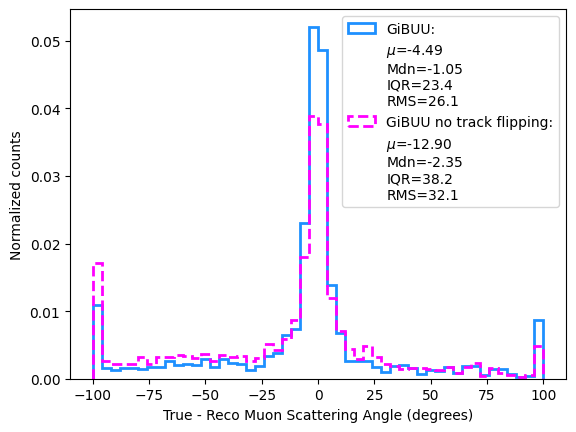

In [91]:
true_gibuu = gibuu_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["true_angle"].to_numpy()*180/3.14
reco_gibuu = np.nan_to_num(np.arccos(gibuu_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["ssm_cosMu"].to_numpy())*180/3.14,nan=0)
ssm_vtxX = gibuu_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["ssm_vtxX"].to_numpy()
ssm_vtxY = gibuu_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["ssm_vtxY"].to_numpy()
ssm_vtxZ = gibuu_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["ssm_vtxZ"].to_numpy()
reco_nuvtxX = gibuu_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["reco_nuvtxX"].to_numpy()
reco_nuvtxY = gibuu_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["reco_nuvtxY"].to_numpy()
reco_nuvtxZ = gibuu_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["reco_nuvtxZ"].to_numpy()
reco_gibuu_og = []
for i in range(len(reco_gibuu)):
    if abs(ssm_vtxX[i]-reco_nuvtxX[i])>1 or abs(ssm_vtxY[i]-reco_nuvtxY[i])>1 or abs(ssm_vtxZ[i]-reco_nuvtxZ[i])>1:
        reco_gibuu_og.append(180-reco_gibuu[i])
    else: reco_gibuu_og.append(reco_gibuu[i])

gibuu_weights = gibuu_df.query(presel_query).query("ssm_kine_energy>0 and kine_reco_Enu>0").query("is_KDAR==1")["net_weight"].to_numpy()

print("gibuu")
diff_gibuu = true_gibuu-reco_gibuu
gibuu_mean,gibuu_q,gibuu_std,gibuu_iqr,gibuu_rms = get_stats(diff_gibuu,weights=gibuu_weights)
print("")

print("gibuu,computed with weights")
diff_gibuu_og = true_gibuu-np.array(reco_gibuu_og)
gibuu_og_mean,gibuu_og_q,gibuu_og_std,gibuu_og_iqr,gibuu_og_rms = get_stats(diff_gibuu_og,weights=gibuu_weights)

xmin = -100
xmax = 100
nbins = 50
plt.figure()
plt.hist(np.clip(diff_gibuu,xmin,xmax),bins=nbins,range=(xmin,xmax),label=f'GiBUU:',histtype='step',color='dodgerblue',lw=2,density=True,weights=gibuu_weights)
plt.plot([],[],lw=0,label=f'$\mu$={gibuu_mean:.2f}'+'\n'+f'Mdn={gibuu_q[1]:.2f}'+'\n'+f'IQR={gibuu_iqr:.1f}'+'\n'+f'RMS={gibuu_rms:.1f}')
plt.hist(np.clip(diff_gibuu_og,xmin,xmax),bins=nbins,range=(xmin,xmax),label=f'GiBUU no track flipping:',color='magenta',lw=2,density=True,histtype='step',weights=gibuu_weights,ls='--')
plt.plot([],[],lw=0,label=f'$\mu$={gibuu_og_mean:.2f}'+'\n'+f'Mdn={gibuu_og_q[1]:.2f}'+'\n'+f'IQR={gibuu_og_iqr:.1f}'+'\n'+f'RMS={gibuu_og_rms:.1f}')
plt.legend()
plt.ylabel("Normalized counts")
plt.xlabel(r"True - Reco Muon Scattering Angle (degrees)")
plt.show()

genie
mean: 4.520410131031565
median: 6.044632270812997
std: 22.737114394967186
q1: -11.016738578796382
q3: 20.030294254302987
IQR: 15.523516416549684
FWHM: 11.430017681826916
RMS: 15.958527620780908

genie,computed with weights
mean: 18.930258839367948
median: 18.935836151123052
std: 20.981200571421315
q1: 3.5563867835998586
q3: 36.15663178253175
IQR: 16.300122499465942
FWHM: 18.16555744267258
RMS: 22.950439310922896


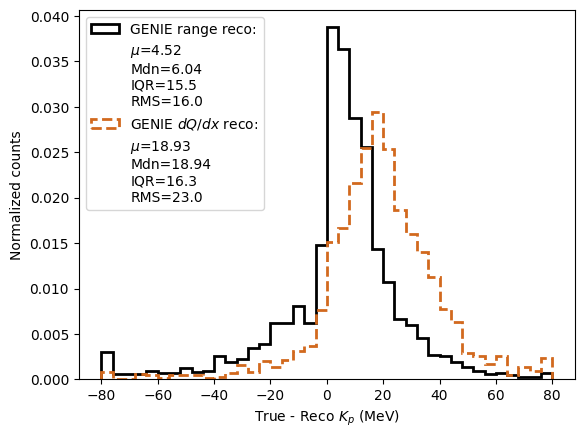

In [92]:
true_genie = kdar_overlay_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["truth_prim_p_energy"].to_numpy()
reco_genie = kdar_overlay_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["ssm_prim_track1_kine_energy_range"].to_numpy()
reco_genie_og = kdar_overlay_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["ssm_prim_track1_kine_energy_cal"].to_numpy()

genie_weights = kdar_overlay_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["net_weight"].to_numpy()

print("genie")
diff_genie = true_genie-reco_genie
genie_mean,genie_q,genie_std,genie_iqr,genie_rms = get_stats(diff_genie,weights=genie_weights)
print("")

print("genie,computed with weights")
diff_genie_og = true_genie-np.array(reco_genie_og)
genie_og_mean,genie_og_q,genie_og_std,genie_og_iqr,genie_og_rms = get_stats(diff_genie_og,weights=genie_weights)

xmin = -80
xmax = 80
nbins = 40
plt.figure()
plt.hist(np.clip(diff_genie,xmin,xmax),bins=nbins,range=(xmin,xmax),label=f'GENIE range reco:',histtype='step',color='black',lw=2,density=True,weights=genie_weights)
plt.plot([],[],lw=0,label=f'$\mu$={genie_mean:.2f}'+'\n'+f'Mdn={genie_q[1]:.2f}'+'\n'+f'IQR={genie_iqr:.1f}'+'\n'+f'RMS={genie_rms:.1f}')
plt.hist(np.clip(diff_genie_og,xmin,xmax),bins=nbins,range=(xmin,xmax),label=f'GENIE $dQ/dx$ reco:',color='chocolate',lw=2,density=True,histtype='step',weights=genie_weights,ls='--')
plt.plot([],[],lw=0,label=f'$\mu$={genie_og_mean:.2f}'+'\n'+f'Mdn={genie_og_q[1]:.2f}'+'\n'+f'IQR={genie_og_iqr:.1f}'+'\n'+f'RMS={genie_og_rms:.1f}')
plt.legend()
plt.ylabel("Normalized counts")
plt.xlabel(r"True - Reco $K_p$ (MeV)")
plt.show()

nuwro
mean: 3.155521863130226
median: 5.370124176025399
std: 26.155057202653282
q1: -14.096946403503413
q3: 22.622100189208993
IQR: 18.3595232963562
FWHM: 13.327446444029116
RMS: 18.237605101358962

nuwro,computed with weights
mean: 19.296464498862882
median: 18.52612479019166
std: 23.82002517290679
q1: 1.6535352020263758
q3: 40.122996643066415
IQR: 19.23473072052002
FWHM: 20.078527325751875
RMS: 24.52559206008046


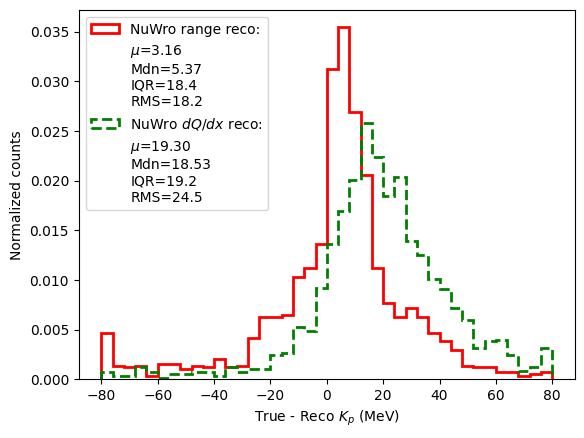

In [93]:
true_nuwro = nuwro_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["truth_prim_p_energy"].to_numpy()
reco_nuwro = nuwro_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["ssm_prim_track1_kine_energy_range"].to_numpy()
reco_nuwro_og = nuwro_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["ssm_prim_track1_kine_energy_cal"].to_numpy()

nuwro_weights = nuwro_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["net_weight"].to_numpy()

print("nuwro")
diff_nuwro = true_nuwro-reco_nuwro
nuwro_mean,nuwro_q,nuwro_std,nuwro_iqr,nuwro_rms = get_stats(diff_nuwro,weights=nuwro_weights)
print("")

print("nuwro,computed with weights")
diff_nuwro_og = true_nuwro-np.array(reco_nuwro_og)
nuwro_og_mean,nuwro_og_q,nuwro_og_std,nuwro_og_iqr,nuwro_og_rms = get_stats(diff_nuwro_og,weights=nuwro_weights)

xmin = -80
xmax = 80
nbins = 40
plt.figure()
plt.hist(np.clip(diff_nuwro,xmin,xmax),bins=nbins,range=(xmin,xmax),label=f'NuWro range reco:',histtype='step',color='red',lw=2,density=True,weights=nuwro_weights)
plt.plot([],[],lw=0,label=f'$\mu$={nuwro_mean:.2f}'+'\n'+f'Mdn={nuwro_q[1]:.2f}'+'\n'+f'IQR={nuwro_iqr:.1f}'+'\n'+f'RMS={nuwro_rms:.1f}')
plt.hist(np.clip(diff_nuwro_og,xmin,xmax),bins=nbins,range=(xmin,xmax),label=f'NuWro $dQ/dx$ reco:',color='green',lw=2,density=True,histtype='step',weights=nuwro_weights,ls='--')
plt.plot([],[],lw=0,label=f'$\mu$={nuwro_og_mean:.2f}'+'\n'+f'Mdn={nuwro_og_q[1]:.2f}'+'\n'+f'IQR={nuwro_og_iqr:.1f}'+'\n'+f'RMS={nuwro_og_rms:.1f}')
plt.legend()
plt.ylabel("Normalized counts")
plt.xlabel(r"True - Reco $K_p$ (MeV)")
plt.show()

gibuu
mean: -2.0197327930420257
median: 6.879267051696782
std: 26.51603907048217
q1: -18.85337702941894
q3: 13.719968631744393
IQR: 16.286672830581665
FWHM: 11.658552275791706
RMS: 17.560703448350264

gibuu,computed with weights
mean: 13.986665257937428
median: 17.631845787048345
std: 23.941299720959805
q1: 0.8499944953918508
q3: 32.45555408287049
IQR: 15.80277979373932
FWHM: 16.233341318628213
RMS: 22.407372307880273


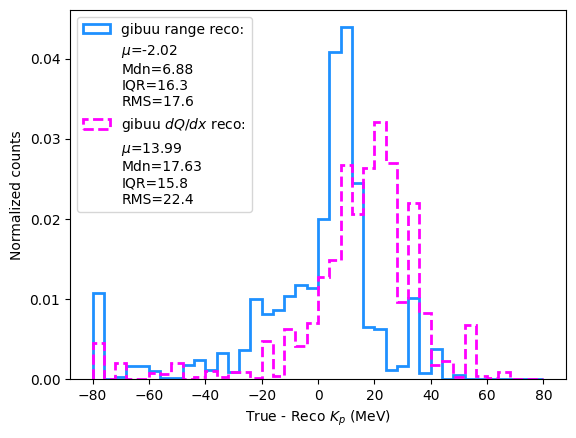

In [94]:
true_gibuu = gibuu_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["truth_prim_p_energy"].to_numpy()
reco_gibuu = gibuu_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["ssm_prim_track1_kine_energy_range"].to_numpy()
reco_gibuu_og = gibuu_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["ssm_prim_track1_kine_energy_cal"].to_numpy()

gibuu_weights = gibuu_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["net_weight"].to_numpy()

print("gibuu")
diff_gibuu = true_gibuu-reco_gibuu
gibuu_mean,gibuu_q,gibuu_std,gibuu_iqr,gibuu_rms = get_stats(diff_gibuu,weights=gibuu_weights)
print("")

print("gibuu,computed with weights")
diff_gibuu_og = true_gibuu-np.array(reco_gibuu_og)
gibuu_og_mean,gibuu_og_q,gibuu_og_std,gibuu_og_iqr,gibuu_og_rms = get_stats(diff_gibuu_og,weights=gibuu_weights)

xmin = -80
xmax = 80
nbins = 40
plt.figure()
plt.hist(np.clip(diff_gibuu,xmin,xmax),bins=nbins,range=(xmin,xmax),label=f'gibuu range reco:',histtype='step',color='dodgerblue',lw=2,density=True,weights=gibuu_weights)
plt.plot([],[],lw=0,label=f'$\mu$={gibuu_mean:.2f}'+'\n'+f'Mdn={gibuu_q[1]:.2f}'+'\n'+f'IQR={gibuu_iqr:.1f}'+'\n'+f'RMS={gibuu_rms:.1f}')
plt.hist(np.clip(diff_gibuu_og,xmin,xmax),bins=nbins,range=(xmin,xmax),label=f'gibuu $dQ/dx$ reco:',color='magenta',lw=2,density=True,histtype='step',weights=gibuu_weights,ls='--')
plt.plot([],[],lw=0,label=f'$\mu$={gibuu_og_mean:.2f}'+'\n'+f'Mdn={gibuu_og_q[1]:.2f}'+'\n'+f'IQR={gibuu_og_iqr:.1f}'+'\n'+f'RMS={gibuu_og_rms:.1f}')
plt.legend()
plt.ylabel("Normalized counts")
plt.xlabel(r"True - Reco $K_p$ (MeV)")
plt.show()

genie
mean: 4.520410131031565
median: 6.044632270812997
std: 22.737114394967186
q1: -11.016738578796382
q3: 20.030294254302987
IQR: 15.523516416549684
FWHM: 11.430017681826916
RMS: 15.958527620780908

genie,computed with weights
mean: 14.05663057955821
median: 16.220674827575692
std: 25.648149187577765
q1: -0.5489951820373484
q3: 34.02764494705201
IQR: 17.288320064544678
FWHM: 17.016036673918332
RMS: 22.70595938297393


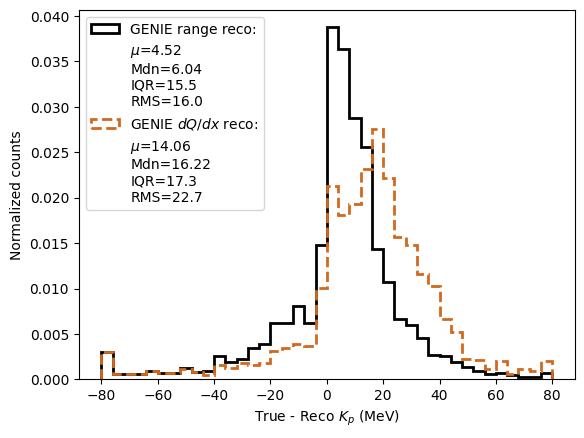

In [99]:
true_genie = kdar_overlay_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["truth_prim_p_energy"].to_numpy()
reco_genie = kdar_overlay_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["ssm_prim_track1_kine_energy_range"].to_numpy()
reco_genie_og_temp1 = kdar_overlay_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["ssm_prim_track1_kine_energy_cal"].to_numpy()
reco_genie_og_temp2 = kdar_overlay_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["ssm_prim_track1_kine_energy_range"].to_numpy()
reco_genie_length = kdar_overlay_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["ssm_prim_track1_length"].to_numpy()
reco_genie_og = []
for i in range(len(reco_genie_length)):
    if reco_genie_length[i]>4: reco_genie_og.append(reco_genie_og_temp2[i])
    else: reco_genie_og.append(reco_genie_og_temp1[i])
reco_genie_og = np.array(reco_genie_og)        

genie_weights = kdar_overlay_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["net_weight"].to_numpy()

print("genie")
diff_genie = true_genie-reco_genie
genie_mean,genie_q,genie_std,genie_iqr,genie_rms = get_stats(diff_genie,weights=genie_weights)
print("")

print("genie,computed with weights")
diff_genie_og = true_genie-np.array(reco_genie_og)
genie_og_mean,genie_og_q,genie_og_std,genie_og_iqr,genie_og_rms = get_stats(diff_genie_og,weights=genie_weights)

xmin = -80
xmax = 80
nbins = 40
plt.figure()
plt.hist(np.clip(diff_genie,xmin,xmax),bins=nbins,range=(xmin,xmax),label=f'GENIE range reco:',histtype='step',color='black',lw=2,density=True,weights=genie_weights)
plt.plot([],[],lw=0,label=f'$\mu$={genie_mean:.2f}'+'\n'+f'Mdn={genie_q[1]:.2f}'+'\n'+f'IQR={genie_iqr:.1f}'+'\n'+f'RMS={genie_rms:.1f}')
plt.hist(np.clip(diff_genie_og,xmin,xmax),bins=nbins,range=(xmin,xmax),label=f'GENIE $dQ/dx$ reco:',color='chocolate',lw=2,density=True,histtype='step',weights=genie_weights,ls='--')
plt.plot([],[],lw=0,label=f'$\mu$={genie_og_mean:.2f}'+'\n'+f'Mdn={genie_og_q[1]:.2f}'+'\n'+f'IQR={genie_og_iqr:.1f}'+'\n'+f'RMS={genie_og_rms:.1f}')
plt.legend()
plt.ylabel("Normalized counts")
plt.xlabel(r"True - Reco $K_p$ (MeV)")
plt.show()

nuwro
mean: 3.155521863130226
median: 5.370124176025399
std: 26.155057202653282
q1: -14.096946403503413
q3: 22.622100189208993
IQR: 18.3595232963562
FWHM: 13.327446444029116
RMS: 18.237605101358962

nuwro,computed with weights
mean: 12.58778962780711
median: 14.490779235839852
std: 29.01730210497683
q1: -3.5475460739135656
q3: 35.16539604949952
IQR: 19.356471061706543
FWHM: 17.671942185741045
RMS: 24.074310574235206


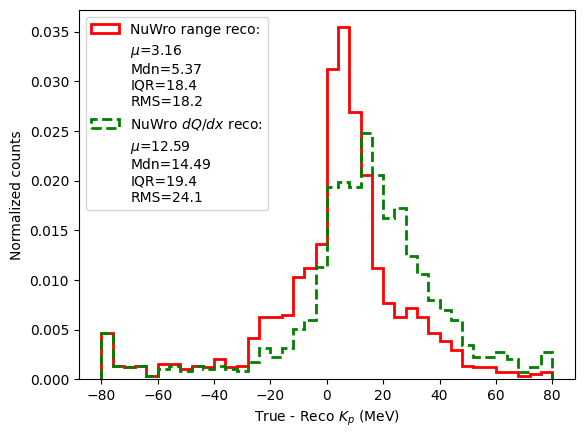

In [100]:
true_nuwro = nuwro_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["truth_prim_p_energy"].to_numpy()
reco_nuwro = nuwro_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["ssm_prim_track1_kine_energy_range"].to_numpy()
reco_nuwro_og_temp1 = nuwro_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["ssm_prim_track1_kine_energy_cal"].to_numpy()
reco_nuwro_og_temp2 = nuwro_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["ssm_prim_track1_kine_energy_range"].to_numpy()
reco_nuwro_length = nuwro_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["ssm_prim_track1_length"].to_numpy()
reco_nuwro_og = []
for i in range(len(reco_nuwro_length)):
    if reco_nuwro_length[i]>4: reco_nuwro_og.append(reco_nuwro_og_temp2[i])
    else: reco_nuwro_og.append(reco_nuwro_og_temp1[i])
reco_nuwro_og = np.array(reco_nuwro_og)        

nuwro_weights = nuwro_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["net_weight"].to_numpy()

print("nuwro")
diff_nuwro = true_nuwro-reco_nuwro
nuwro_mean,nuwro_q,nuwro_std,nuwro_iqr,nuwro_rms = get_stats(diff_nuwro,weights=nuwro_weights)
print("")

print("nuwro,computed with weights")
diff_nuwro_og = true_nuwro-np.array(reco_nuwro_og)
nuwro_og_mean,nuwro_og_q,nuwro_og_std,nuwro_og_iqr,nuwro_og_rms = get_stats(diff_nuwro_og,weights=nuwro_weights)

xmin = -80
xmax = 80
nbins = 40
plt.figure()
plt.hist(np.clip(diff_nuwro,xmin,xmax),bins=nbins,range=(xmin,xmax),label=f'NuWro range reco:',histtype='step',color='red',lw=2,density=True,weights=nuwro_weights)
plt.plot([],[],lw=0,label=f'$\mu$={nuwro_mean:.2f}'+'\n'+f'Mdn={nuwro_q[1]:.2f}'+'\n'+f'IQR={nuwro_iqr:.1f}'+'\n'+f'RMS={nuwro_rms:.1f}')
plt.hist(np.clip(diff_nuwro_og,xmin,xmax),bins=nbins,range=(xmin,xmax),label=f'NuWro $dQ/dx$ reco:',color='green',lw=2,density=True,histtype='step',weights=nuwro_weights,ls='--')
plt.plot([],[],lw=0,label=f'$\mu$={nuwro_og_mean:.2f}'+'\n'+f'Mdn={nuwro_og_q[1]:.2f}'+'\n'+f'IQR={nuwro_og_iqr:.1f}'+'\n'+f'RMS={nuwro_og_rms:.1f}')
plt.legend()
plt.ylabel("Normalized counts")
plt.xlabel(r"True - Reco $K_p$ (MeV)")
plt.show()

gibuu
mean: -2.0197327930420257
median: 6.879267051696782
std: 26.51603907048217
q1: -18.85337702941894
q3: 13.719968631744393
IQR: 16.286672830581665
FWHM: 11.658552275791706
RMS: 17.560703448350264

gibuu,computed with weights
mean: 9.750572999386497
median: 16.57575972366334
std: 29.375695982034497
q1: -3.1590968818664464
q3: 32.45555408287049
IQR: 17.80732548236847
FWHM: 16.30446935609336
RMS: 23.976253192327427


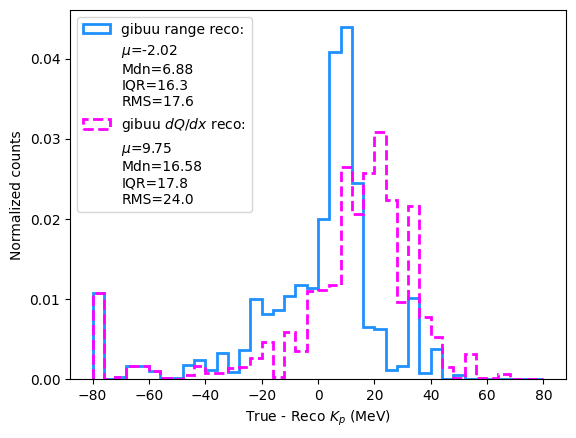

In [101]:
true_gibuu = gibuu_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["truth_prim_p_energy"].to_numpy()
reco_gibuu = gibuu_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["ssm_prim_track1_kine_energy_range"].to_numpy()
reco_gibuu_og_temp1 = gibuu_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["ssm_prim_track1_kine_energy_cal"].to_numpy()
reco_gibuu_og_temp2 = gibuu_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["ssm_prim_track1_kine_energy_range"].to_numpy()
reco_gibuu_length = gibuu_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["ssm_prim_track1_length"].to_numpy()
reco_gibuu_og = []
for i in range(len(reco_gibuu_length)):
    if reco_gibuu_length[i]>4: reco_gibuu_og.append(reco_gibuu_og_temp2[i])
    else: reco_gibuu_og.append(reco_gibuu_og_temp1[i])
reco_gibuu_og = np.array(reco_gibuu_og)  

gibuu_weights = gibuu_df.query(presel_query).query("ssm_prim_track1_kine_energy_range>0").query("truth_prim_p_energy>0").query("ssm_kine_energy>0").query("is_KDAR==1")["net_weight"].to_numpy()

print("gibuu")
diff_gibuu = true_gibuu-reco_gibuu
gibuu_mean,gibuu_q,gibuu_std,gibuu_iqr,gibuu_rms = get_stats(diff_gibuu,weights=gibuu_weights)
print("")

print("gibuu,computed with weights")
diff_gibuu_og = true_gibuu-np.array(reco_gibuu_og)
gibuu_og_mean,gibuu_og_q,gibuu_og_std,gibuu_og_iqr,gibuu_og_rms = get_stats(diff_gibuu_og,weights=gibuu_weights)

xmin = -80
xmax = 80
nbins = 40
plt.figure()
plt.hist(np.clip(diff_gibuu,xmin,xmax),bins=nbins,range=(xmin,xmax),label=f'gibuu range reco:',histtype='step',color='dodgerblue',lw=2,density=True,weights=gibuu_weights)
plt.plot([],[],lw=0,label=f'$\mu$={gibuu_mean:.2f}'+'\n'+f'Mdn={gibuu_q[1]:.2f}'+'\n'+f'IQR={gibuu_iqr:.1f}'+'\n'+f'RMS={gibuu_rms:.1f}')
plt.hist(np.clip(diff_gibuu_og,xmin,xmax),bins=nbins,range=(xmin,xmax),label=f'gibuu $dQ/dx$ reco:',color='magenta',lw=2,density=True,histtype='step',weights=gibuu_weights,ls='--')
plt.plot([],[],lw=0,label=f'$\mu$={gibuu_og_mean:.2f}'+'\n'+f'Mdn={gibuu_og_q[1]:.2f}'+'\n'+f'IQR={gibuu_og_iqr:.1f}'+'\n'+f'RMS={gibuu_og_rms:.1f}')
plt.legend()
plt.ylabel("Normalized counts")
plt.xlabel(r"True - Reco $K_p$ (MeV)")
plt.show()